# Mod 4 Project - Building Model to Predict House Price
The purpose of this project is to use Zillow's historical house sale data to build a machine learning data model that can help to predict future house sale price.
From that, we can go further to understand more about ROI, risks and opportunities to choose some best areas have best potential to invest in for profits.

# Step 1: Load and Clean the Data

In [1]:
# import all neccessary libraries
import warnings
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
import numpy as np
import seaborn as sns

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf # for determining (p,q) orders
from statsmodels.tsa.seasonal import seasonal_decompose      # for ETS Plots
from pmdarima import auto_arima                              # for determining ARIMA orders

from sklearn.metrics import mean_squared_error
from tqdm import tqdm
import itertools

# ignore all harmless waring to keep the notebook clean
warnings.filterwarnings('ignore')

# keep the plot inline in notebookb
%matplotlib inline

In [2]:
# load Zillow data
df = pd.read_csv('zillow_data.csv')

In [3]:
# quick look at the head of data
df.head()

RegionID  RegionName      City State              Metro CountyName  \
0     84654       60657   Chicago    IL            Chicago       Cook   
1     90668       75070  McKinney    TX  Dallas-Fort Worth     Collin   
2     91982       77494      Katy    TX            Houston     Harris   
3     84616       60614   Chicago    IL            Chicago       Cook   
4     93144       79936   El Paso    TX            El Paso    El Paso   

   SizeRank   1996-04   1996-05   1996-06  ...  2017-07  2017-08  2017-09  \
0         1  334200.0  335400.0  336500.0  ...  1005500  1007500  1007800   
1         2  235700.0  236900.0  236700.0  ...   308000   310000   312500   
2         3  210400.0  212200.0  212200.0  ...   321000   320600   320200   
3         4  498100.0  500900.0  503100.0  ...  1289800  1287700  1287400   
4         5   77300.0   77300.0   77300.0  ...   119100   119400   120000   

   2017-10  2017-11  2017-12  2018-01  2018-02  2018-03  2018-04  
0  1009600  1013300  1018700  1024400  1030700  1033800  1030600  
1   314100   315000   316600   318100   319600   321100   321800  
2   320400   320800   321200   321200   323000   326900   329900  
3  1291500  1296600  1299000  1302700  1306400  1308500  1307000  
4   120300   120300   120300   120300   120500   121000   121500  

[5 rows x 272 columns]

In [4]:
# count the null columns
null_columns = df.columns[df.isnull().any()]
df[null_columns].isnull().sum().head()

Metro      1043
1996-04    1039
1996-05    1039
1996-06    1039
1996-07    1039
dtype: int64

In [5]:
# glance look at the null data
pd.set_option('display.max_columns', 999)
print(df[df.isnull().any(axis=1)][null_columns].head())

        Metro   1996-04   1996-05   1996-06   1996-07   1996-08   1996-09  \
20   New York       NaN       NaN       NaN       NaN       NaN       NaN   
36   New York       NaN       NaN       NaN       NaN       NaN       NaN   
105   Chicago       NaN       NaN       NaN       NaN       NaN       NaN   
151       NaN  137100.0  136600.0  136000.0  135600.0  135300.0  135100.0   
156  New York       NaN       NaN       NaN       NaN       NaN       NaN   

      1996-10   1996-11   1996-12   1997-01   1997-02   1997-03   1997-04  \
20        NaN       NaN       NaN       NaN       NaN       NaN       NaN   
36        NaN       NaN       NaN       NaN       NaN       NaN       NaN   
105       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
151  135200.0  135600.0  136100.0  136700.0  137500.0  138300.0  139000.0   
156       NaN       NaN       NaN       NaN       NaN       NaN       NaN   

      1997-05   1997-06   1997-07   1997-08   1997-09   1997-10   1997-11 

156  1824000.0  


In [7]:
# drop all nan data
df.dropna(inplace = True)
df.isnull().sum().head()

RegionID      0
RegionName    0
City          0
State         0
Metro         0
dtype: int64

In [8]:
# list of all unique states
states = df['State'].unique()
print(states)

['IL' 'TX' 'NY' 'CA' 'FL' 'TN' 'NC' 'GA' 'DC' 'MO' 'OK' 'AZ' 'NJ' 'MD'
 'VA' 'WA' 'OH' 'MI' 'MA' 'KS' 'NM' 'CT' 'NV' 'PA' 'CO' 'OR' 'IN' 'SC'
 'KY' 'AR' 'MN' 'AL' 'DE' 'LA' 'MS' 'ID' 'MT' 'HI' 'WI' 'UT' 'ME' 'SD'
 'WV' 'IA' 'RI' 'NE' 'WY' 'AK' 'NH' 'VT']


In [9]:
# list of all unique zipcodes
zipcodes = df['RegionName'].unique()
zipcodes

array([60657, 75070, 77494, ...,  3293, 40404, 89155], dtype=int64)

# Step 2: Reshape from Wide to Long Format

In [12]:
def melt_data(df):
    """
    melt data of one zip code from wide format to long format
    """
    
    melted = pd.melt(df, id_vars=['RegionID', 'RegionName', 'City', 'State', \
                          'Metro', 'CountyName', 'SizeRank'], var_name='time')
    melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
    melted = melted.dropna(subset=['value'])
    
    return melted.groupby('time').aggregate({'value':'mean'})

In [13]:
def melt_df(df):
    """
    Loop through all zipcodes to melt data of each zipcode.
    Then, merge all melted data back together
    """
    
    merged = []
    for zipcode in df.RegionName:
        melted = melt_data(df.loc[df['RegionName'] == zipcode])
        row = df.loc[df['RegionName'] == zipcode].iloc[:,:7]
        rows = pd.concat([row]*len(melted), ignore_index=True)
        merge = pd.concat([rows, melted.reset_index()], axis= 1)
        merged.append(merge)
    melted_df = pd.concat(merged)
    return melted_df

In [ ]:
# call the function to really melt data
melted_df = melt_df(df)

In [21]:
melted_df.isna().sum()

RegionID      0
RegionName    0
City          0
State         0
Metro         0
CountyName    0
SizeRank      0
time          0
value         0
dtype: int64

In [22]:
melted_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3417175 entries, 0 to 264
Data columns (total 9 columns):
RegionID      int64
RegionName    int64
City          object
State         object
Metro         object
CountyName    object
SizeRank      int64
time          datetime64[ns]
value         float64
dtypes: datetime64[ns](1), float64(1), int64(3), object(4)
memory usage: 260.7+ MB


Set the time column as the index

In [30]:
melted_df.set_index('time', inplace=True)

KeyError: 'time'

In [29]:
melted_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3417175 entries, 1996-04-01 to 2018-04-01
Data columns (total 8 columns):
RegionID      int64
RegionName    int64
City          object
State         object
Metro         object
CountyName    object
SizeRank      int64
value         float64
dtypes: float64(1), int64(3), object(4)
memory usage: 234.6+ MB


In [31]:
melted_df.head()

RegionID  RegionName     City State    Metro CountyName  SizeRank  \
time                                                                            
1996-04-01     84654       60657  Chicago    IL  Chicago       Cook         1   
1996-05-01     84654       60657  Chicago    IL  Chicago       Cook         1   
1996-06-01     84654       60657  Chicago    IL  Chicago       Cook         1   
1996-07-01     84654       60657  Chicago    IL  Chicago       Cook         1   
1996-08-01     84654       60657  Chicago    IL  Chicago       Cook         1   

               value  
time                  
1996-04-01  334200.0  
1996-05-01  335400.0  
1996-06-01  336500.0  
1996-07-01  337600.0  
1996-08-01  338500.0

In [41]:
# drop unneccessar columns, only keep zipcode and value
final_df = melted_df.drop(['RegionID', 'City', 'State', 'Metro', 'CountyName', 'SizeRank'], axis=1)
final_df.rename(columns={'RegionName': 'zipcode'}, inplace=True)
final_df.head()

zipcode     value
time                         
1996-04-01    60657  334200.0
1996-05-01    60657  335400.0
1996-06-01    60657  336500.0
1996-07-01    60657  337600.0
1996-08-01    60657  338500.0

# Step 3: EDA and Visualization

In [ ]:
# Use plotly to visualize interactive price line chart over time
#!pip install plotly==4.2.1
import plotly.express as px

for zipcode in final_df['zipcode'].unique():   
    df1 = final_df[final_df['zipcode']==zipcode]
    df1 = df1.reset_index()
    fig = px.line(df1, x="time", y="value", hover_name='zipcode')
fig.show()

In [43]:
font = {'family' : 'monospace',
        'weight' : 'bold',
        'size'   : 12}

plt.rc('font', **font)

# NOTE: if your visualizations are too cluttered to read, 
#try calling 'plt.gcf().autofmt_xdate()'!

Making a visualization for the whole data, just to see the general trend of all the zipcodes

In [ ]:
plt.figure(figsize=(20,12))
for zipcode in melted_df.RegionName.unique():
    melted_df.loc[melted_df['RegionName'] == zipcode].value.plot(label=zipcode)
    
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=13)

plt.show()

In [45]:
best_five = list(best_five)
best_five

[94086, 94040, 94303, 94301, 94043]

I want to checkout the upper part of this graph as the lower part seems to not have much change from the start to the end. As it seems that the ones that have the most change start higher as well, I will just filter for the 10 best means and that should give me what I am looking for.

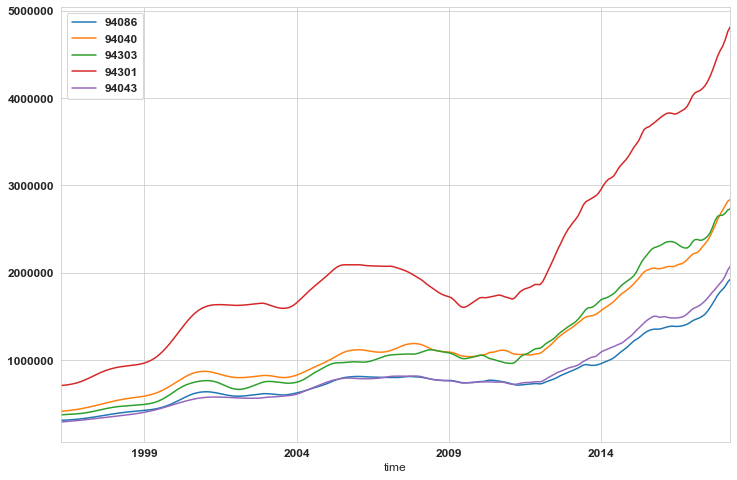

In [211]:
plt.figure(figsize=(12,8))
for zipcode in best_five:
    zipdf = melted_df.loc[melted_df['RegionName'] == zipcode].value
    zipdf.plot(label=zipcode)
plt.legend()
plt.show()

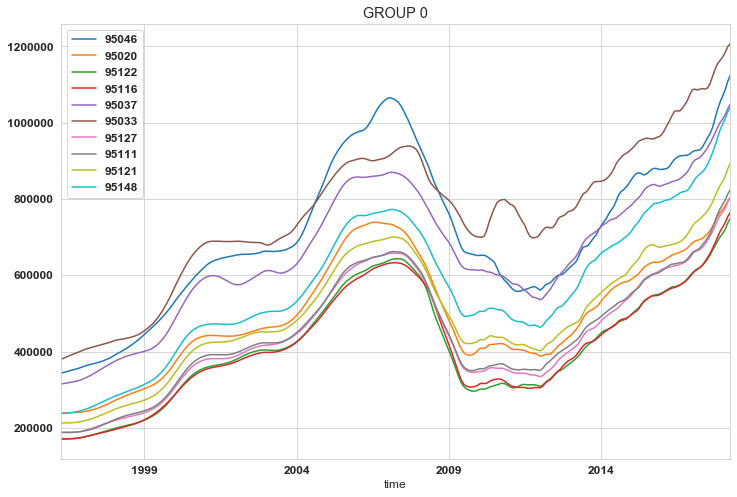

In [220]:
plt.figure(figsize=(12,8))
for zipcode in zipcode_groups[0]:
    zipdf = melted_df.loc[melted_df['RegionName'] == zipcode].value
    zipdf.plot(label=zipcode)
plt.title('GROUP 0')
plt.legend()
plt.show()

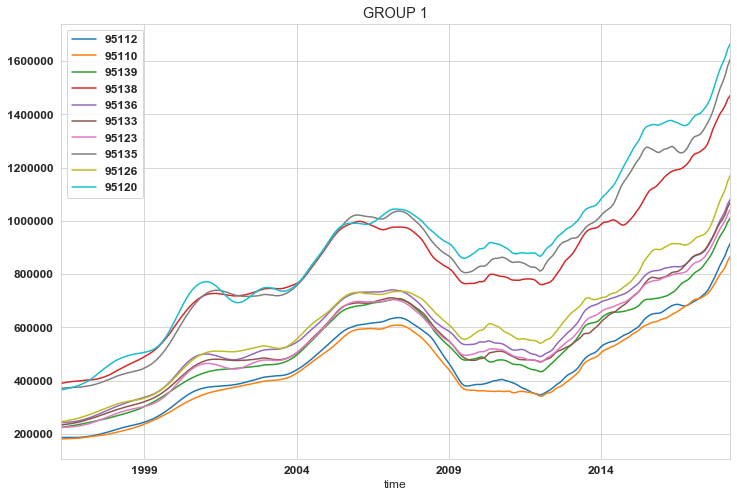

In [219]:
plt.figure(figsize=(12,8))
for zipcode in zipcode_groups[1]:
    zipdf = melted_df.loc[melted_df['RegionName'] == zipcode].value
    zipdf.plot(label=zipcode)
plt.title('GROUP 1')
plt.legend()
plt.show()

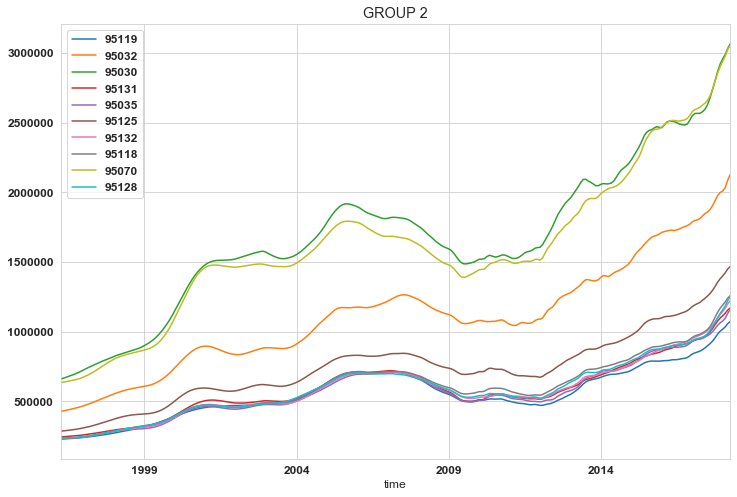

In [218]:
plt.figure(figsize=(12,8))
for zipcode in zipcode_groups[2]:
    zipdf = melted_df.loc[melted_df['RegionName'] == zipcode].value
    zipdf.plot(label=zipcode)
plt.title('GROUP 2')
plt.legend()
plt.show()

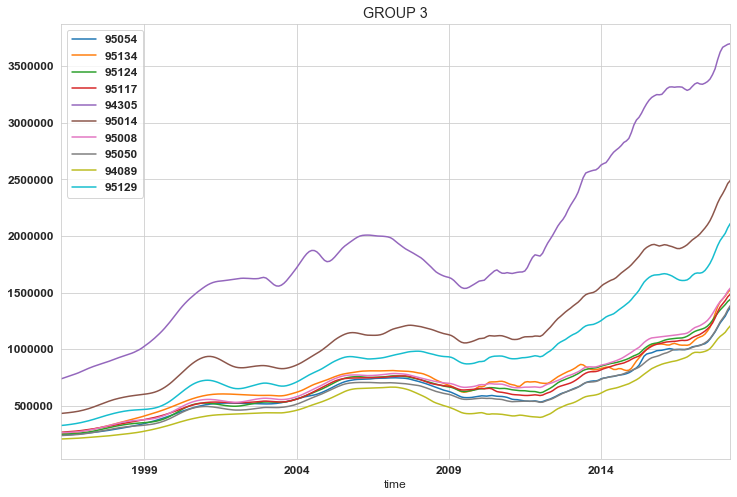

In [217]:
plt.figure(figsize=(12,8))
for zipcode in zipcode_groups[3]:
    zipdf = melted_df.loc[melted_df['RegionName'] == zipcode].value
    zipdf.plot(label=zipcode)
plt.title('GROUP 3')
plt.legend()
plt.show()

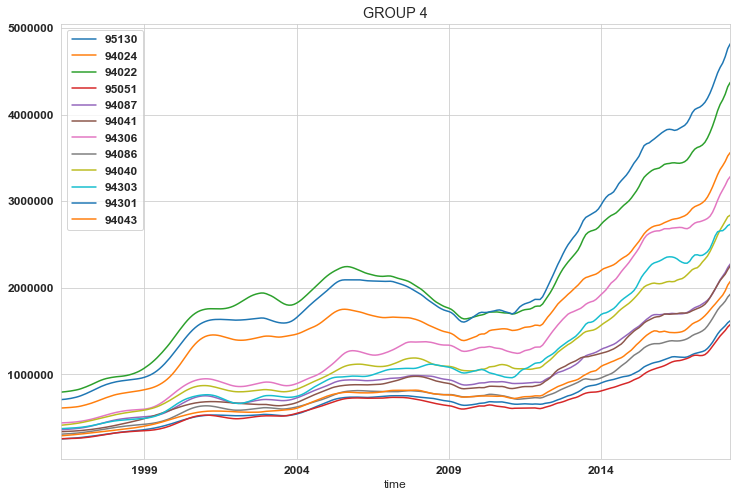

In [216]:
plt.figure(figsize=(12,8))
for zipcode in zipcode_groups[4]:
    zipdf = melted_df.loc[melted_df['RegionName'] == zipcode].value
    zipdf.plot(label=zipcode)
plt.title('GROUP 4')
plt.legend()
plt.show()

Eyeballing the graphic, I can see in general, the house value increase in every zipcodes. in 2007, 
Seems I got what I am looking for, from 1996 until 2019, these seem to be the most growing zipcodes, though what effect that will have on future growth remains to be seen. Might be interesting to check back at this after I figure out the best ones by predictionto see if they match up or not

Just want to see a basic breakdown of one zipcode to see the seasonality and trends.

### Run an ETS Decomposition

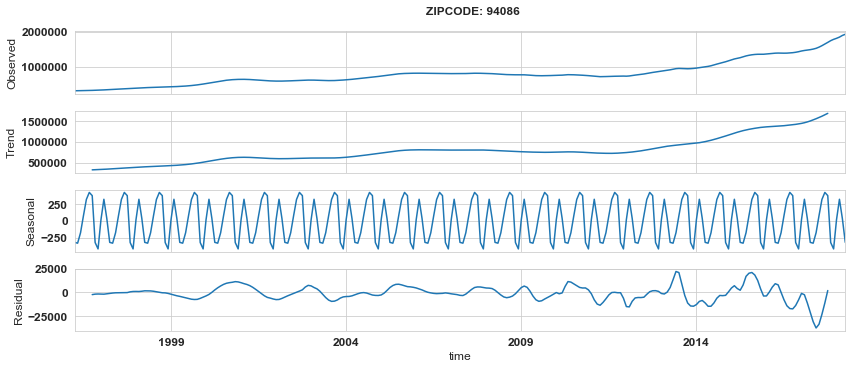

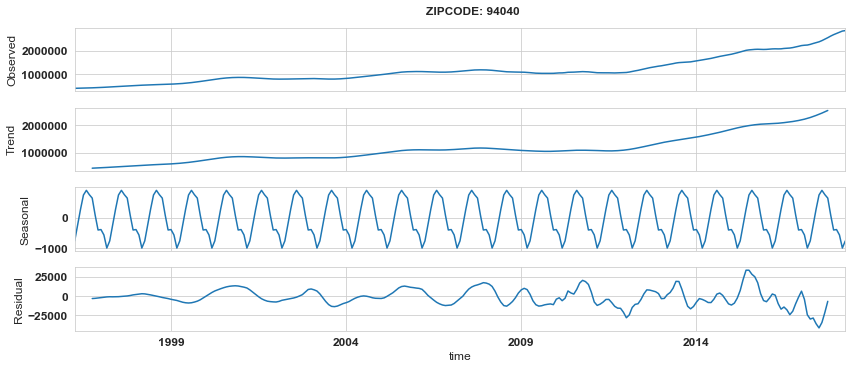

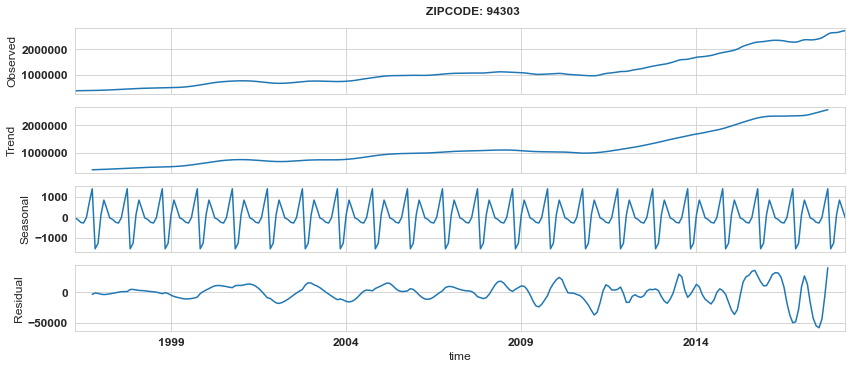

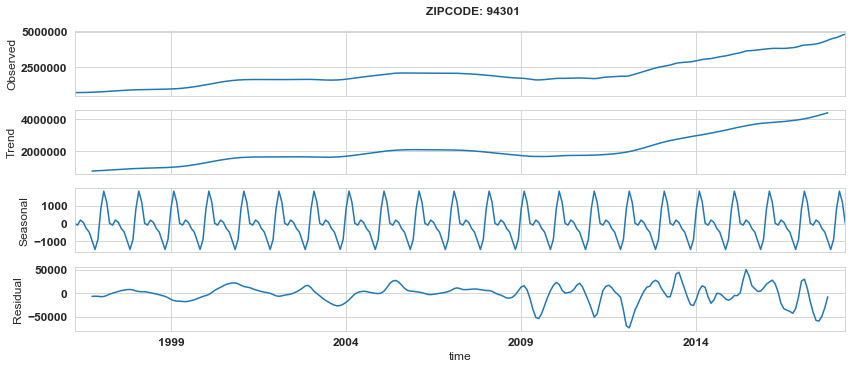

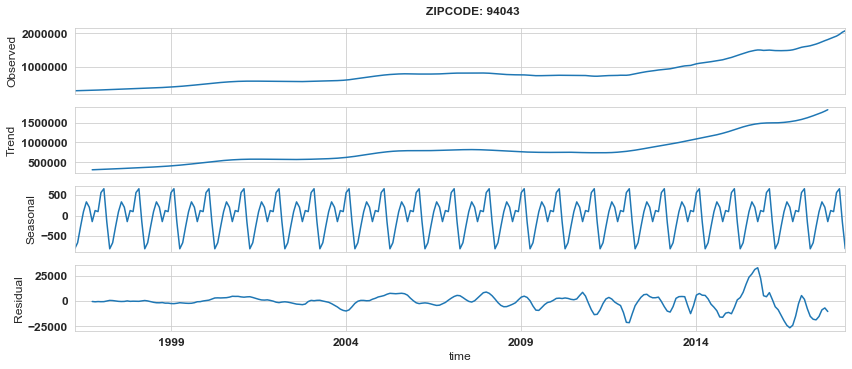

In [261]:
# from pylab import rcParams
# rcParams['figure.figsize'] = 12,5 (we can resize to big size)
for i in best_five:
    results = seasonal_decompose(melted_df.loc[melted_df['RegionName'] == i].value, model='add')
    fig = results.plot();
    fig.text(0.5,1,f'ZIPCODE: {i}')
    

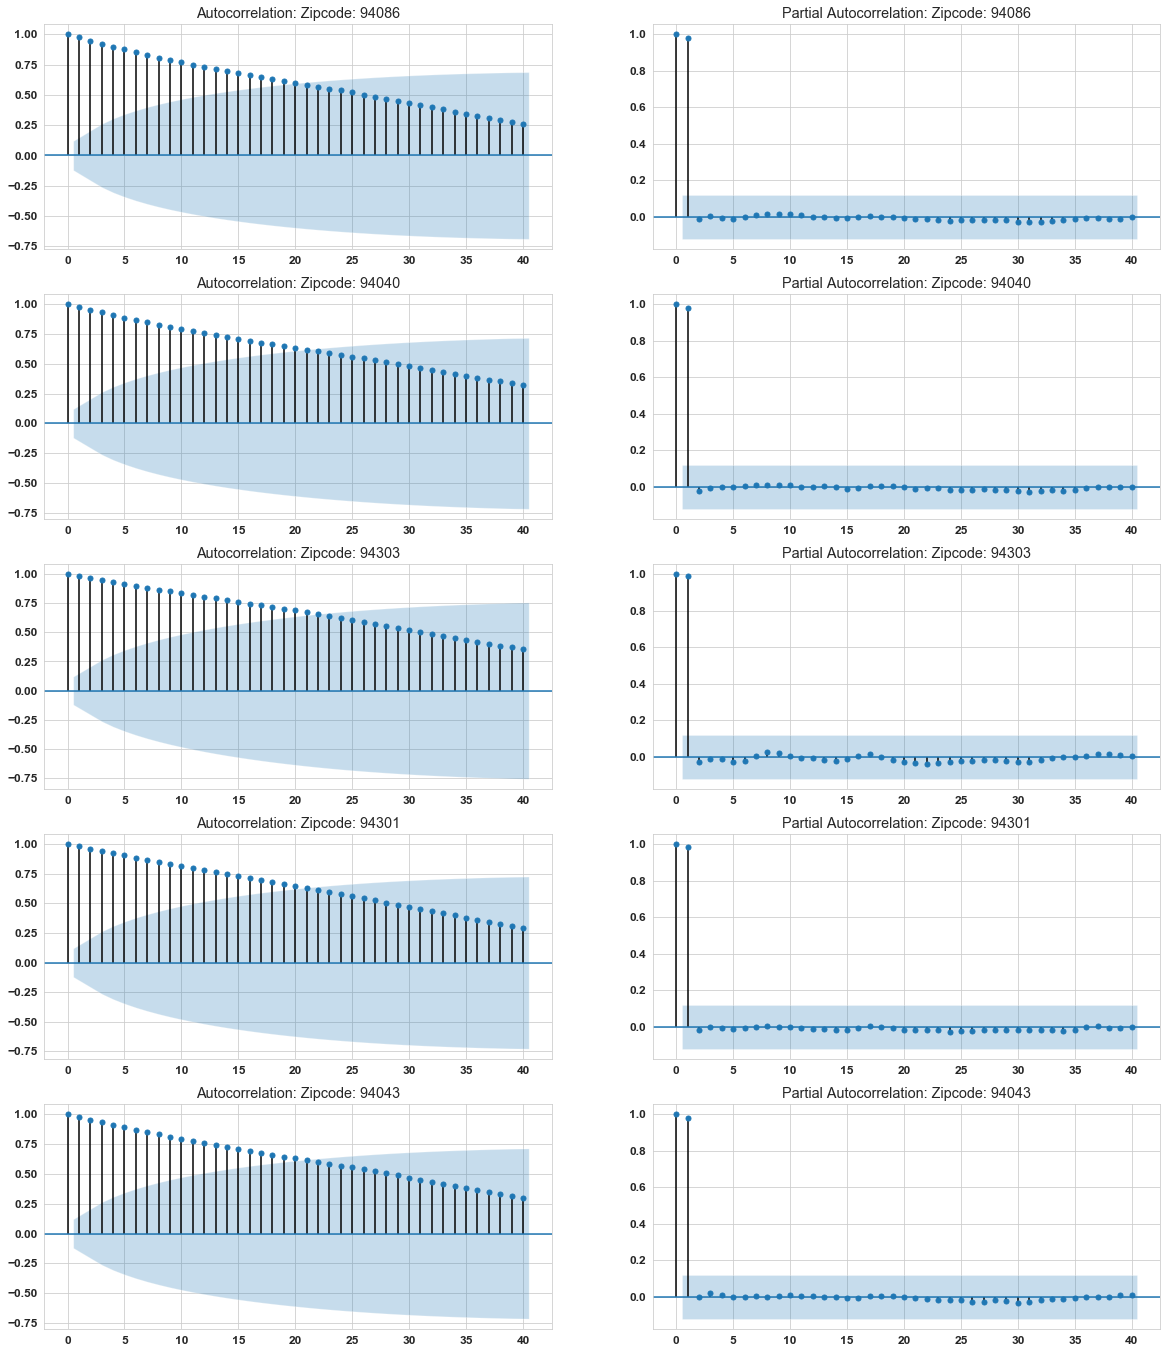

In [222]:
fig = plt.figure(figsize=(20,24))
i = 0
lags=40
for zipcode in best_five:
    i += 1
    ax = plt.subplot(5,2,i)
    title = f'Autocorrelation: Zipcode: {zipcode}'
    plot_acf(melted_df.loc[melted_df['RegionName'] == zipcode].value,alpha=0.05,title=title,lags=lags,ax=ax);

    i += 1
    ax = plt.subplot(5,2,i)
    title=f'Partial Autocorrelation: Zipcode: {zipcode}'
    plot_pacf(melted_df.loc[melted_df['RegionName'] == zipcode].value,alpha=0.05,title=title,lags=lags,ax=ax);

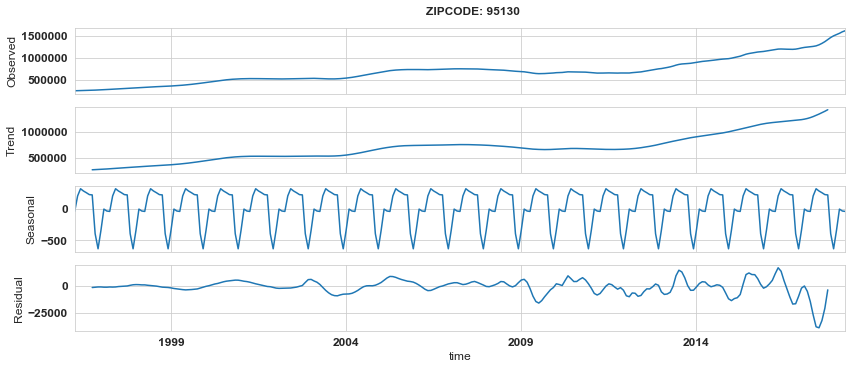

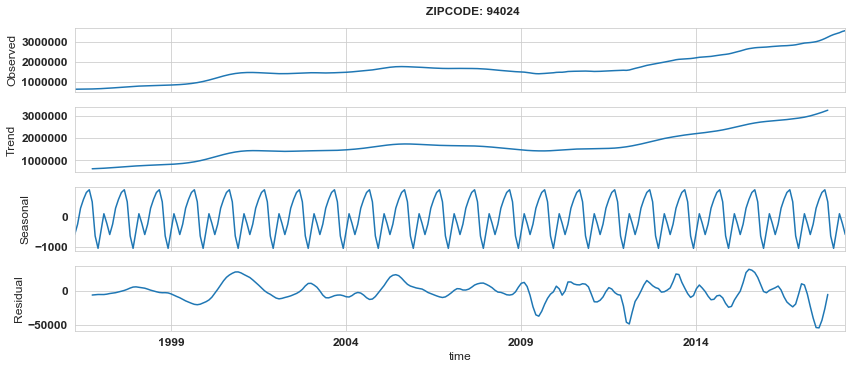

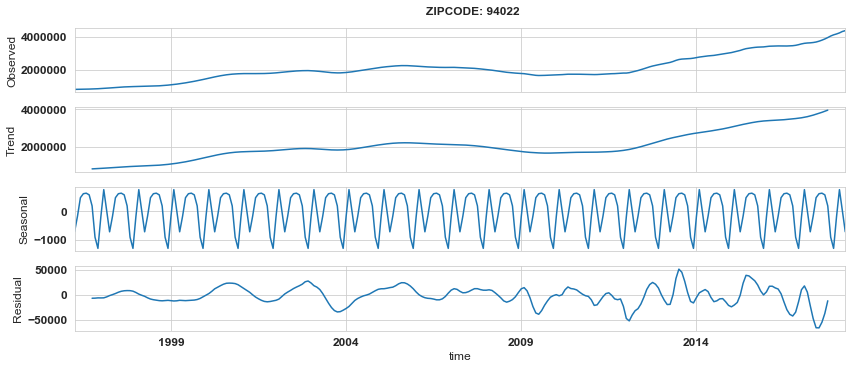

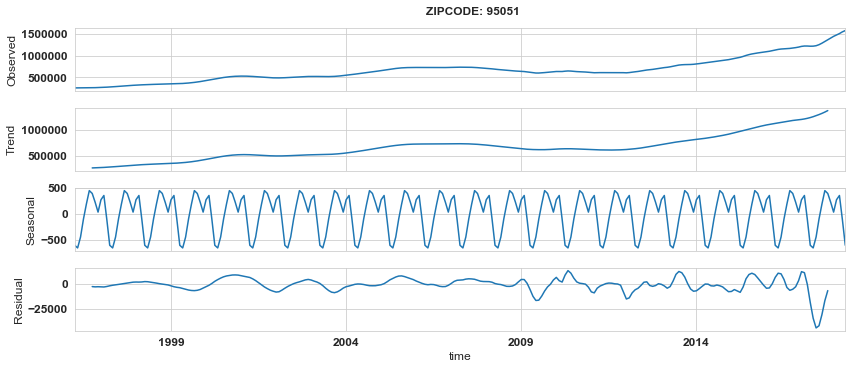

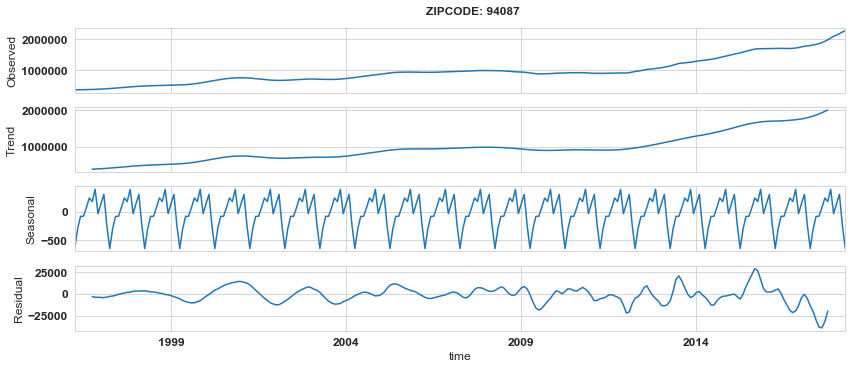

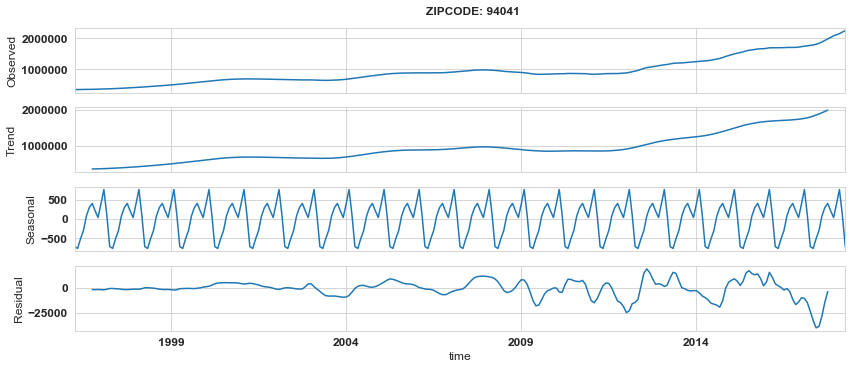

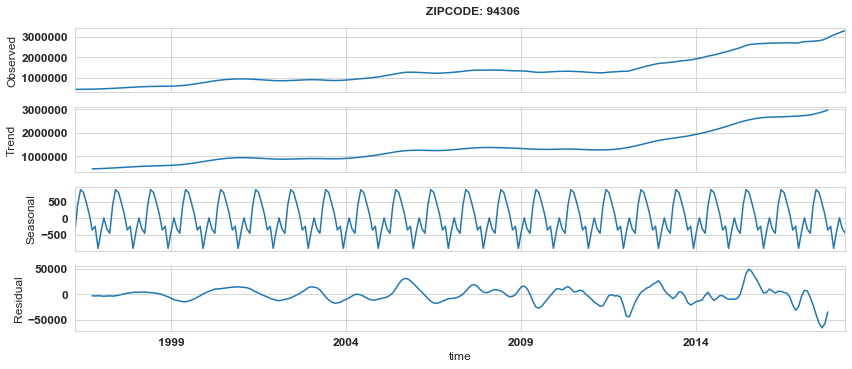

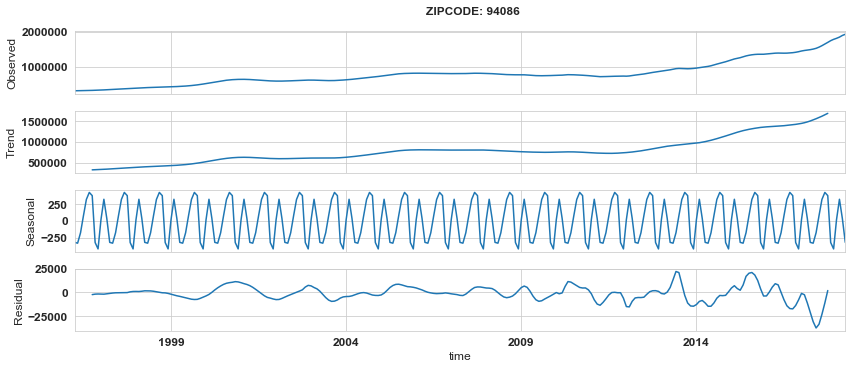

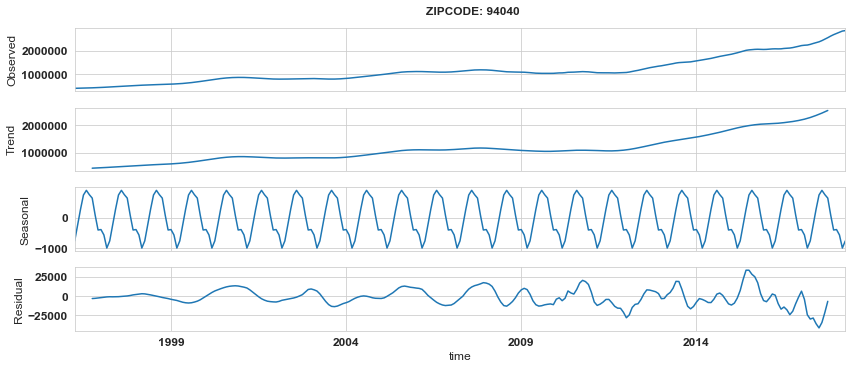

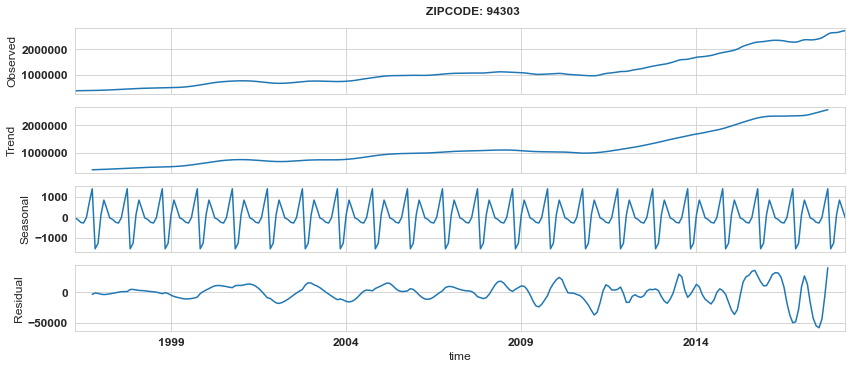

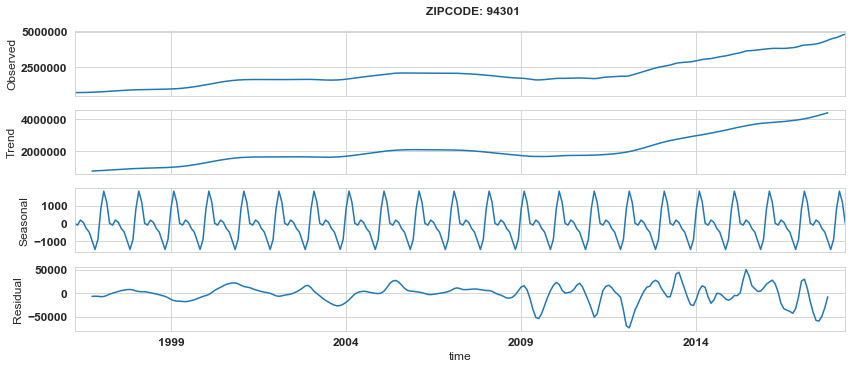

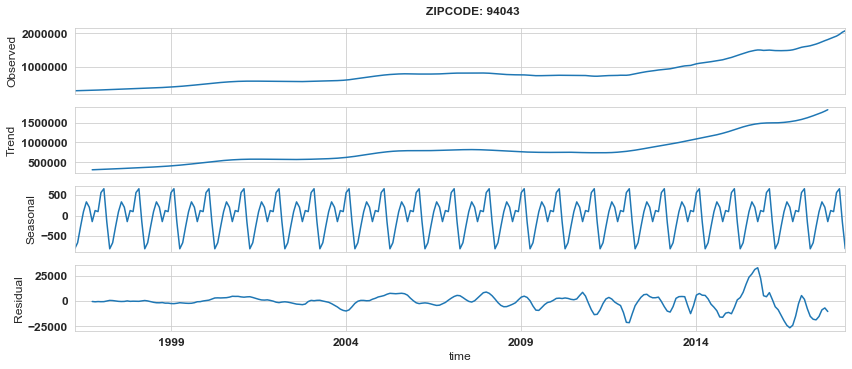

In [262]:
# from pylab import rcParams
rcParams['figure.figsize'] = 12,5 #(we can resize to big size)
for i in zipcode_groups[4]:
    results = seasonal_decompose(melted_df.loc[melted_df['RegionName'] == i].value, model='add')
    # to zoom into the seasonal graphic to see how the cycle looks like
    # result.seasonal.plot();
    fig = results.plot();
    fig.text(0.5,1,f'ZIPCODE: {i}')

##### They all go up, look seasonal, the residuals seem to be more volatile from the middle of graphic, after the year 2008 - the worst crisic year in history, the real estate market volatile significantly.

##### From the plot above we can clearly see the seasonal component of the data. They look very seasonal and the cycles are all 12 months. Besides, we can also see the separated upward trend of the data.


## Automate the augmented Dickey-Fuller Test
##### Function that performs the augmented Dickey-Fuller Test to determine if an incoming time series is stationary.

In [225]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")
        
    print("----------------------------")

In [247]:
for i in zipcode_groups[0]:
    adf_test(melted_df.loc[melted_df['RegionName'] == i].value, title= f'ZIPCODE: {i}')

Augmented Dickey-Fuller Test: ZIPCODE: 95046
ADF test statistic       -1.917444
p-value                   0.323900
# lags used              16.000000
# observations          248.000000
critical value (1%)      -3.456996
critical value (5%)      -2.873266
critical value (10%)     -2.573019
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary
----------------------------
Augmented Dickey-Fuller Test: ZIPCODE: 95020
ADF test statistic       -1.600120
p-value                   0.483533
# lags used              16.000000
# observations          248.000000
critical value (1%)      -3.456996
critical value (5%)      -2.873266
critical value (10%)     -2.573019
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary
----------------------------
Augmented Dickey-Fuller Test: ZIPCODE: 95122
ADF test statistic       -1.456973
p-value                   0.554679
# lags 

In [246]:
for i in zipcode_groups[1]:
    adf_test(melted_df.loc[melted_df['RegionName'] == i].value, title= f'ZIPCODE: {i}')

Augmented Dickey-Fuller Test: ZIPCODE: 95112
ADF test statistic       -0.568366
p-value                   0.877971
# lags used              15.000000
# observations          249.000000
critical value (1%)      -3.456888
critical value (5%)      -2.873219
critical value (10%)     -2.572994
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary
----------------------------
Augmented Dickey-Fuller Test: ZIPCODE: 95110
ADF test statistic       -0.169341
p-value                   0.942079
# lags used              16.000000
# observations          248.000000
critical value (1%)      -3.456996
critical value (5%)      -2.873266
critical value (10%)     -2.573019
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary
----------------------------
Augmented Dickey-Fuller Test: ZIPCODE: 95139
ADF test statistic       -0.347289
p-value                   0.918535
# lags 

In [245]:
for i in zipcode_groups[2]:
    adf_test(melted_df.loc[melted_df['RegionName'] == i].value, title= f'ZIPCODE: {i}')

Augmented Dickey-Fuller Test: ZIPCODE: 95119
ADF test statistic       -0.318458
p-value                   0.922849
# lags used              16.000000
# observations          248.000000
critical value (1%)      -3.456996
critical value (5%)      -2.873266
critical value (10%)     -2.573019
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary
----------------------------
Augmented Dickey-Fuller Test: ZIPCODE: 95032
ADF test statistic        1.074404
p-value                   0.994992
# lags used              10.000000
# observations          254.000000
critical value (1%)      -3.456360
critical value (5%)      -2.872987
critical value (10%)     -2.572870
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary
----------------------------
Augmented Dickey-Fuller Test: ZIPCODE: 95030
ADF test statistic        0.103872
p-value                   0.966324
# lags 

In [244]:
for i in zipcode_groups[3]:
    adf_test(melted_df.loc[melted_df['RegionName'] == i].value, title= f'ZIPCODE: {i}')

Augmented Dickey-Fuller Test: ZIPCODE: 95054
ADF test statistic        1.152276
p-value                   0.995639
# lags used              11.000000
# observations          253.000000
critical value (1%)      -3.456464
critical value (5%)      -2.873033
critical value (10%)     -2.572895
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary
----------------------------
Augmented Dickey-Fuller Test: ZIPCODE: 95134
ADF test statistic        0.885576
p-value                   0.992899
# lags used              16.000000
# observations          248.000000
critical value (1%)      -3.456996
critical value (5%)      -2.873266
critical value (10%)     -2.573019
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary
----------------------------
Augmented Dickey-Fuller Test: ZIPCODE: 95124
ADF test statistic        0.786389
p-value                   0.991413
# lags 

In [226]:
for i in zipcode_groups[4]:
    adf_test(melted_df.loc[melted_df['RegionName'] == i].value, title= f'ZIPCODE: {i}')

Augmented Dickey-Fuller Test: ZIPCODE: 95130
ADF test statistic        1.477078
p-value                   0.997438
# lags used              15.000000
# observations          249.000000
critical value (1%)      -3.456888
critical value (5%)      -2.873219
critical value (10%)     -2.572994
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary
----------------------------
Augmented Dickey-Fuller Test: ZIPCODE: 94024
ADF test statistic        1.202536
p-value                   0.996003
# lags used              14.000000
# observations          250.000000
critical value (1%)      -3.456781
critical value (5%)      -2.873172
critical value (10%)     -2.572969
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary
----------------------------
Augmented Dickey-Fuller Test: ZIPCODE: 94022
ADF test statistic        0.437453
p-value                   0.982843
# lags 

### Again, with the Augmented Dickey-Fuller Test results, all data for all zipcodes are all definite seasonal.

In [163]:
melted_df.loc[melted_df['RegionName'] == 94086][['value']]

value
time                 
1996-04-01   310400.0
1996-05-01   312000.0
1996-06-01   313800.0
1996-07-01   315600.0
1996-08-01   317600.0
1996-09-01   319800.0
1996-10-01   322100.0
1996-11-01   324800.0
1996-12-01   328000.0
1997-01-01   331700.0
1997-02-01   335600.0
1997-03-01   339600.0
1997-04-01   343800.0
1997-05-01   348300.0
1997-06-01   353100.0
1997-07-01   357900.0
1997-08-01   362700.0
1997-09-01   367400.0
1997-10-01   372100.0
1997-11-01   376700.0
1997-12-01   381400.0
1998-01-01   386200.0
1998-02-01   390600.0
1998-03-01   394600.0
1998-04-01   398500.0
1998-05-01   402100.0
1998-06-01   405600.0
1998-07-01   408800.0
1998-08-01   411700.0
1998-09-01   414300.0
...               ...
2015-11-01  1355500.0
2015-12-01  1355800.0
2016-01-01  1362100.0
2016-02-01  1371100.0
2016-03-01  1379700.0
2016-04-01  1386600.0
2016-05-01  1389600.0
2016-06-01  1387200.0
2016-07-01  1386400.0
2016-08-01  1387800.0
2016-09-01  1392800.0
2016-10-01  1400500.0
2016-11-01  1412300.0
2016-12-01  1428600.0
2017-01-01  1448800.0
2017-02-01  1463800.0
2017-03-01  1474300.0
2017-04-01  1487000.0
2017-05-01  1503200.0
2017-06-01  1525300.0
2017-07-01  1559300.0
2017-08-01  1601000.0
2017-09-01  1646500.0
2017-10-01  1695300.0
2017-11-01  1744100.0
2017-12-01  1782000.0
2018-01-01  1811300.0
2018-02-01  1846200.0
2018-03-01  1893700.0
2018-04-01  1926800.0

[265 rows x 1 columns]

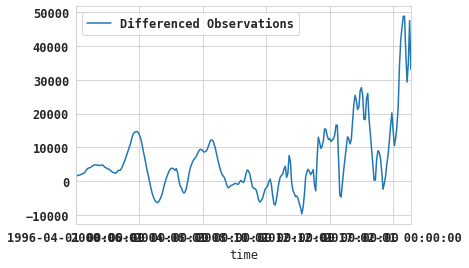

In [182]:
#get differenced values
diff = melted_df.loc[melted_df['RegionName'] == 94086][['value']].diff(periods=1).rename
                                 (index=str, columns={"value": "Differenced Observations"})
diff.plot();

In [184]:
#perform dickey fuller to see if our data is stationary
from statsmodels.tsa.stattools import adfuller
test = adfuller(diff['Differenced Observations'][1:-1])
dfoutput = pd.Series(test[0:4], index=['Test Statistic','p-value',
        '#Order of Difference Used','Number of Observations Used'])
print(dfoutput)

Test Statistic                  -0.010584
p-value                          0.957648
#Order of Difference Used       16.000000
Number of Observations Used    246.000000
dtype: float64


In [411]:
stepwise_fit_94086 = auto_arima(melted_df.loc[melted_df['RegionName'] == 94086].value, start_p=1, start_q=1,
                          max_p=3, max_q=3, m=12,
                          start_P=0, seasonal=True,
                          d=None, D=1, trace=True,
                          error_action='ignore',   # we don't want to know if an order does not work
                          suppress_warnings=True,  # we don't want convergence warnings
                          stepwise=True)           # set to stepwise

stepwise_fit_94086.summary()

Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=5335.058, BIC=5352.705, Fit time=1.248 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 12); AIC=5422.703, BIC=5429.762, Fit time=0.013 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 12); AIC=5352.161, BIC=5366.279, Fit time=0.692 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=5368.687, BIC=5382.805, Fit time=0.160 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 1, 12); AIC=5321.250, BIC=5342.427, Fit time=1.238 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 0, 12); AIC=5339.738, BIC=5357.385, Fit time=0.808 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 2, 12); AIC=5443.408, BIC=5468.114, Fit time=4.016 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 0, 12); AIC=5314.260, BIC=5328.378, Fit time=0.417 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 0, 12); AIC=5385.796, BIC=5396.384, Fit time=0.047 seconds
Fit ARIMA: order=(2, 1, 1) s

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  265
Model:             SARIMAX(1, 1, 1)x(0, 1, 0, 12)   Log Likelihood               -2653.130
Date:                            Tue, 22 Oct 2019   AIC                           5314.260
Time:                                    11:33:01   BIC                           5328.378
Sample:                                         0   HQIC                          5319.941
                                            - 265                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    959.2502    252.396      3.801      0.000     464.563    1453.937
ar.L1          0.8016      0.025     31.604      0.000       0.752       0.851
ma.L1         -0.6012      0.026    -23.029      0.000      -0.652      -0.550
sigma2      7.835e+07      0.002   4.04e+10      0.000    7.84e+07    7.84e+07
===================================================================================
Ljung-Box (Q):                      614.72   Jarque-Bera (JB):               940.21
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.29   Skew:                             1.76
Prob(H) (two-sided):                  0.24   Kurtosis:                        11.78
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.75e+26. Standard errors may be unstable.
"""

In [232]:
for i in zipcode_groups[0]:
    stepwise_fit = auto_arima(melted_df.loc[melted_df['RegionName'] == i].value, start_p=0, start_q=0,
                          max_p=3, max_q=3, m=12,
                          start_P=0, seasonal=True,
                          d=None, D=1, trace=True,
                          error_action='ignore',   # we don't want to know if an order does not work
                          suppress_warnings=True,  # we don't want convergence warnings
                          stepwise=True)           # set to stepwise

    print(f'the optimal ARIMA model for ZIPCODE: {i}')
    print(stepwise_fit.summary())

Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 1, 1, 12); AIC=6432.646, BIC=6443.246, Fit time=0.124 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 1, 0, 12); AIC=6485.595, BIC=6492.662, Fit time=0.013 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(1, 1, 0, 12); AIC=5810.744, BIC=5824.877, Fit time=0.433 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(0, 1, 1, 12); AIC=6310.065, BIC=6324.198, Fit time=0.151 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(0, 1, 0, 12); AIC=5812.108, BIC=5822.708, Fit time=0.135 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(2, 1, 0, 12); AIC=5841.245, BIC=5858.912, Fit time=2.016 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(1, 1, 1, 12); AIC=5851.960, BIC=5869.627, Fit time=0.904 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(2, 1, 1, 12); AIC=5884.814, BIC=5906.015, Fit time=2.255 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(1, 1, 0, 12); AIC=6438.702, BIC=6449.302, Fit time=0.237 seconds
Fit ARIMA: order=(2, 0, 0) s

Fit ARIMA: order=(1, 0, 0) seasonal_order=(0, 1, 1, 12); AIC=5486.643, BIC=5500.777, Fit time=0.806 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(1, 1, 2, 12); AIC=5584.291, BIC=5605.491, Fit time=2.077 seconds
Fit ARIMA: order=(2, 0, 0) seasonal_order=(0, 1, 1, 12); AIC=5590.459, BIC=5608.126, Fit time=0.930 seconds
Fit ARIMA: order=(1, 0, 1) seasonal_order=(0, 1, 1, 12); AIC=5636.545, BIC=5654.212, Fit time=0.832 seconds
Fit ARIMA: order=(2, 0, 1) seasonal_order=(0, 1, 1, 12); AIC=5490.161, BIC=5511.361, Fit time=1.510 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(1, 1, 1, 12); AIC=5624.343, BIC=5642.010, Fit time=1.072 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(0, 1, 2, 12); AIC=5547.872, BIC=5565.539, Fit time=2.050 seconds
Total fit time: 10.187 seconds
the optimal ARIMA model for ZIPCODE: 95122
                                 Statespace Model Results                                 
Dep. Variable:                                  y   No. Observations:          

Fit ARIMA: order=(1, 0, 0) seasonal_order=(1, 1, 0, 12); AIC=5721.857, BIC=5735.991, Fit time=0.906 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(0, 1, 1, 12); AIC=6183.544, BIC=6197.678, Fit time=0.222 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(0, 1, 0, 12); AIC=5755.069, BIC=5765.669, Fit time=0.123 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(2, 1, 0, 12); AIC=5755.505, BIC=5773.172, Fit time=3.470 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(1, 1, 1, 12); AIC=6967.888, BIC=6985.555, Fit time=0.626 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(2, 1, 1, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(1, 1, 0, 12); AIC=6318.834, BIC=6329.434, Fit time=0.265 seconds
Fit ARIMA: order=(2, 0, 0) seasonal_order=(1, 1, 0, 12); AIC=6010.335, BIC=6028.002, Fit time=1.210 seconds
Fit ARIMA: order=(1, 0, 1) seasonal_order=(1, 1, 0, 12); AIC=5787.214, BIC=5804.881, Fit time=1.031 seconds
Fit ARIMA: order=(2, 0, 1) seasonal_orde

Fit ARIMA: order=(1, 0, 0) seasonal_order=(1, 1, 0, 12); AIC=5527.061, BIC=5541.195, Fit time=0.659 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(0, 1, 1, 12); AIC=6148.198, BIC=6162.332, Fit time=0.188 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(0, 1, 0, 12); AIC=5526.155, BIC=5536.755, Fit time=0.131 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(0, 1, 1, 12); AIC=5519.144, BIC=5533.278, Fit time=0.958 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(1, 1, 2, 12); AIC=5605.979, BIC=5627.180, Fit time=2.491 seconds
Fit ARIMA: order=(2, 0, 0) seasonal_order=(0, 1, 1, 12); AIC=5516.414, BIC=5534.081, Fit time=0.998 seconds
Fit ARIMA: order=(2, 0, 1) seasonal_order=(0, 1, 1, 12); AIC=5543.188, BIC=5564.388, Fit time=1.071 seconds
Fit ARIMA: order=(3, 0, 1) seasonal_order=(0, 1, 1, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(2, 0, 0) seasonal_order=(1, 1, 1, 12); AIC=5524.083, BIC=5545.283, Fit time=1.283 seconds
Fit ARIMA: order=(2, 0, 0) seasonal_orde

Fit ARIMA: order=(1, 0, 1) seasonal_order=(1, 1, 0, 12); AIC=5614.844, BIC=5632.511, Fit time=0.754 seconds
Fit ARIMA: order=(2, 0, 2) seasonal_order=(1, 1, 0, 12); AIC=6341.202, BIC=6365.935, Fit time=1.472 seconds
Fit ARIMA: order=(1, 0, 1) seasonal_order=(0, 1, 0, 12); AIC=5627.292, BIC=5641.426, Fit time=0.287 seconds
Fit ARIMA: order=(1, 0, 1) seasonal_order=(2, 1, 0, 12); AIC=5629.411, BIC=5650.611, Fit time=1.806 seconds
Fit ARIMA: order=(1, 0, 1) seasonal_order=(1, 1, 1, 12); AIC=6158.198, BIC=6179.398, Fit time=1.164 seconds
Fit ARIMA: order=(1, 0, 1) seasonal_order=(2, 1, 1, 12); AIC=6303.639, BIC=6328.373, Fit time=2.181 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(1, 1, 0, 12); AIC=6179.899, BIC=6194.032, Fit time=0.134 seconds
Fit ARIMA: order=(2, 0, 1) seasonal_order=(1, 1, 0, 12); AIC=6387.720, BIC=6408.921, Fit time=0.885 seconds
Fit ARIMA: order=(1, 0, 2) seasonal_order=(1, 1, 0, 12); AIC=5649.577, BIC=5670.777, Fit time=0.793 seconds
Total fit time: 18.404 secon

In [231]:
for i in zipcode_groups[1]:
    stepwise_fit = auto_arima(melted_df.loc[melted_df['RegionName'] == i].value, start_p=0, start_q=0,
                          max_p=3, max_q=3, m=12,
                          start_P=0, seasonal=True,
                          d=None, D=1, trace=True,
                          error_action='ignore',   # we don't want to know if an order does not work
                          suppress_warnings=True,  # we don't want convergence warnings
                          stepwise=True)           # set to stepwise

    print(f'the optimal ARIMA model for ZIPCODE: {i}')
    print(stepwise_fit.summary())

Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 1, 1, 12); AIC=6274.209, BIC=6284.809, Fit time=0.147 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 1, 0, 12); AIC=6308.247, BIC=6315.314, Fit time=0.014 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(1, 1, 0, 12); AIC=5533.699, BIC=5547.833, Fit time=0.621 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(0, 1, 1, 12); AIC=6133.332, BIC=6147.465, Fit time=0.176 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(0, 1, 0, 12); AIC=5540.093, BIC=5550.693, Fit time=0.122 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(2, 1, 0, 12); AIC=5533.591, BIC=5551.258, Fit time=1.767 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(2, 1, 1, 12); AIC=5624.912, BIC=5646.113, Fit time=1.971 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(2, 1, 0, 12); AIC=6278.934, BIC=6293.067, Fit time=0.271 seconds
Fit ARIMA: order=(2, 0, 0) seasonal_order=(2, 1, 0, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 0, 1) seasonal_orde

Fit ARIMA: order=(1, 0, 0) seasonal_order=(0, 1, 0, 12); AIC=5599.213, BIC=5609.813, Fit time=0.135 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(0, 1, 1, 12); AIC=5587.873, BIC=5602.007, Fit time=0.520 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(1, 1, 2, 12); AIC=5591.181, BIC=5612.381, Fit time=1.757 seconds
Fit ARIMA: order=(2, 0, 0) seasonal_order=(0, 1, 1, 12); AIC=5634.724, BIC=5652.391, Fit time=1.062 seconds
Fit ARIMA: order=(1, 0, 1) seasonal_order=(0, 1, 1, 12); AIC=5590.231, BIC=5607.898, Fit time=0.885 seconds
Fit ARIMA: order=(2, 0, 1) seasonal_order=(0, 1, 1, 12); AIC=5590.802, BIC=5612.003, Fit time=1.305 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(1, 1, 1, 12); AIC=5589.594, BIC=5607.261, Fit time=0.991 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(0, 1, 2, 12); AIC=5587.840, BIC=5605.507, Fit time=1.953 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 1, 2, 12); AIC=6255.440, BIC=6269.574, Fit time=0.326 seconds
Fit ARIMA: order=(2, 0, 0) s

Fit ARIMA: order=(2, 0, 0) seasonal_order=(1, 1, 1, 12); AIC=5662.934, BIC=5684.134, Fit time=1.445 seconds
Fit ARIMA: order=(1, 0, 1) seasonal_order=(1, 1, 1, 12); AIC=6210.090, BIC=6231.290, Fit time=1.324 seconds
Fit ARIMA: order=(2, 0, 1) seasonal_order=(1, 1, 1, 12); AIC=5836.138, BIC=5860.872, Fit time=1.337 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(0, 1, 1, 12); AIC=5621.821, BIC=5635.954, Fit time=0.443 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(0, 1, 2, 12); AIC=5624.294, BIC=5641.961, Fit time=1.560 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(1, 1, 2, 12); AIC=5625.843, BIC=5647.043, Fit time=2.323 seconds
Fit ARIMA: order=(2, 0, 0) seasonal_order=(0, 1, 1, 12); AIC=5624.626, BIC=5642.293, Fit time=1.068 seconds
Fit ARIMA: order=(1, 0, 1) seasonal_order=(0, 1, 1, 12); AIC=6286.229, BIC=6303.895, Fit time=0.991 seconds
Fit ARIMA: order=(2, 0, 1) seasonal_order=(0, 1, 1, 12); AIC=5682.131, BIC=5703.332, Fit time=1.020 seconds
Total fit time: 18.777 secon

Fit ARIMA: order=(1, 0, 0) seasonal_order=(2, 1, 2, 12); AIC=5790.102, BIC=5814.836, Fit time=2.481 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(1, 1, 1, 12); AIC=6259.722, BIC=6273.856, Fit time=0.170 seconds
Fit ARIMA: order=(2, 0, 0) seasonal_order=(1, 1, 1, 12); AIC=5782.462, BIC=5803.662, Fit time=1.065 seconds
Fit ARIMA: order=(1, 0, 1) seasonal_order=(1, 1, 1, 12); AIC=6257.388, BIC=6278.589, Fit time=1.174 seconds
Fit ARIMA: order=(2, 0, 1) seasonal_order=(1, 1, 1, 12); AIC=5751.714, BIC=5776.447, Fit time=1.111 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(0, 1, 1, 12); AIC=5586.767, BIC=5600.900, Fit time=0.892 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(0, 1, 2, 12); AIC=5592.485, BIC=5610.152, Fit time=1.758 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(1, 1, 2, 12); AIC=5665.898, BIC=5687.099, Fit time=2.289 seconds
Fit ARIMA: order=(2, 0, 0) seasonal_order=(0, 1, 1, 12); AIC=5587.722, BIC=5605.389, Fit time=0.674 seconds
Fit ARIMA: order=(1, 0, 1) s

Fit ARIMA: order=(1, 0, 0) seasonal_order=(1, 1, 0, 12); AIC=5811.001, BIC=5825.134, Fit time=1.046 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(0, 1, 1, 12); AIC=6269.802, BIC=6283.935, Fit time=0.161 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(0, 1, 0, 12); AIC=5854.238, BIC=5864.838, Fit time=0.138 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(2, 1, 0, 12); AIC=5808.241, BIC=5825.908, Fit time=2.265 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(2, 1, 1, 12); AIC=5807.943, BIC=5829.143, Fit time=2.023 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(2, 1, 1, 12); AIC=6424.515, BIC=6442.182, Fit time=0.430 seconds
Fit ARIMA: order=(2, 0, 0) seasonal_order=(2, 1, 1, 12); AIC=6012.698, BIC=6037.432, Fit time=3.080 seconds
Fit ARIMA: order=(1, 0, 1) seasonal_order=(2, 1, 1, 12); AIC=5825.642, BIC=5850.376, Fit time=2.167 seconds
Fit ARIMA: order=(2, 0, 1) seasonal_order=(2, 1, 1, 12); AIC=11152.601, BIC=11180.868, Fit time=3.214 seconds
Fit ARIMA: order=(1, 0, 0)

In [230]:
for i in zipcode_groups[2]:
    stepwise_fit = auto_arima(melted_df.loc[melted_df['RegionName'] == i].value, start_p=0, start_q=0,
                          max_p=3, max_q=3, m=12,
                          start_P=0, seasonal=True,
                          d=None, D=1, trace=True,
                          error_action='ignore',   # we don't want to know if an order does not work
                          suppress_warnings=True,  # we don't want convergence warnings
                          stepwise=True)           # set to stepwise

    print(f'the optimal ARIMA model for ZIPCODE: {i}')
    print(stepwise_fit.summary())

Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 1, 1, 12); AIC=6283.699, BIC=6294.299, Fit time=0.101 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 1, 0, 12); AIC=6312.125, BIC=6319.192, Fit time=0.013 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(1, 1, 0, 12); AIC=5615.316, BIC=5629.450, Fit time=0.546 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(0, 1, 1, 12); AIC=6142.652, BIC=6156.786, Fit time=0.181 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(0, 1, 0, 12); AIC=5616.724, BIC=5627.325, Fit time=0.132 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(2, 1, 0, 12); AIC=5657.149, BIC=5674.816, Fit time=1.723 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(1, 1, 1, 12); AIC=5599.934, BIC=5617.601, Fit time=1.024 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(2, 1, 2, 12); AIC=5603.870, BIC=5628.604, Fit time=3.108 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(1, 1, 1, 12); AIC=6285.109, BIC=6299.243, Fit time=0.183 seconds
Fit ARIMA: order=(2, 0, 0) s

Fit ARIMA: order=(1, 0, 0) seasonal_order=(1, 1, 0, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(0, 1, 1, 12); AIC=6585.689, BIC=6599.823, Fit time=0.158 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(1, 1, 1, 12); AIC=6587.687, BIC=6605.354, Fit time=0.251 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(0, 1, 0, 12); AIC=6585.310, BIC=6595.910, Fit time=0.045 seconds
Fit ARIMA: order=(1, 0, 1) seasonal_order=(0, 1, 0, 12); AIC=6149.616, BIC=6163.750, Fit time=0.310 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(0, 1, 0, 12); AIC=6169.741, BIC=6180.342, Fit time=0.132 seconds
Fit ARIMA: order=(1, 0, 2) seasonal_order=(0, 1, 0, 12); AIC=6148.844, BIC=6166.511, Fit time=0.364 seconds
Fit ARIMA: order=(2, 0, 3) seasonal_order=(0, 1, 0, 12); AIC=6145.550, BIC=6170.284, Fit time=0.515 seconds
Fit ARIMA: order=(2, 0, 3) seasonal_order=(1, 1, 0, 12); AIC=6686.489, BIC=6714.756, Fit time=1.279 seconds
Fit ARIMA: order=(2, 0, 3) seasonal_orde

Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 12); AIC=5197.768, BIC=5211.886, Fit time=0.669 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=5221.695, BIC=5235.813, Fit time=0.158 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(0, 1, 0, 12); AIC=5209.260, BIC=5219.848, Fit time=0.185 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(2, 1, 0, 12); AIC=5190.053, BIC=5207.700, Fit time=1.648 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(2, 1, 1, 12); AIC=5262.224, BIC=5283.400, Fit time=2.306 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(2, 1, 0, 12); AIC=5245.788, BIC=5259.906, Fit time=0.260 seconds
Fit ARIMA: order=(2, 1, 0) seasonal_order=(2, 1, 0, 12); AIC=5170.934, BIC=5192.111, Fit time=2.223 seconds
Fit ARIMA: order=(2, 1, 1) seasonal_order=(2, 1, 0, 12); AIC=5894.815, BIC=5919.521, Fit time=2.428 seconds
Fit ARIMA: order=(3, 1, 1) seasonal_order=(2, 1, 0, 12); AIC=5703.764, BIC=5731.999, Fit time=2.787 seconds
Fit ARIMA: order=(2, 1, 0) s

Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 12); AIC=5123.286, BIC=5137.404, Fit time=0.687 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=5134.689, BIC=5148.807, Fit time=0.187 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(0, 1, 0, 12); AIC=5127.553, BIC=5138.141, Fit time=0.188 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(2, 1, 0, 12); AIC=5120.878, BIC=5138.525, Fit time=1.509 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(2, 1, 1, 12); AIC=5135.156, BIC=5156.333, Fit time=2.530 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(2, 1, 0, 12); AIC=5163.191, BIC=5177.309, Fit time=0.255 seconds
Fit ARIMA: order=(2, 1, 0) seasonal_order=(2, 1, 0, 12); AIC=5096.816, BIC=5117.992, Fit time=2.083 seconds
Fit ARIMA: order=(2, 1, 1) seasonal_order=(2, 1, 0, 12); AIC=5199.948, BIC=5224.654, Fit time=2.643 seconds
Fit ARIMA: order=(3, 1, 1) seasonal_order=(2, 1, 0, 12); AIC=5756.942, BIC=5785.178, Fit time=2.538 seconds
Fit ARIMA: order=(2, 1, 0) s

Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 12); AIC=5617.843, BIC=5631.960, Fit time=0.678 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=5629.566, BIC=5643.683, Fit time=0.312 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(0, 1, 0, 12); AIC=5624.776, BIC=5635.365, Fit time=0.200 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(2, 1, 0, 12); AIC=6191.112, BIC=6208.760, Fit time=0.760 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 1, 12); AIC=5637.628, BIC=5655.276, Fit time=0.983 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(2, 1, 1, 12); AIC=5630.657, BIC=5651.834, Fit time=2.282 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(1, 1, 0, 12); AIC=5653.116, BIC=5663.704, Fit time=0.087 seconds
Fit ARIMA: order=(2, 1, 0) seasonal_order=(1, 1, 0, 12); AIC=6360.009, BIC=6377.656, Fit time=0.405 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 0, 12); AIC=5584.605, BIC=5602.252, Fit time=0.780 seconds
Fit ARIMA: order=(2, 1, 2) s

In [228]:
for i in zipcode_groups[3]:
    stepwise_fit = auto_arima(melted_df.loc[melted_df['RegionName'] == i].value, start_p=0, start_q=0,
                          max_p=3, max_q=3, m=12,
                          start_P=0, seasonal=True,
                          d=None, D=1, trace=True,
                          error_action='ignore',   # we don't want to know if an order does not work
                          suppress_warnings=True,  # we don't want convergence warnings
                          stepwise=True)           # set to stepwise

    print(f'the optimal ARIMA model for ZIPCODE: {i}')
    print(stepwise_fit.summary())

Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 1, 12); AIC=5338.966, BIC=5349.555, Fit time=0.103 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 12); AIC=5349.575, BIC=5356.634, Fit time=0.018 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 12); AIC=5506.791, BIC=5520.909, Fit time=0.309 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=5295.681, BIC=5309.798, Fit time=0.150 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 1, 12); AIC=5285.228, BIC=5302.875, Fit time=0.427 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 0, 12); AIC=5301.087, BIC=5315.205, Fit time=0.136 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 2, 12); AIC=5285.055, BIC=5306.232, Fit time=1.032 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 2, 12); AIC=5303.302, BIC=5328.008, Fit time=2.996 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(1, 1, 2, 12); AIC=5334.366, BIC=5352.013, Fit time=0.658 seconds
Fit ARIMA: order=(0, 1, 2) s

Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 12); AIC=5195.744, BIC=5209.862, Fit time=0.722 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=5206.209, BIC=5220.327, Fit time=0.187 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(0, 1, 0, 12); AIC=5205.729, BIC=5216.317, Fit time=0.207 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(2, 1, 0, 12); AIC=5191.086, BIC=5208.733, Fit time=1.581 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(2, 1, 1, 12); AIC=5791.734, BIC=5812.910, Fit time=2.225 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(2, 1, 0, 12); AIC=5242.191, BIC=5256.309, Fit time=0.279 seconds
Fit ARIMA: order=(2, 1, 0) seasonal_order=(2, 1, 0, 12); AIC=5164.898, BIC=5186.075, Fit time=2.183 seconds
Fit ARIMA: order=(2, 1, 1) seasonal_order=(2, 1, 0, 12); AIC=5189.152, BIC=5213.858, Fit time=2.447 seconds
Fit ARIMA: order=(3, 1, 1) seasonal_order=(2, 1, 0, 12); AIC=5208.055, BIC=5236.290, Fit time=2.683 seconds
Fit ARIMA: order=(2, 1, 0) s

Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 12); AIC=5737.326, BIC=5751.443, Fit time=0.593 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=5769.791, BIC=5783.909, Fit time=0.255 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(0, 1, 0, 12); AIC=5745.429, BIC=5756.017, Fit time=0.182 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(2, 1, 0, 12); AIC=5932.957, BIC=5950.604, Fit time=0.810 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 1, 12); AIC=5713.607, BIC=5731.254, Fit time=1.019 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(2, 1, 2, 12); AIC=5856.388, BIC=5881.094, Fit time=2.496 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(1, 1, 1, 12); AIC=5763.146, BIC=5777.264, Fit time=0.324 seconds
Fit ARIMA: order=(2, 1, 0) seasonal_order=(1, 1, 1, 12); AIC=5702.776, BIC=5723.953, Fit time=1.247 seconds
Fit ARIMA: order=(2, 1, 1) seasonal_order=(1, 1, 1, 12); AIC=6079.620, BIC=6104.326, Fit time=1.745 seconds
Fit ARIMA: order=(3, 1, 1) s

Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 12); AIC=5238.101, BIC=5252.219, Fit time=0.790 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=5252.258, BIC=5266.376, Fit time=0.200 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(0, 1, 0, 12); AIC=5248.532, BIC=5259.120, Fit time=0.189 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(2, 1, 0, 12); AIC=5233.368, BIC=5251.015, Fit time=1.523 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(2, 1, 1, 12); AIC=5537.752, BIC=5558.929, Fit time=2.143 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(2, 1, 0, 12); AIC=5286.031, BIC=5300.149, Fit time=0.318 seconds
Fit ARIMA: order=(2, 1, 0) seasonal_order=(2, 1, 0, 12); AIC=5207.904, BIC=5229.080, Fit time=2.175 seconds
Fit ARIMA: order=(2, 1, 1) seasonal_order=(2, 1, 0, 12); AIC=5189.076, BIC=5213.782, Fit time=2.590 seconds
Fit ARIMA: order=(3, 1, 2) seasonal_order=(2, 1, 0, 12); AIC=5816.208, BIC=5847.973, Fit time=4.191 seconds
Fit ARIMA: order=(2, 1, 1) s

Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 12); AIC=5110.423, BIC=5124.541, Fit time=0.687 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=5142.650, BIC=5156.768, Fit time=0.159 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(0, 1, 0, 12); AIC=5113.391, BIC=5123.979, Fit time=0.176 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(2, 1, 0, 12); AIC=5106.440, BIC=5124.087, Fit time=1.523 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(2, 1, 1, 12); AIC=5164.045, BIC=5185.221, Fit time=2.367 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(2, 1, 0, 12); AIC=5156.859, BIC=5170.977, Fit time=0.241 seconds
Fit ARIMA: order=(2, 1, 0) seasonal_order=(2, 1, 0, 12); AIC=5086.716, BIC=5107.893, Fit time=2.056 seconds
Fit ARIMA: order=(2, 1, 1) seasonal_order=(2, 1, 0, 12); AIC=5090.411, BIC=5115.117, Fit time=3.007 seconds
Fit ARIMA: order=(3, 1, 1) seasonal_order=(2, 1, 0, 12); AIC=5642.034, BIC=5670.269, Fit time=2.786 seconds
Fit ARIMA: order=(2, 1, 0) s

In [227]:
for i in zipcode_groups[4]:
    stepwise_fit = auto_arima(melted_df.loc[melted_df['RegionName'] == i].value, start_p=0, start_q=0,
                          max_p=3, max_q=3, m=12,
                          start_P=0, seasonal=True,
                          d=None, D=1, trace=True,
                          error_action='ignore',   # we don't want to know if an order does not work
                          suppress_warnings=True,  # we don't want convergence warnings
                          stepwise=True)           # set to stepwise

    print(f'the optimal ARIMA model for ZIPCODE: {i}')
    print(stepwise_fit.summary())

Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 1, 12); AIC=5310.798, BIC=5321.386, Fit time=0.176 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 12); AIC=5317.003, BIC=5324.062, Fit time=0.016 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 12); AIC=5249.479, BIC=5263.596, Fit time=0.649 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=5265.864, BIC=5279.982, Fit time=0.159 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(0, 1, 0, 12); AIC=5259.389, BIC=5269.977, Fit time=0.188 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(2, 1, 0, 12); AIC=5243.927, BIC=5261.574, Fit time=1.570 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(2, 1, 1, 12); AIC=5445.906, BIC=5467.083, Fit time=2.454 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(2, 1, 0, 12); AIC=5309.109, BIC=5323.227, Fit time=0.282 seconds
Fit ARIMA: order=(2, 1, 0) seasonal_order=(2, 1, 0, 12); AIC=5214.494, BIC=5235.671, Fit time=2.071 seconds
Fit ARIMA: order=(2, 1, 1) s

Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 12); AIC=5769.132, BIC=5783.250, Fit time=0.702 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=5782.503, BIC=5796.621, Fit time=0.222 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(0, 1, 0, 12); AIC=6615.200, BIC=6625.789, Fit time=0.063 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(2, 1, 0, 12); AIC=6511.691, BIC=6529.338, Fit time=0.791 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 1, 12); AIC=5832.486, BIC=5850.133, Fit time=0.942 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(2, 1, 1, 12); AIC=5894.675, BIC=5915.852, Fit time=2.457 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(1, 1, 0, 12); AIC=5811.467, BIC=5822.055, Fit time=0.109 seconds
Fit ARIMA: order=(2, 1, 0) seasonal_order=(1, 1, 0, 12); AIC=5746.966, BIC=5764.613, Fit time=1.279 seconds
Fit ARIMA: order=(2, 1, 1) seasonal_order=(1, 1, 0, 12); AIC=6710.644, BIC=6731.821, Fit time=1.361 seconds
Fit ARIMA: order=(3, 1, 1) s

Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 12); AIC=5422.223, BIC=5436.340, Fit time=0.627 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=5436.334, BIC=5450.452, Fit time=0.159 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(0, 1, 0, 12); AIC=5431.928, BIC=5442.517, Fit time=0.155 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(2, 1, 0, 12); AIC=5415.295, BIC=5432.942, Fit time=1.517 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(2, 1, 1, 12); AIC=5649.143, BIC=5670.320, Fit time=2.386 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(2, 1, 0, 12); AIC=5475.649, BIC=5489.767, Fit time=0.282 seconds
Fit ARIMA: order=(2, 1, 0) seasonal_order=(2, 1, 0, 12); AIC=5384.282, BIC=5405.458, Fit time=2.204 seconds
Fit ARIMA: order=(2, 1, 1) seasonal_order=(2, 1, 0, 12); AIC=5360.721, BIC=5385.427, Fit time=2.254 seconds
Fit ARIMA: order=(3, 1, 2) seasonal_order=(2, 1, 0, 12); AIC=6277.564, BIC=6309.329, Fit time=2.953 seconds
Fit ARIMA: order=(2, 1, 1) s

Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 12); AIC=5608.537, BIC=5622.655, Fit time=0.671 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=5631.072, BIC=5645.190, Fit time=0.148 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(0, 1, 0, 12); AIC=5628.755, BIC=5639.343, Fit time=0.194 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(2, 1, 0, 12); AIC=6048.892, BIC=6066.539, Fit time=0.794 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 1, 12); AIC=5741.071, BIC=5758.718, Fit time=0.936 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(2, 1, 1, 12); AIC=5649.292, BIC=5670.469, Fit time=2.365 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(1, 1, 0, 12); AIC=5699.905, BIC=5710.493, Fit time=0.097 seconds
Fit ARIMA: order=(2, 1, 0) seasonal_order=(1, 1, 0, 12); AIC=5573.694, BIC=5591.341, Fit time=0.929 seconds
Fit ARIMA: order=(2, 1, 1) seasonal_order=(1, 1, 0, 12); AIC=5607.290, BIC=5628.467, Fit time=1.159 seconds
Fit ARIMA: order=(3, 1, 1) s

Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 12); AIC=5903.258, BIC=5917.375, Fit time=0.266 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=5526.499, BIC=5540.617, Fit time=0.160 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 1, 12); AIC=5515.770, BIC=5533.417, Fit time=0.390 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 0, 12); AIC=5530.717, BIC=5544.834, Fit time=0.131 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 2, 12); AIC=5514.958, BIC=5536.134, Fit time=1.652 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 2, 12); AIC=5747.269, BIC=5771.975, Fit time=2.552 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(1, 1, 2, 12); AIC=5563.852, BIC=5581.499, Fit time=1.158 seconds
Fit ARIMA: order=(0, 1, 2) seasonal_order=(1, 1, 2, 12); AIC=5490.453, BIC=5515.159, Fit time=1.869 seconds
Fit ARIMA: order=(1, 1, 3) seasonal_order=(1, 1, 2, 12); AIC=5769.561, BIC=5801.326, Fit time=5.902 seconds
Fit ARIMA: order=(0, 1, 2) s

Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 12); AIC=6043.938, BIC=6058.056, Fit time=0.267 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=5798.177, BIC=5812.294, Fit time=0.159 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 1, 12); AIC=5771.007, BIC=5788.654, Fit time=0.596 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 0, 12); AIC=5800.707, BIC=5814.825, Fit time=0.170 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 2, 12); AIC=5768.218, BIC=5789.395, Fit time=0.936 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 2, 12); AIC=6045.043, BIC=6069.749, Fit time=2.505 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(1, 1, 2, 12); AIC=5790.301, BIC=5807.948, Fit time=0.591 seconds
Fit ARIMA: order=(0, 1, 2) seasonal_order=(1, 1, 2, 12); AIC=5762.216, BIC=5786.922, Fit time=0.996 seconds
Fit ARIMA: order=(1, 1, 3) seasonal_order=(1, 1, 2, 12); AIC=6153.798, BIC=6185.563, Fit time=5.870 seconds
Fit ARIMA: order=(0, 1, 2) s

In [265]:
#Try another way:
for i in zipcode_groups[4]:
    stepwise_model = auto_arima(melted_df.loc[melted_df['RegionName'] == i].value, start_p=1, start_q=1,
                           max_p=3, max_q=3, m=12,
                           start_P=0, seasonal=True,
                           d=1, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
    print(f'the optimal ARIMA model for ZIPCODE: {i}')
    print(stepwise_fit.summary())


Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=5255.480, BIC=5273.127, Fit time=0.960 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 12); AIC=5317.003, BIC=5324.062, Fit time=0.014 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 12); AIC=5249.479, BIC=5263.596, Fit time=0.630 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=5265.864, BIC=5279.982, Fit time=0.146 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(0, 1, 0, 12); AIC=5259.389, BIC=5269.977, Fit time=0.192 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(2, 1, 0, 12); AIC=5243.927, BIC=5261.574, Fit time=1.496 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(2, 1, 1, 12); AIC=5445.906, BIC=5467.083, Fit time=2.396 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(2, 1, 0, 12); AIC=5309.109, BIC=5323.227, Fit time=0.282 seconds
Fit ARIMA: order=(2, 1, 0) seasonal_order=(2, 1, 0, 12); AIC=5214.494, BIC=5235.671, Fit time=2.074 seconds
Fit ARIMA: order=(2, 1, 1) s

Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 12); AIC=5769.132, BIC=5783.250, Fit time=0.732 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=5782.503, BIC=5796.621, Fit time=0.201 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(0, 1, 0, 12); AIC=6615.200, BIC=6625.789, Fit time=0.062 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(2, 1, 0, 12); AIC=6511.691, BIC=6529.338, Fit time=0.828 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 1, 12); AIC=5832.486, BIC=5850.133, Fit time=1.086 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(2, 1, 1, 12); AIC=5894.675, BIC=5915.852, Fit time=2.397 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(1, 1, 0, 12); AIC=5811.467, BIC=5822.055, Fit time=0.087 seconds
Fit ARIMA: order=(2, 1, 0) seasonal_order=(1, 1, 0, 12); AIC=5746.966, BIC=5764.613, Fit time=1.059 seconds
Fit ARIMA: order=(2, 1, 1) seasonal_order=(1, 1, 0, 12); AIC=6710.644, BIC=6731.821, Fit time=1.256 seconds
Fit ARIMA: order=(3, 1, 1) s

Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=5370.127, BIC=5387.774, Fit time=0.842 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 12); AIC=5485.114, BIC=5492.172, Fit time=0.014 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 12); AIC=5422.223, BIC=5436.340, Fit time=0.693 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=5436.334, BIC=5450.452, Fit time=0.177 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 1, 12); AIC=5767.680, BIC=5788.857, Fit time=1.228 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 0, 12); AIC=5382.185, BIC=5396.303, Fit time=0.360 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 2, 12); AIC=5368.260, BIC=5389.436, Fit time=1.925 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 2, 12); AIC=5425.972, BIC=5443.619, Fit time=0.406 seconds
Fit ARIMA: order=(2, 1, 1) seasonal_order=(0, 1, 2, 12); AIC=5421.630, BIC=5446.336, Fit time=2.441 seconds
Fit ARIMA: order=(1, 1, 0) s

Fit ARIMA: order=(1, 1, 2) seasonal_order=(0, 1, 0, 12); AIC=5578.648, BIC=5596.295, Fit time=0.446 seconds
Fit ARIMA: order=(2, 1, 2) seasonal_order=(0, 1, 0, 12); AIC=5848.414, BIC=5869.591, Fit time=0.542 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 0, 12); AIC=5553.330, BIC=5570.977, Fit time=0.767 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(2, 1, 1, 12); AIC=6144.789, BIC=6169.495, Fit time=2.693 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 0, 12); AIC=5639.940, BIC=5654.058, Fit time=0.144 seconds
Fit ARIMA: order=(2, 1, 1) seasonal_order=(1, 1, 0, 12); AIC=5607.290, BIC=5628.467, Fit time=1.077 seconds
Fit ARIMA: order=(1, 1, 2) seasonal_order=(1, 1, 0, 12); AIC=5554.425, BIC=5575.601, Fit time=0.891 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(1, 1, 0, 12); AIC=5699.905, BIC=5710.493, Fit time=0.096 seconds
Fit ARIMA: order=(2, 1, 2) seasonal_order=(1, 1, 0, 12); AIC=6267.535, BIC=6292.241, Fit time=1.373 seconds
Fit ARIMA: order=(1, 1, 1) s

Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 2, 12); AIC=5459.891, BIC=5481.068, Fit time=1.876 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 2, 12); AIC=5515.026, BIC=5532.673, Fit time=0.414 seconds
Fit ARIMA: order=(2, 1, 1) seasonal_order=(0, 1, 2, 12); AIC=5493.923, BIC=5518.629, Fit time=2.324 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(0, 1, 2, 12); AIC=5703.828, BIC=5721.475, Fit time=1.633 seconds
Fit ARIMA: order=(1, 1, 2) seasonal_order=(0, 1, 2, 12); AIC=5565.741, BIC=5590.447, Fit time=2.273 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 2, 12); AIC=5561.854, BIC=5575.972, Fit time=0.384 seconds
Fit ARIMA: order=(2, 1, 2) seasonal_order=(0, 1, 2, 12); AIC=5918.840, BIC=5947.075, Fit time=3.245 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 2, 12); AIC=5747.269, BIC=5771.975, Fit time=2.831 seconds
Total fit time: 17.948 seconds
the optimal ARIMA model for ZIPCODE: 94040
                                 Statespace Model Results     

Fit ARIMA: order=(2, 1, 2) seasonal_order=(1, 1, 1, 12); AIC=6054.523, BIC=6082.759, Fit time=1.529 seconds
Fit ARIMA: order=(1, 1, 2) seasonal_order=(0, 1, 0, 12); AIC=5796.831, BIC=5814.479, Fit time=0.410 seconds
Fit ARIMA: order=(3, 1, 2) seasonal_order=(0, 1, 0, 12); AIC=6443.908, BIC=6468.614, Fit time=0.502 seconds
Fit ARIMA: order=(2, 1, 3) seasonal_order=(0, 1, 0, 12); AIC=6347.380, BIC=6372.086, Fit time=0.593 seconds
Total fit time: 10.513 seconds
the optimal ARIMA model for ZIPCODE: 94301
                                 Statespace Model Results                                 
Dep. Variable:                                  y   No. Observations:                  265
Model:             SARIMAX(1, 0, 1)x(1, 1, 0, 12)   Log Likelihood               -2802.422
Date:                            Tue, 29 Oct 2019   AIC                           5614.844
Time:                                    22:46:18   BIC                           5632.511
Sample:                                

In [ ]:
# Summary for resutls of best_five
sum_list1 = []
sum_list1.append({'zipcode': , 'param': , 'param_seasonal': (2, 1, 0, 12), 'AIC': 5300.039})
sum_list1.append({'zipcode': , 'param': , 'param_seasonal': (1, 1, 1, 12), 'AIC': 5472.274})
sum_list1.append({'zipcode': , 'param': , 'param_seasonal': (2, 1, 0, 12), 'AIC': 5545.903})
sum_list1.append({'zipcode': , 'param': (0, 1, 2), 'param_seasonal': (2, 1, 2, 12), 'AIC': 5754.401})
sum_list1.append({'zipcode': , 'param': (3, 1, 0), 'param_seasonal': (2, 1, 0, 12), 'AIC': 5296.126})

sum_df1 = pd.DataFrame(sum_list1, columns=['zipcode', 'param','param_seasonal', 'AIC'])
sum_df1

In [53]:
# Summary for resutls of best_five
sum_list1 = []
sum_list1.append({'zipcode': 94086, 'param': (3, 1, 0), 'param_seasonal': (2, 1, 0, 12), 'AIC': 5300.039})
sum_list1.append({'zipcode': 94040, 'param': (0, 1, 3), 'param_seasonal': (1, 1, 1, 12), 'AIC': 5472.274})
sum_list1.append({'zipcode': 94303, 'param': (2, 1, 0), 'param_seasonal': (2, 1, 0, 12), 'AIC': 5545.903})
sum_list1.append({'zipcode': 94301, 'param': (0, 1, 2), 'param_seasonal': (2, 1, 2, 12), 'AIC': 5754.401})
sum_list1.append({'zipcode': 94043, 'param': (3, 1, 0), 'param_seasonal': (2, 1, 0, 12), 'AIC': 5296.126})

sum_df1 = pd.DataFrame(sum_list1, columns=['zipcode', 'param','param_seasonal', 'AIC'])
sum_df1

zipcode      param param_seasonal       AIC
0    94086  (3, 1, 0)  (2, 1, 0, 12)  5300.039
1    94040  (0, 1, 3)  (1, 1, 1, 12)  5472.274
2    94303  (2, 1, 0)  (2, 1, 0, 12)  5545.903
3    94301  (0, 1, 2)  (2, 1, 2, 12)  5754.401
4    94043  (3, 1, 0)  (2, 1, 0, 12)  5296.126

# TRY WITH AUTO_ARIMA

In [434]:
# For SARIMA Orders we set seasonal=True and pass in an m value
auto_arima(melted_df.loc[melted_df['RegionName'] == 94086].value,seasonal=True,m=12).summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                  265
Model:               SARIMAX(0, 2, 0)   Log Likelihood               -2469.959
Date:                Tue, 22 Oct 2019   AIC                           4943.918
Time:                        17:37:48   BIC                           4951.062
Sample:                             0   HQIC                          4946.789
                                - 265                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    119.7719    180.558      0.663      0.507    -234.116     473.660
sigma2      8.411e+06   3.68e+05     22.834      0.000    7.69e+06    9.13e+06
===================================================================================
Ljung-Box (Q):                      172.93   Jarque-Bera (JB):               412.25
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):              23.74   Skew:                            -0.39
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.08
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### PLOT ACF & PACF

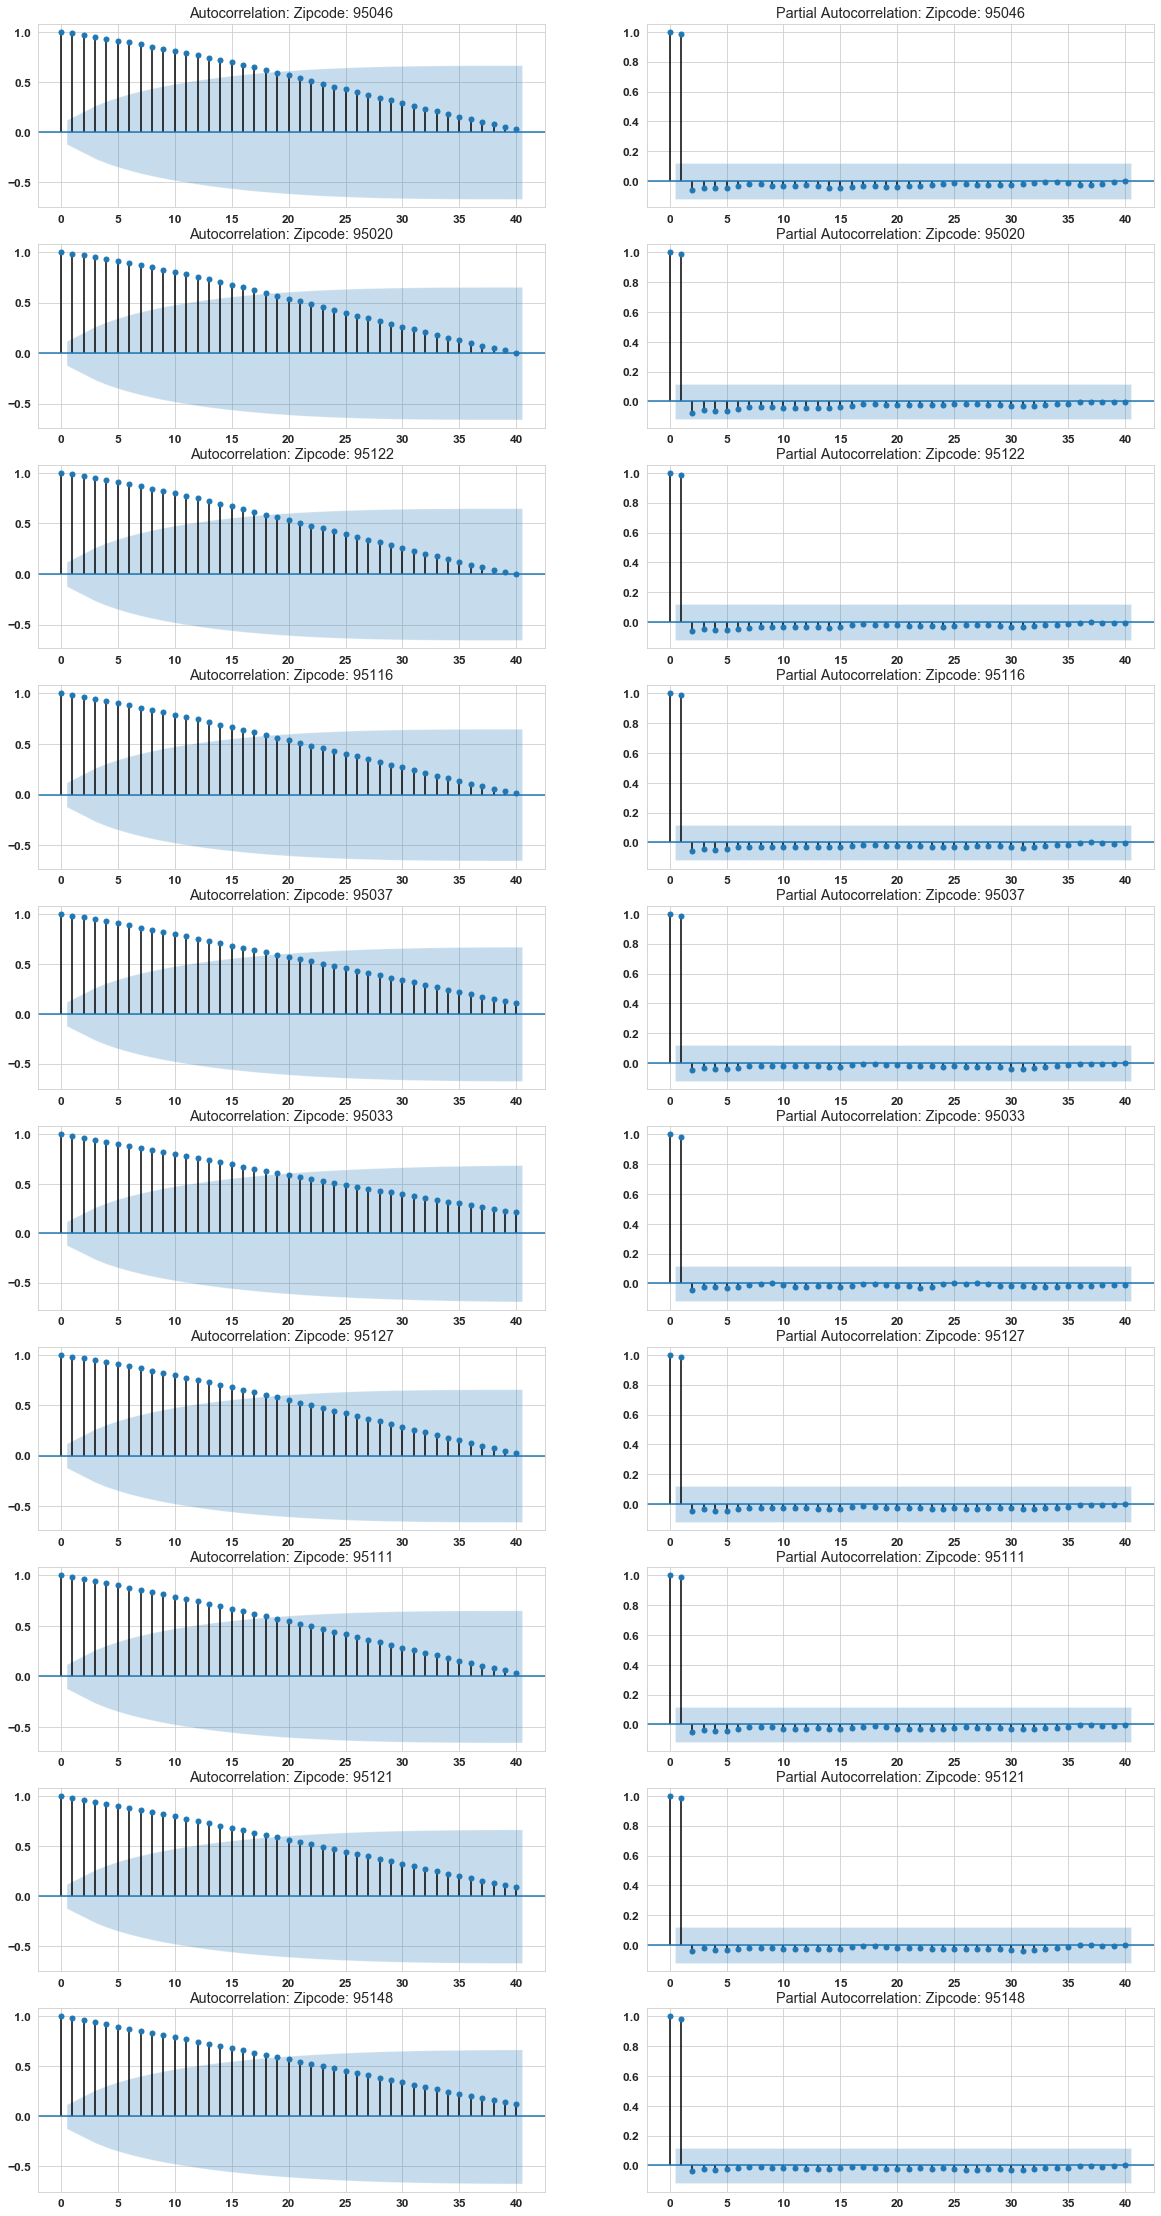

In [240]:
fig = plt.figure(figsize=(20,48))
i = 0
lags=40
for zipcode in zipcode_groups[0]:
    i += 1
    ax = plt.subplot(12,2,i)
    title = f'Autocorrelation: Zipcode: {zipcode}'
    plot_acf(melted_df.loc[melted_df['RegionName'] == zipcode].value,alpha=0.05,title=title,lags=lags,ax=ax);

    i += 1
    ax = plt.subplot(12,2,i)
    title=f'Partial Autocorrelation: Zipcode: {zipcode}'
    plot_pacf(melted_df.loc[melted_df['RegionName'] == zipcode].value,alpha=0.05,title=title,lags=lags,ax=ax);

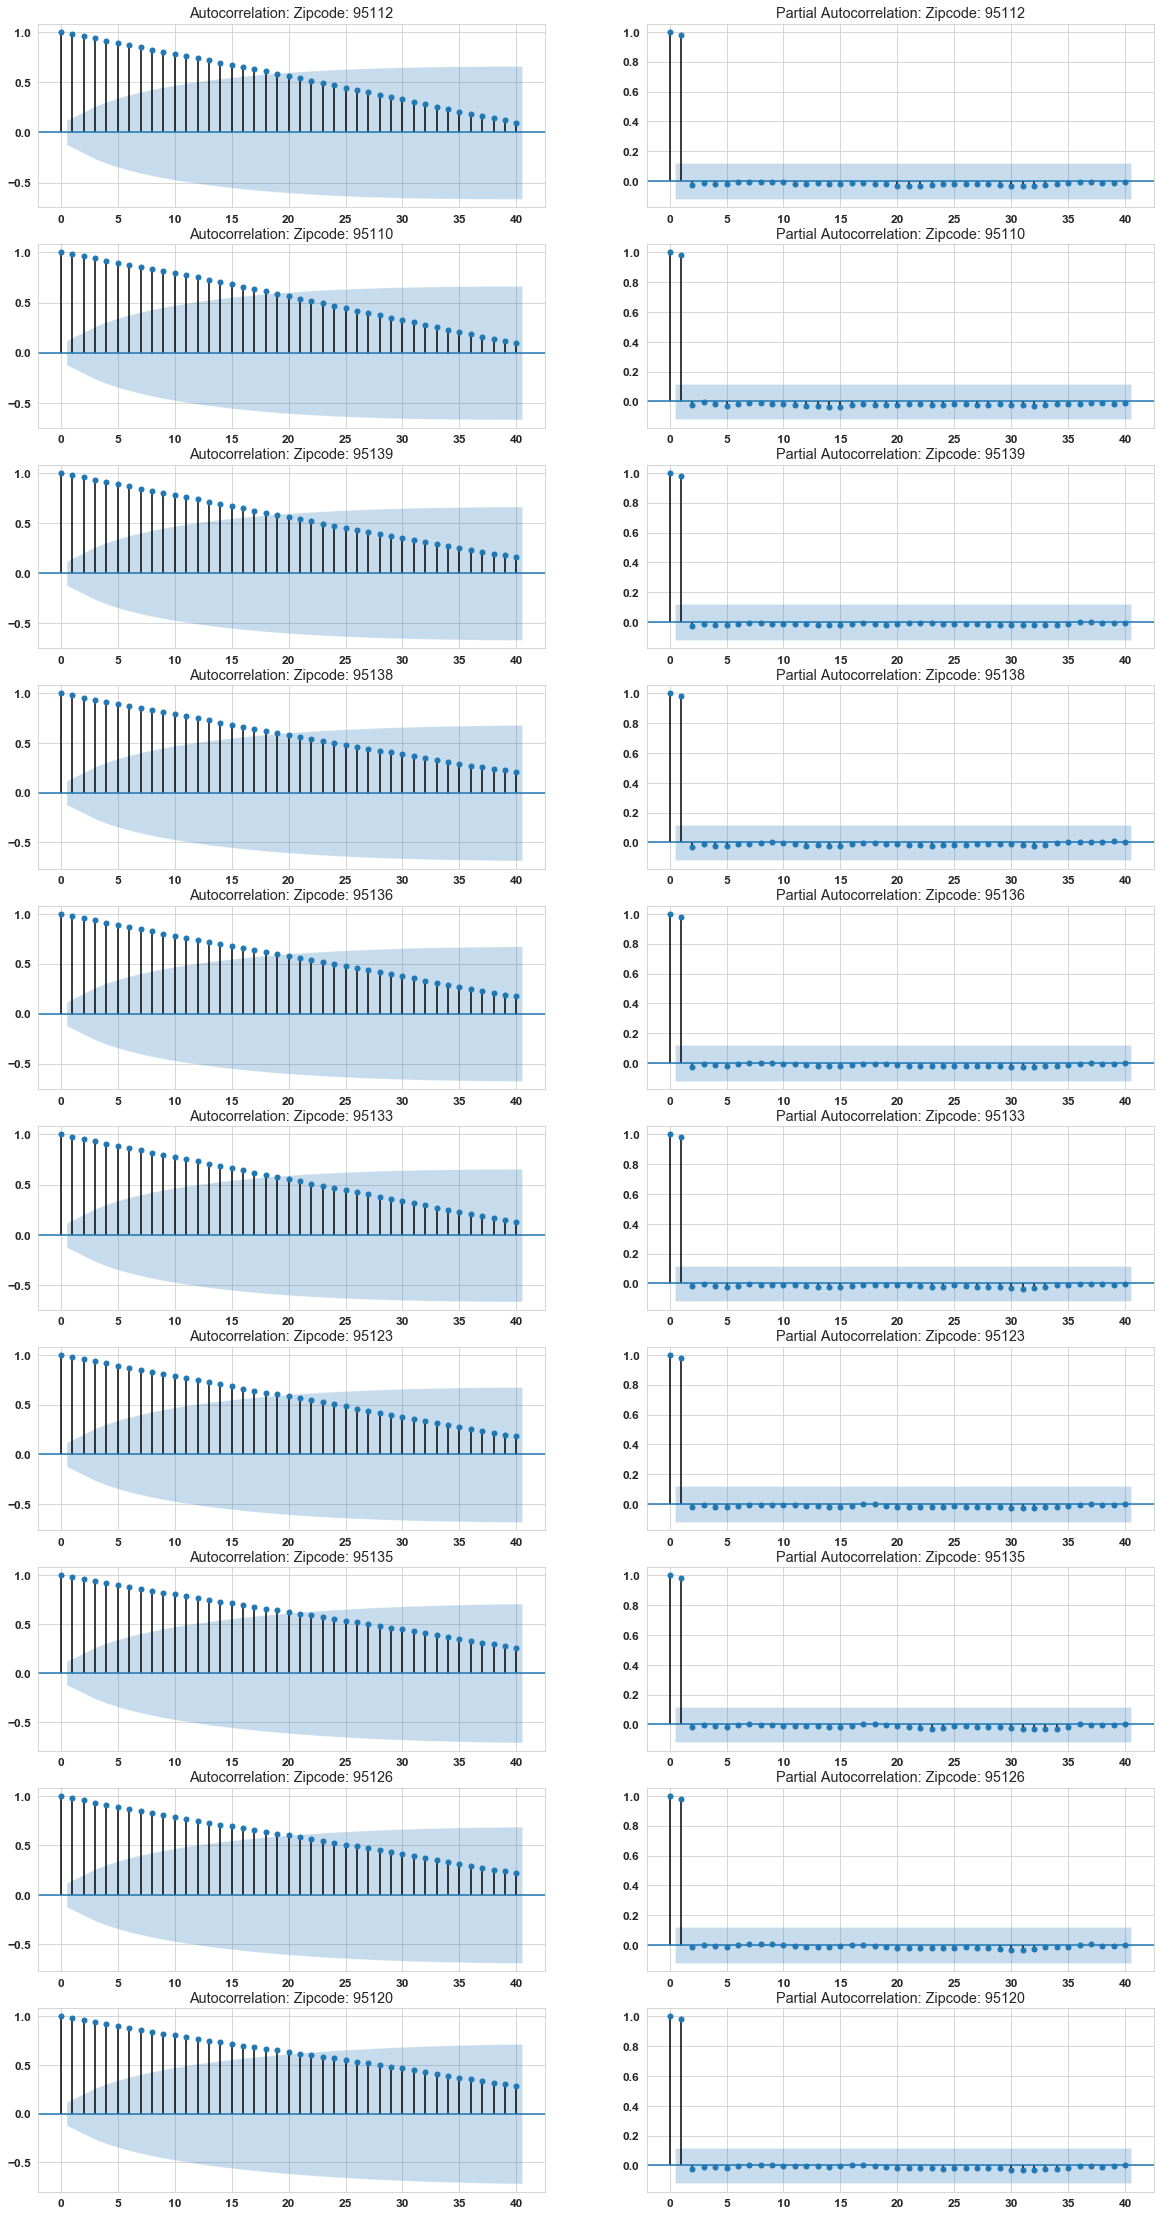

In [239]:
fig = plt.figure(figsize=(20,48))
i = 0
lags=40
for zipcode in zipcode_groups[1]:
    i += 1
    ax = plt.subplot(12,2,i)
    title = f'Autocorrelation: Zipcode: {zipcode}'
    plot_acf(melted_df.loc[melted_df['RegionName'] == zipcode].value,alpha=0.05,title=title,lags=lags,ax=ax);

    i += 1
    ax = plt.subplot(12,2,i)
    title=f'Partial Autocorrelation: Zipcode: {zipcode}'
    plot_pacf(melted_df.loc[melted_df['RegionName'] == zipcode].value,alpha=0.05,title=title,lags=lags,ax=ax);

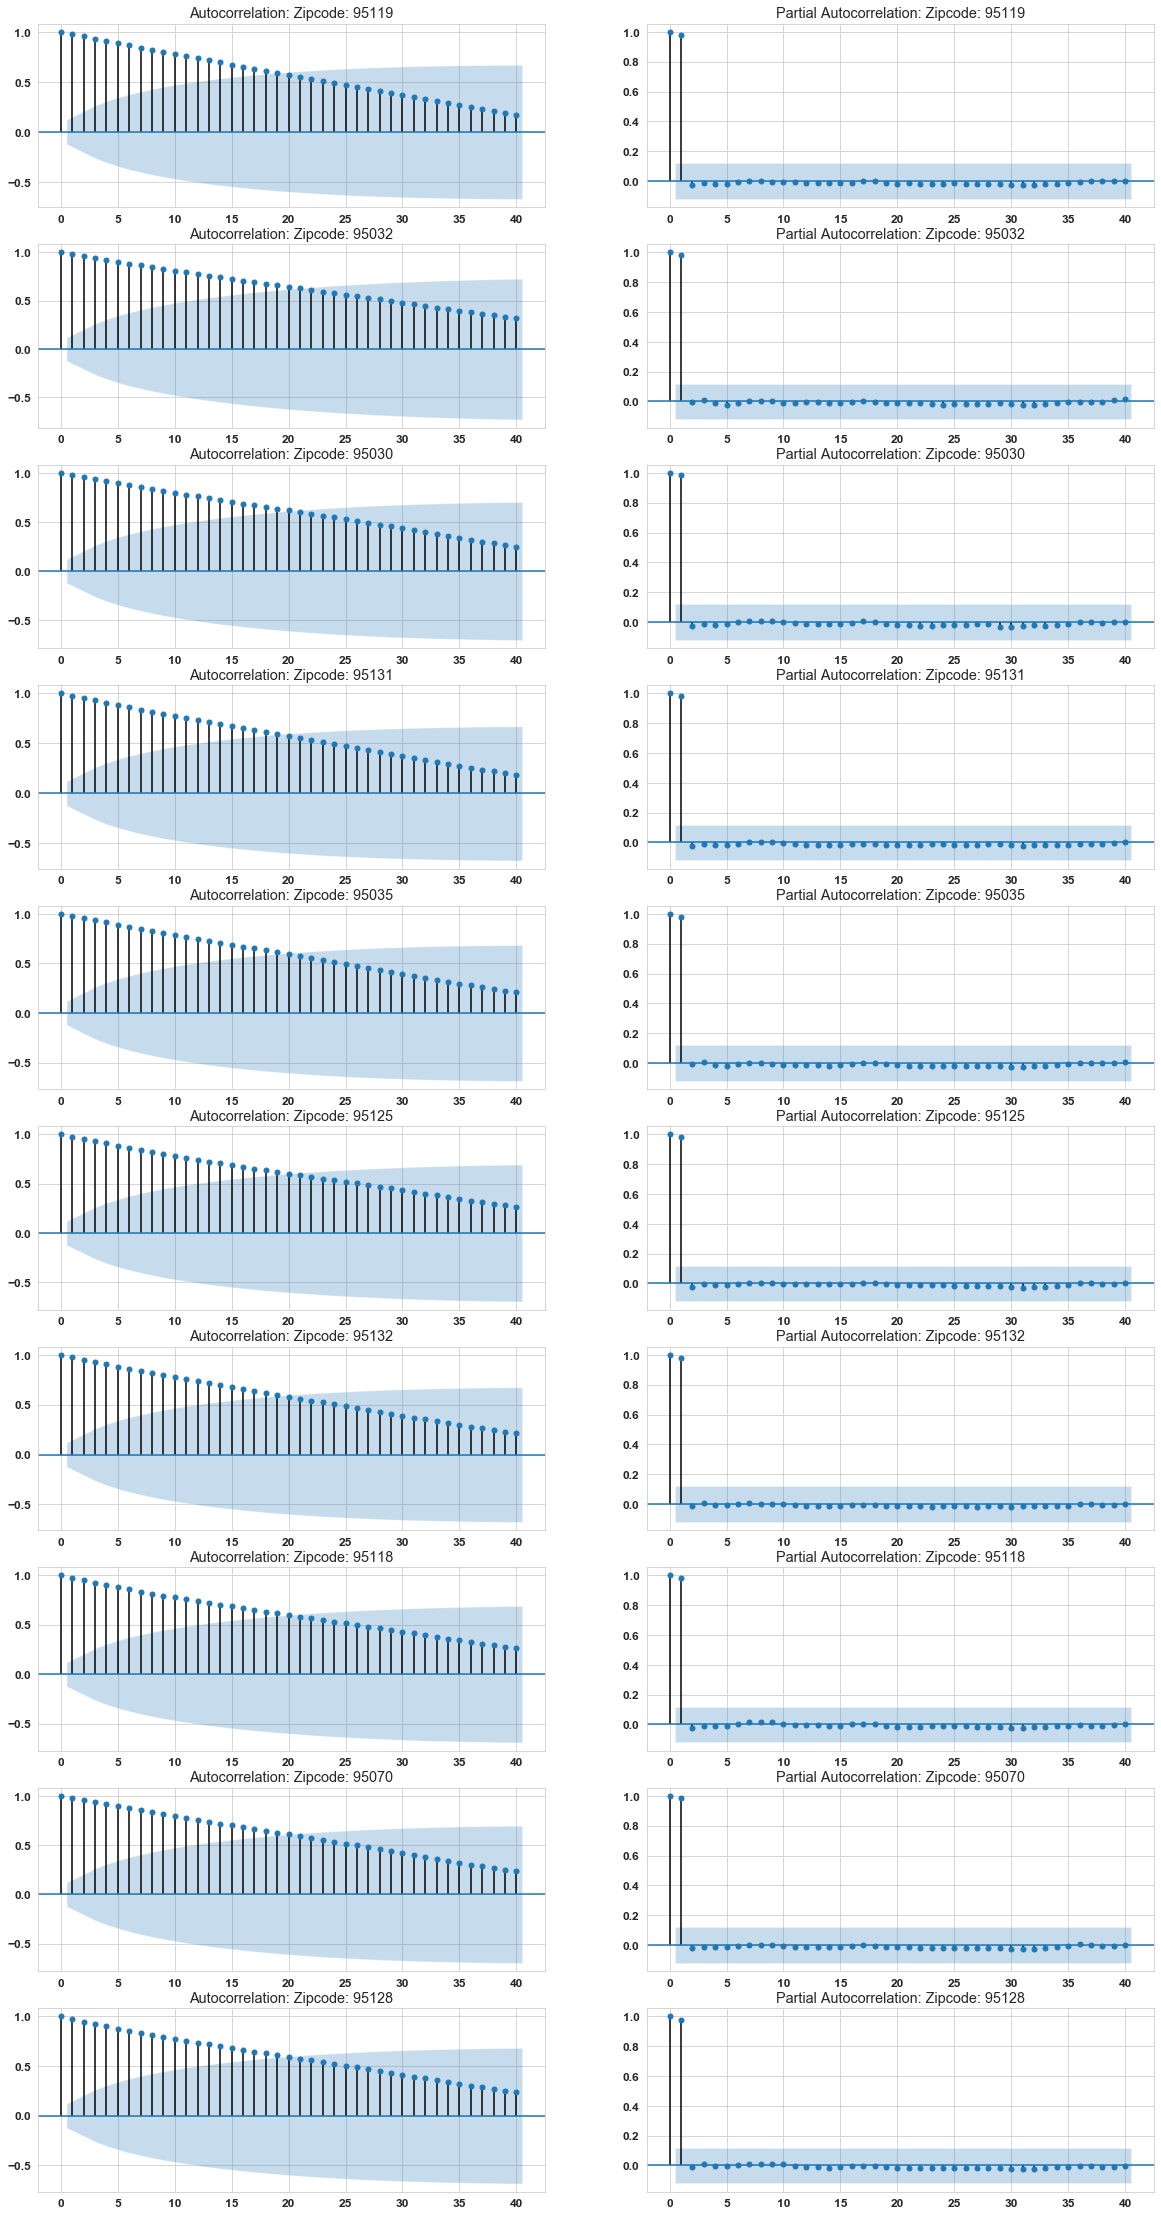

In [238]:
fig = plt.figure(figsize=(20,48))
i = 0
lags=40
for zipcode in zipcode_groups[2]:
    i += 1
    ax = plt.subplot(12,2,i)
    title = f'Autocorrelation: Zipcode: {zipcode}'
    plot_acf(melted_df.loc[melted_df['RegionName'] == zipcode].value,alpha=0.05,title=title,lags=lags,ax=ax);

    i += 1
    ax = plt.subplot(12,2,i)
    title=f'Partial Autocorrelation: Zipcode: {zipcode}'
    plot_pacf(melted_df.loc[melted_df['RegionName'] == zipcode].value,alpha=0.05,title=title,lags=lags,ax=ax);

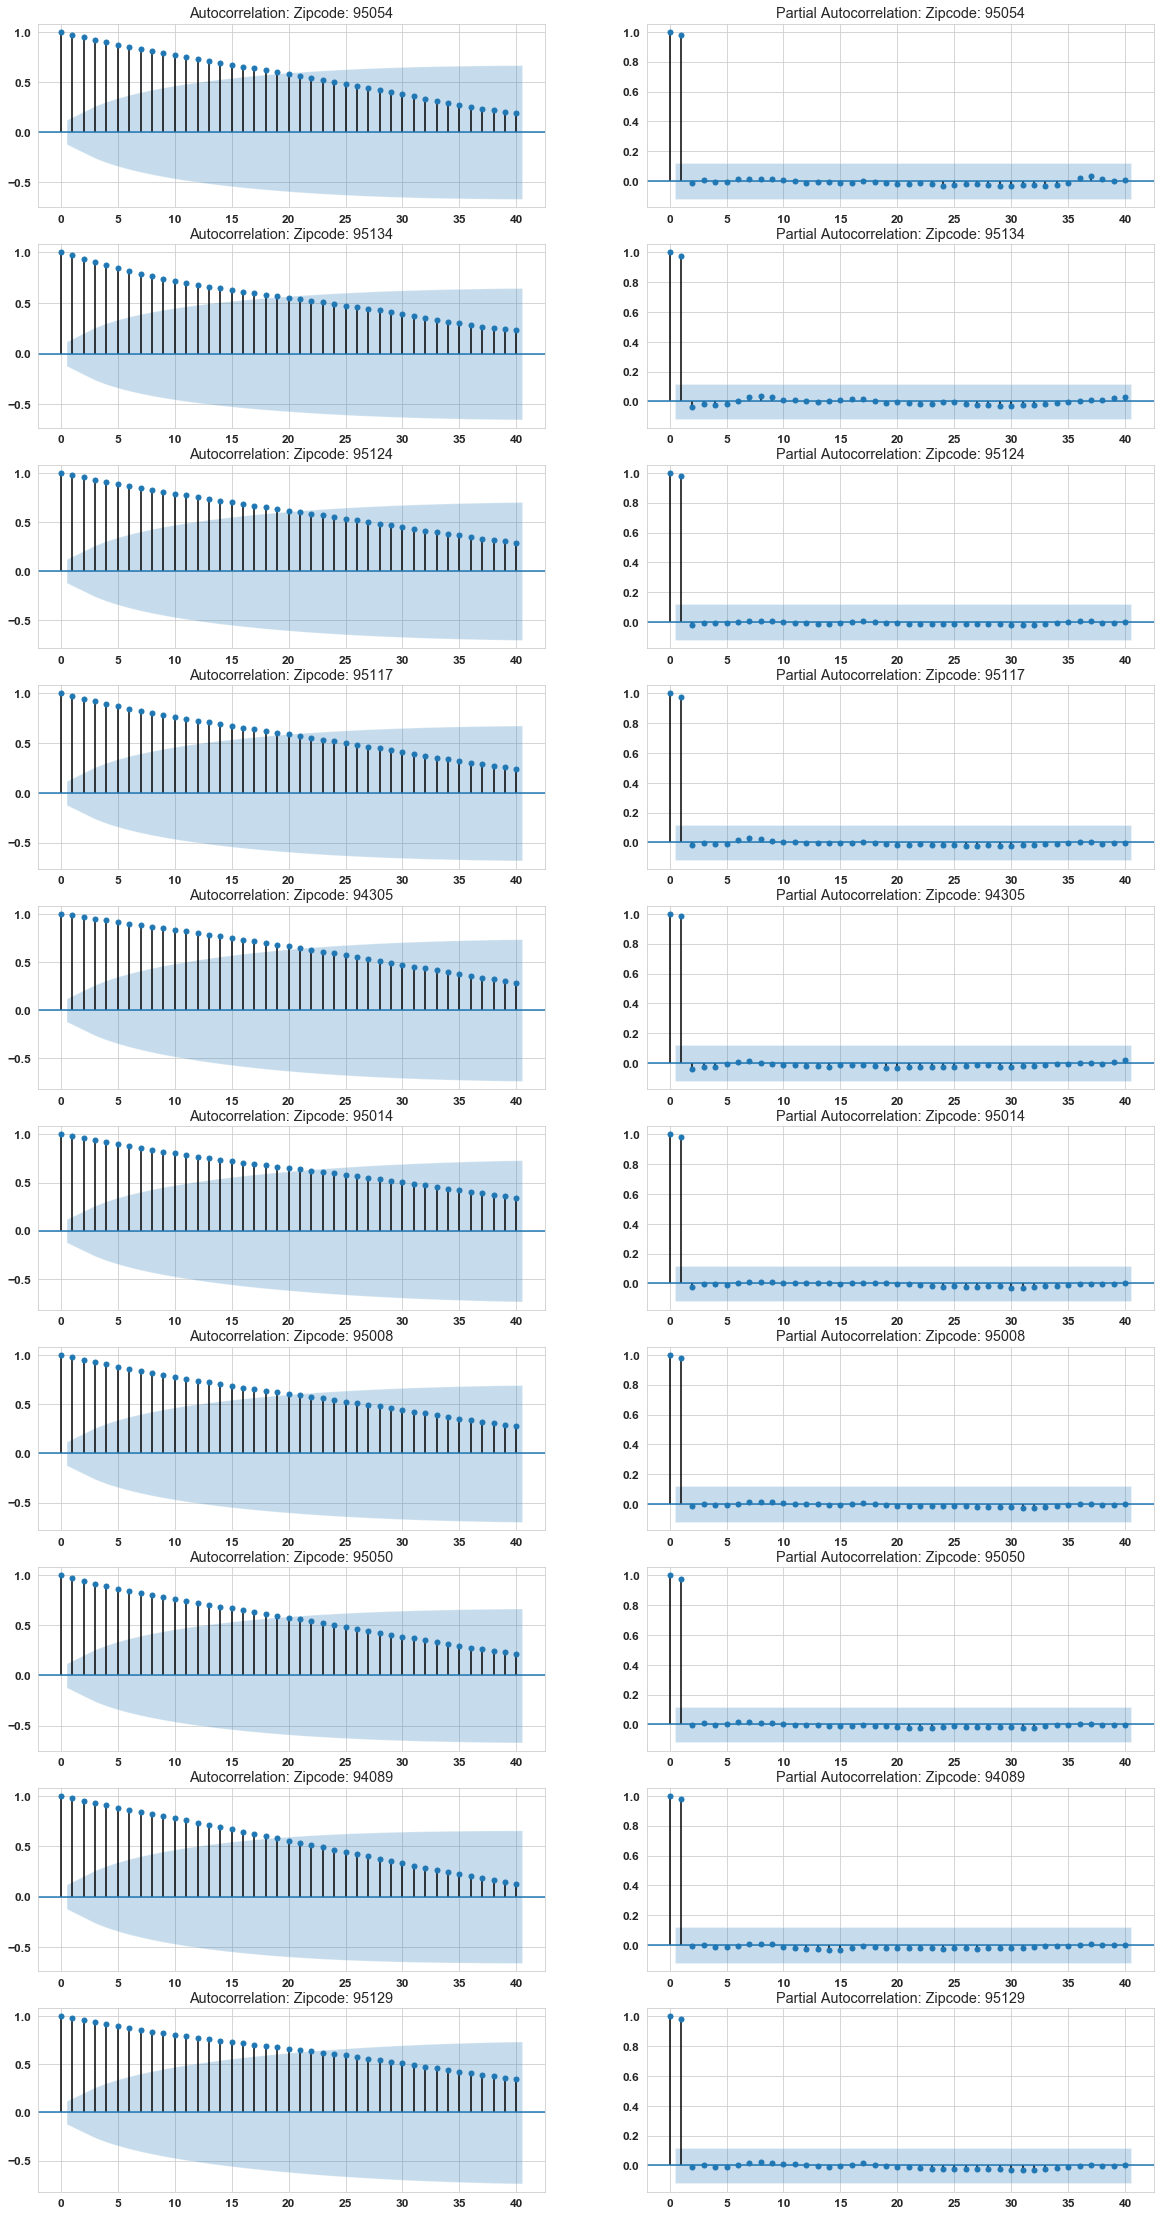

In [237]:
fig = plt.figure(figsize=(20,48))
i = 0
lags=40
for zipcode in zipcode_groups[3]:
    i += 1
    ax = plt.subplot(12,2,i)
    title = f'Autocorrelation: Zipcode: {zipcode}'
    plot_acf(melted_df.loc[melted_df['RegionName'] == zipcode].value,alpha=0.05,title=title,lags=lags,ax=ax);

    i += 1
    ax = plt.subplot(12,2,i)
    title=f'Partial Autocorrelation: Zipcode: {zipcode}'
    plot_pacf(melted_df.loc[melted_df['RegionName'] == zipcode].value,alpha=0.05,title=title,lags=lags,ax=ax);

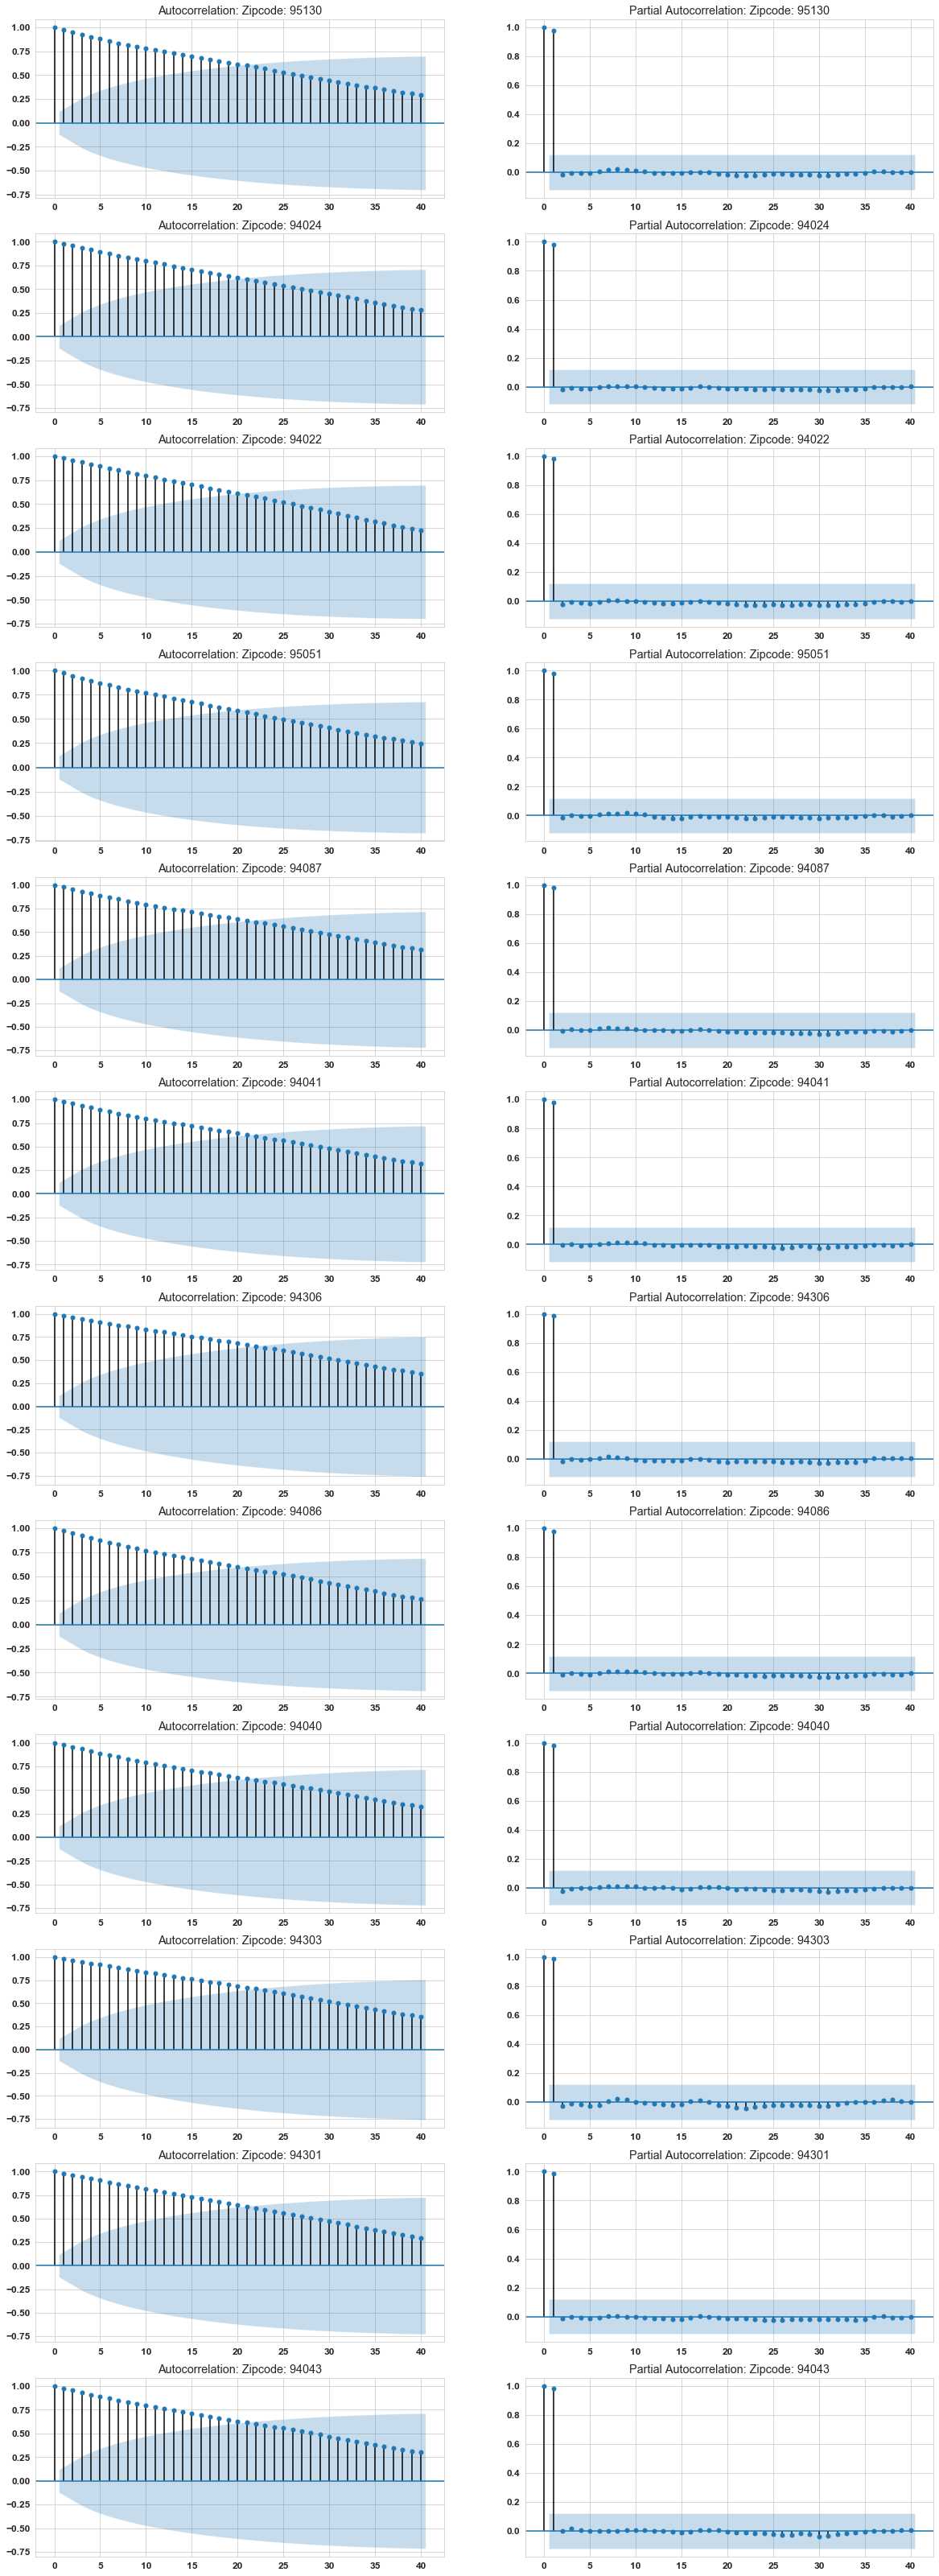

In [241]:
fig = plt.figure(figsize=(20,58))
i = 0
lags=40
for zipcode in zipcode_groups[4]:
    i += 1
    ax = plt.subplot(12,2,i)
    title = f'Autocorrelation: Zipcode: {zipcode}'
    plot_acf(melted_df.loc[melted_df['RegionName'] == zipcode].value,alpha=0.05,title=title,lags=lags,ax=ax);

    i += 1
    ax = plt.subplot(12,2,i)
    title=f'Partial Autocorrelation: Zipcode: {zipcode}'
    plot_pacf(melted_df.loc[melted_df['RegionName'] == zipcode].value,alpha=0.05,title=title,lags=lags,ax=ax);

This tells us that the AR component should be more important than MA. From the <a href='https://people.duke.edu/~rnau/411arim3.htm'>Duke University Statistical Forecasting site</a>:<br>
> <em>If the PACF displays a sharp cutoff while the ACF decays more slowly (i.e., has significant spikes at higher lags), we    say that the stationarized series displays an "AR signature," meaning that the autocorrelation pattern can be explained more    easily by adding AR terms than by adding MA terms.</em><br>

### Let's take a look at <tt>pmdarima.auto_arima</tt> done stepwise to see if it makes sense:

In [242]:
# Define the p, d and q parameters to take any value between 0 and 3
p = d = q = range(0, 4)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]


ARIMA(0, 0, 0)x(0, 0, 0, 12) - AIC:7970.6696989435195
ARIMA(0, 0, 0)x(0, 0, 1, 12) - AIC:1285753.7109607358
ARIMA(0, 0, 0)x(0, 0, 2, 12) - AIC:12862.02262343485
ARIMA(0, 0, 0)x(0, 1, 0, 12) - AIC:6579.9076966741395
ARIMA(0, 0, 0)x(0, 1, 1, 12) - AIC:6277.87073331333
ARIMA(0, 0, 0)x(0, 1, 2, 12) - AIC:5942.661379074461
ARIMA(0, 0, 0)x(0, 2, 0, 12) - AIC:6201.494104132029
ARIMA(0, 0, 0)x(0, 2, 1, 12) - AIC:5905.192813401918
ARIMA(0, 0, 0)x(0, 2, 2, 12) - AIC:5553.129470113823
ARIMA(0, 0, 0)x(1, 0, 0, 12) - AIC:6451.955985967404
ARIMA(0, 0, 0)x(1, 0, 1, 12) - AIC:6423.6382696770615
ARIMA(0, 0, 0)x(1, 0, 2, 12) - AIC:6125.241277807283
ARIMA(0, 0, 0)x(1, 1, 0, 12) - AIC:6208.229384586866
ARIMA(0, 0, 0)x(1, 1, 1, 12) - AIC:8190.33487504235
ARIMA(0, 0, 0)x(1, 1, 2, 12) - AIC:6734.829585810601
ARIMA(0, 0, 0)x(1, 2, 0, 12) - AIC:5873.281903430156
ARIMA(0, 0, 0)x(1, 2, 1, 12) - AIC:5851.212394587221
ARIMA(0, 0, 0)x(1, 2, 2, 12) - AIC:6599.163598638057
ARIMA(0, 0, 0)x(2, 0, 0, 12) - AIC:6149.3420

ARIMA(0, 1, 2)x(2, 0, 2, 12) - AIC:4839.250543648426
ARIMA(0, 1, 2)x(2, 1, 0, 12) - AIC:4589.573595466463
ARIMA(0, 1, 2)x(2, 1, 1, 12) - AIC:4589.9984739284855
ARIMA(0, 1, 2)x(2, 1, 2, 12) - AIC:4526.9907389892105
ARIMA(0, 1, 2)x(2, 2, 0, 12) - AIC:4524.9850375374
ARIMA(0, 1, 2)x(2, 2, 1, 12) - AIC:4581.114990210299
ARIMA(0, 1, 2)x(2, 2, 2, 12) - AIC:4466.340002094032
ARIMA(0, 2, 0)x(0, 0, 0, 12) - AIC:4924.5915538700865
ARIMA(0, 2, 0)x(0, 0, 1, 12) - AIC:4701.833668827634
ARIMA(0, 2, 0)x(0, 0, 2, 12) - AIC:4477.295637890187
ARIMA(0, 2, 0)x(0, 1, 0, 12) - AIC:4892.622649480475
ARIMA(0, 2, 0)x(0, 1, 1, 12) - AIC:4637.380153242224
ARIMA(0, 2, 0)x(0, 1, 2, 12) - AIC:4385.831184238712
ARIMA(0, 2, 0)x(0, 2, 0, 12) - AIC:4901.97016834728
ARIMA(0, 2, 0)x(0, 2, 1, 12) - AIC:4557.149431114774
ARIMA(0, 2, 0)x(0, 2, 2, 12) - AIC:4312.425925322919
ARIMA(0, 2, 0)x(1, 0, 0, 12) - AIC:4707.869272064356
ARIMA(0, 2, 0)x(1, 0, 1, 12) - AIC:4693.29714451592
ARIMA(0, 2, 0)x(1, 0, 2, 12) - AIC:4479.1744098

ARIMA(1, 0, 2)x(1, 1, 1, 12) - AIC:6332.273157180752
ARIMA(1, 0, 2)x(1, 1, 2, 12) - AIC:5232.337970858622
ARIMA(1, 0, 2)x(1, 2, 0, 12) - AIC:4861.4821857111365
ARIMA(1, 0, 2)x(1, 2, 1, 12) - AIC:5863.281389528658
ARIMA(1, 0, 2)x(1, 2, 2, 12) - AIC:5161.0622131444925
ARIMA(1, 0, 2)x(2, 0, 0, 12) - AIC:4722.737976079916
ARIMA(1, 0, 2)x(2, 0, 1, 12) - AIC:5591.71614534756
ARIMA(1, 0, 2)x(2, 0, 2, 12) - AIC:5629.139001637167
ARIMA(1, 0, 2)x(2, 1, 0, 12) - AIC:4594.072102768057
ARIMA(1, 0, 2)x(2, 1, 1, 12) - AIC:5729.048054515739
ARIMA(1, 0, 2)x(2, 1, 2, 12) - AIC:5335.462373959916
ARIMA(1, 0, 2)x(2, 2, 0, 12) - AIC:4601.94079102079
ARIMA(1, 0, 2)x(2, 2, 1, 12) - AIC:5216.360291747293
ARIMA(1, 0, 2)x(2, 2, 2, 12) - AIC:5250.04254378879
ARIMA(1, 1, 0)x(0, 0, 0, 12) - AIC:4943.30117661446
ARIMA(1, 1, 0)x(0, 0, 1, 12) - AIC:4717.312183072127
ARIMA(1, 1, 0)x(0, 0, 2, 12) - AIC:4496.507655440584
ARIMA(1, 1, 0)x(0, 1, 0, 12) - AIC:4905.703549626264
ARIMA(1, 1, 0)x(0, 1, 1, 12) - AIC:4650.99582465

ARIMA(1, 2, 2)x(0, 2, 0, 12) - AIC:4716.501591331515
ARIMA(1, 2, 2)x(0, 2, 1, 12) - AIC:4439.4353305555815
ARIMA(1, 2, 2)x(0, 2, 2, 12) - AIC:4123.16653927715
ARIMA(1, 2, 2)x(1, 0, 0, 12) - AIC:4572.246080038141
ARIMA(1, 2, 2)x(1, 0, 1, 12) - AIC:4536.153804821664
ARIMA(1, 2, 2)x(1, 0, 2, 12) - AIC:4323.980786149808
ARIMA(1, 2, 2)x(1, 1, 0, 12) - AIC:4531.303451143996
ARIMA(1, 2, 2)x(1, 1, 1, 12) - AIC:4463.774466771278
ARIMA(1, 2, 2)x(1, 1, 2, 12) - AIC:4221.166394638594
ARIMA(1, 2, 2)x(1, 2, 0, 12) - AIC:4445.319358881718
ARIMA(1, 2, 2)x(1, 2, 1, 12) - AIC:4386.142604774599
ARIMA(1, 2, 2)x(1, 2, 2, 12) - AIC:4145.630827141895
ARIMA(1, 2, 2)x(2, 0, 0, 12) - AIC:4357.333458679022
ARIMA(1, 2, 2)x(2, 0, 1, 12) - AIC:4358.881616150627
ARIMA(1, 2, 2)x(2, 0, 2, 12) - AIC:4324.7133563951575
ARIMA(1, 2, 2)x(2, 1, 0, 12) - AIC:4242.015805797625
ARIMA(1, 2, 2)x(2, 1, 1, 12) - AIC:4243.928934890293
ARIMA(1, 2, 2)x(2, 1, 2, 12) - AIC:4216.150362708734
ARIMA(1, 2, 2)x(2, 2, 0, 12) - AIC:4185.29636

ARIMA(2, 1, 1)x(2, 2, 2, 12) - AIC:4191.406994392053
ARIMA(2, 1, 2)x(0, 0, 0, 12) - AIC:4805.319269420709
ARIMA(2, 1, 2)x(0, 0, 1, 12) - AIC:4541.036563517126
ARIMA(2, 1, 2)x(0, 0, 2, 12) - AIC:4331.939266673992
ARIMA(2, 1, 2)x(0, 1, 0, 12) - AIC:4753.204948289147
ARIMA(2, 1, 2)x(0, 1, 1, 12) - AIC:4475.375369438007
ARIMA(2, 1, 2)x(0, 1, 2, 12) - AIC:4221.71806540835
ARIMA(2, 1, 2)x(0, 2, 0, 12) - AIC:4792.523913311637
ARIMA(2, 1, 2)x(0, 2, 1, 12) - AIC:4439.890766594541
ARIMA(2, 1, 2)x(0, 2, 2, 12) - AIC:4163.562678761042
ARIMA(2, 1, 2)x(1, 0, 0, 12) - AIC:4558.528985458495
ARIMA(2, 1, 2)x(1, 0, 1, 12) - AIC:4542.263331713999
ARIMA(2, 1, 2)x(1, 0, 2, 12) - AIC:4332.201035569106
ARIMA(2, 1, 2)x(1, 1, 0, 12) - AIC:4514.219044258428
ARIMA(2, 1, 2)x(1, 1, 1, 12) - AIC:4475.686568723917
ARIMA(2, 1, 2)x(1, 1, 2, 12) - AIC:4214.082252998525
ARIMA(2, 1, 2)x(1, 2, 0, 12) - AIC:4422.65656243221
ARIMA(2, 1, 2)x(1, 2, 1, 12) - AIC:4522.863976059295
ARIMA(2, 1, 2)x(1, 2, 2, 12) - AIC:4145.65594178

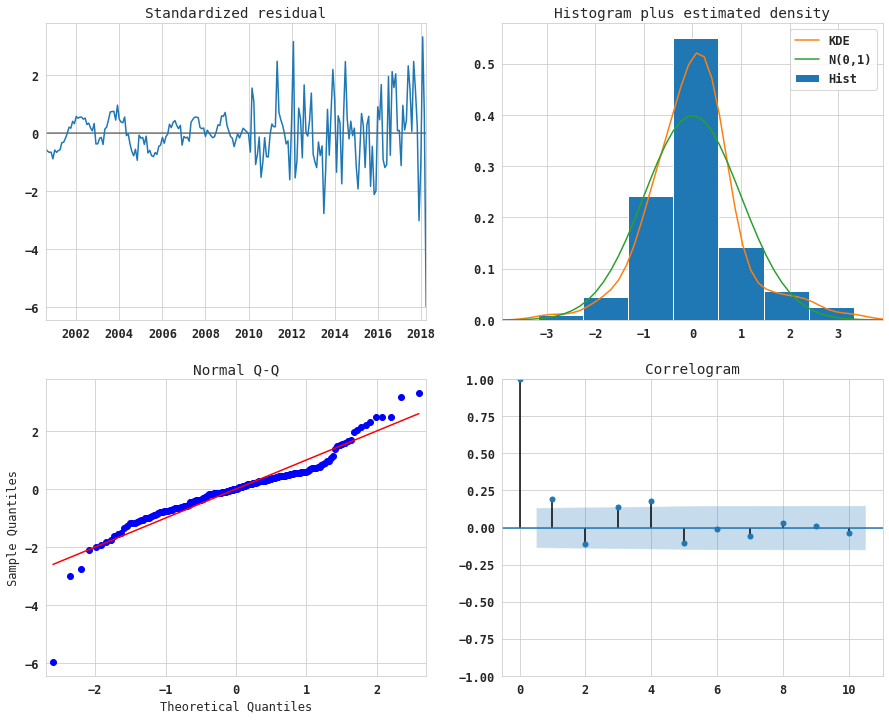

In [107]:
warnings.filterwarnings("ignore") # specify to ignore warning messages
AIC_list = pd.DataFrame({}, columns=['param','param_seasonal','AIC'])
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(melted_df.loc[melted_df['RegionName'] == 94086].value,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('ARIMA{}x{} - AIC:{}'.format(param, param_seasonal, results.aic))
            temp = pd.DataFrame([[ param ,  param_seasonal , results.aic ]], 
                                   columns=['param','param_seasonal','AIC'])
            AIC_list = AIC_list.append( temp, ignore_index=True)  
            del temp

        except:
            continue


m = np.amin(AIC_list['AIC'].values) # Find minimum value in AIC
l = AIC_list['AIC'].tolist().index(m) # Find index number for lowest AIC
Min_AIC_list = AIC_list.iloc[l,:]



mod = sm.tsa.statespace.SARIMAX(melted_df.loc[melted_df['RegionName'] == 94086].value,
                                order=Min_AIC_list['param'],
                                seasonal_order=Min_AIC_list['param_seasonal'],
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()

print("### Min_AIC_list ### \n{}".format(Min_AIC_list))

print(results.summary().tables[1])

results.plot_diagnostics(figsize=(15, 12))
plt.show()
# zipcode 94086

##### The output of our code suggests that `ARIMA(2, 2, 0)x(2, 2, 0, 12)` yields the lowest AIC value of `4089.68`. We should therefore consider this to be optimal option out of all the models we have considered for `the zipcode: 94086` .

ARIMA(0, 0, 0)x(0, 0, 0, 12) - AIC:8176.971723031418
ARIMA(0, 0, 0)x(0, 0, 1, 12) - AIC:2336236.757769518
ARIMA(0, 0, 0)x(0, 0, 2, 12) - AIC:14223.69488888585
ARIMA(0, 0, 0)x(0, 1, 0, 12) - AIC:6769.433365739958
ARIMA(0, 0, 0)x(0, 1, 1, 12) - AIC:6413.95268114174
ARIMA(0, 0, 0)x(0, 1, 2, 12) - AIC:8211.172101795113
ARIMA(0, 0, 0)x(0, 2, 0, 12) - AIC:6360.6168258745465
ARIMA(0, 0, 0)x(0, 2, 1, 12) - AIC:7948.466800760659
ARIMA(0, 0, 0)x(0, 2, 2, 12) - AIC:6926.735833712434
ARIMA(0, 0, 0)x(1, 0, 0, 12) - AIC:6611.124014338718
ARIMA(0, 0, 0)x(1, 0, 1, 12) - AIC:6581.751464298364
ARIMA(0, 0, 0)x(1, 0, 2, 12) - AIC:6277.635385847095
ARIMA(0, 0, 0)x(1, 1, 0, 12) - AIC:6371.207641428948
ARIMA(0, 0, 0)x(1, 1, 1, 12) - AIC:8525.211283996561
ARIMA(0, 0, 0)x(1, 1, 2, 12) - AIC:7400.285307516883
ARIMA(0, 0, 0)x(1, 2, 0, 12) - AIC:6033.9884300841895
ARIMA(0, 0, 0)x(1, 2, 1, 12) - AIC:6010.79475963074
ARIMA(0, 0, 0)x(1, 2, 2, 12) - AIC:6853.128247156895
ARIMA(0, 0, 0)x(2, 0, 0, 12) - AIC:6302.146302

ARIMA(0, 1, 2)x(2, 0, 2, 12) - AIC:5022.60606909183
ARIMA(0, 1, 2)x(2, 1, 0, 12) - AIC:4878.507158608238
ARIMA(0, 1, 2)x(2, 1, 1, 12) - AIC:4772.983945511853
ARIMA(0, 1, 2)x(2, 1, 2, 12) - AIC:4711.182758498764
ARIMA(0, 1, 2)x(2, 2, 0, 12) - AIC:4714.038739099271
ARIMA(0, 1, 2)x(2, 2, 1, 12) - AIC:4736.900717951008
ARIMA(0, 1, 2)x(2, 2, 2, 12) - AIC:4641.372950555931
ARIMA(0, 2, 0)x(0, 0, 0, 12) - AIC:5148.5102038713285
ARIMA(0, 2, 0)x(0, 0, 1, 12) - AIC:4909.03313470499
ARIMA(0, 2, 0)x(0, 0, 2, 12) - AIC:4676.798668380376
ARIMA(0, 2, 0)x(0, 1, 0, 12) - AIC:5131.5428927280345
ARIMA(0, 2, 0)x(0, 1, 1, 12) - AIC:4855.029283622337
ARIMA(0, 2, 0)x(0, 1, 2, 12) - AIC:4591.954317809326
ARIMA(0, 2, 0)x(0, 2, 0, 12) - AIC:5127.953507097822
ARIMA(0, 2, 0)x(0, 2, 1, 12) - AIC:4758.864780807707
ARIMA(0, 2, 0)x(0, 2, 2, 12) - AIC:4518.559704932093
ARIMA(0, 2, 0)x(1, 0, 0, 12) - AIC:4910.732180894227
ARIMA(0, 2, 0)x(1, 0, 1, 12) - AIC:4895.295717244988
ARIMA(0, 2, 0)x(1, 0, 2, 12) - AIC:4672.845139

ARIMA(1, 0, 2)x(1, 1, 1, 12) - AIC:6132.850244595349
ARIMA(1, 0, 2)x(1, 1, 2, 12) - AIC:5507.733614933077
ARIMA(1, 0, 2)x(1, 2, 0, 12) - AIC:5052.2546953070105
ARIMA(1, 0, 2)x(1, 2, 1, 12) - AIC:5926.0060601795085
ARIMA(1, 0, 2)x(1, 2, 2, 12) - AIC:5396.001648243264
ARIMA(1, 0, 2)x(2, 0, 0, 12) - AIC:4885.663098893532
ARIMA(1, 0, 2)x(2, 0, 1, 12) - AIC:5812.587638864326
ARIMA(1, 0, 2)x(2, 0, 2, 12) - AIC:5496.918514360421
ARIMA(1, 0, 2)x(2, 1, 0, 12) - AIC:4766.2862353806195
ARIMA(1, 0, 2)x(2, 1, 1, 12) - AIC:5789.633185440627
ARIMA(1, 0, 2)x(2, 1, 2, 12) - AIC:5476.229114113097
ARIMA(1, 0, 2)x(2, 2, 0, 12) - AIC:4769.314644243284
ARIMA(1, 0, 2)x(2, 2, 1, 12) - AIC:5588.267398966735
ARIMA(1, 0, 2)x(2, 2, 2, 12) - AIC:5334.989674921619
ARIMA(1, 1, 0)x(0, 0, 0, 12) - AIC:5164.954604622309
ARIMA(1, 1, 0)x(0, 0, 1, 12) - AIC:4921.817161631483
ARIMA(1, 1, 0)x(0, 0, 2, 12) - AIC:4686.083284813558
ARIMA(1, 1, 0)x(0, 1, 0, 12) - AIC:5140.200187427863
ARIMA(1, 1, 0)x(0, 1, 1, 12) - AIC:4868.423

ARIMA(1, 2, 2)x(0, 2, 0, 12) - AIC:5001.137439347439
ARIMA(1, 2, 2)x(0, 2, 1, 12) - AIC:4657.703699211187
ARIMA(1, 2, 2)x(0, 2, 2, 12) - AIC:4395.902813896454
ARIMA(1, 2, 2)x(1, 0, 0, 12) - AIC:4845.42770146444
ARIMA(1, 2, 2)x(1, 0, 1, 12) - AIC:4775.672632815391
ARIMA(1, 2, 2)x(1, 0, 2, 12) - AIC:4558.329567285799
ARIMA(1, 2, 2)x(1, 1, 0, 12) - AIC:4834.395838316919
ARIMA(1, 2, 2)x(1, 1, 1, 12) - AIC:4793.556744410353
ARIMA(1, 2, 2)x(1, 1, 2, 12) - AIC:4501.460015838198
ARIMA(1, 2, 2)x(1, 2, 0, 12) - AIC:4709.219056459756
ARIMA(1, 2, 2)x(1, 2, 1, 12) - AIC:4626.788208261188
ARIMA(1, 2, 2)x(1, 2, 2, 12) - AIC:4380.459572952552
ARIMA(1, 2, 2)x(2, 0, 0, 12) - AIC:4592.092051471987
ARIMA(1, 2, 2)x(2, 0, 1, 12) - AIC:4596.587603263538
ARIMA(1, 2, 2)x(2, 0, 2, 12) - AIC:4560.295817449283
ARIMA(1, 2, 2)x(2, 1, 0, 12) - AIC:4499.847241014149
ARIMA(1, 2, 2)x(2, 1, 1, 12) - AIC:4493.328581453978
ARIMA(1, 2, 2)x(2, 1, 2, 12) - AIC:4501.970316490802
ARIMA(1, 2, 2)x(2, 2, 0, 12) - AIC:4433.1261358

ARIMA(2, 1, 1)x(2, 2, 2, 12) - AIC:4450.1067997698465
ARIMA(2, 1, 2)x(0, 0, 0, 12) - AIC:5087.617126559264
ARIMA(2, 1, 2)x(0, 0, 1, 12) - AIC:4769.699170958313
ARIMA(2, 1, 2)x(0, 0, 2, 12) - AIC:4536.575357762321
ARIMA(2, 1, 2)x(0, 1, 0, 12) - AIC:5072.735273986549
ARIMA(2, 1, 2)x(0, 1, 1, 12) - AIC:4768.856981397986
ARIMA(2, 1, 2)x(0, 1, 2, 12) - AIC:4451.940921267965
ARIMA(2, 1, 2)x(0, 2, 0, 12) - AIC:5035.219422375988
ARIMA(2, 1, 2)x(0, 2, 1, 12) - AIC:4660.938774632801
ARIMA(2, 1, 2)x(0, 2, 2, 12) - AIC:4401.438310620046
ARIMA(2, 1, 2)x(1, 0, 0, 12) - AIC:4801.887056561609
ARIMA(2, 1, 2)x(1, 0, 1, 12) - AIC:4770.769310477592
ARIMA(2, 1, 2)x(1, 0, 2, 12) - AIC:4537.639247944626
ARIMA(2, 1, 2)x(1, 1, 0, 12) - AIC:4751.407180855543
ARIMA(2, 1, 2)x(1, 1, 1, 12) - AIC:4724.546324752038
ARIMA(2, 1, 2)x(1, 1, 2, 12) - AIC:4465.596067939705
ARIMA(2, 1, 2)x(1, 2, 0, 12) - AIC:4688.483071785895
ARIMA(2, 1, 2)x(1, 2, 1, 12) - AIC:4661.079029563584
ARIMA(2, 1, 2)x(1, 2, 2, 12) - AIC:4383.50728

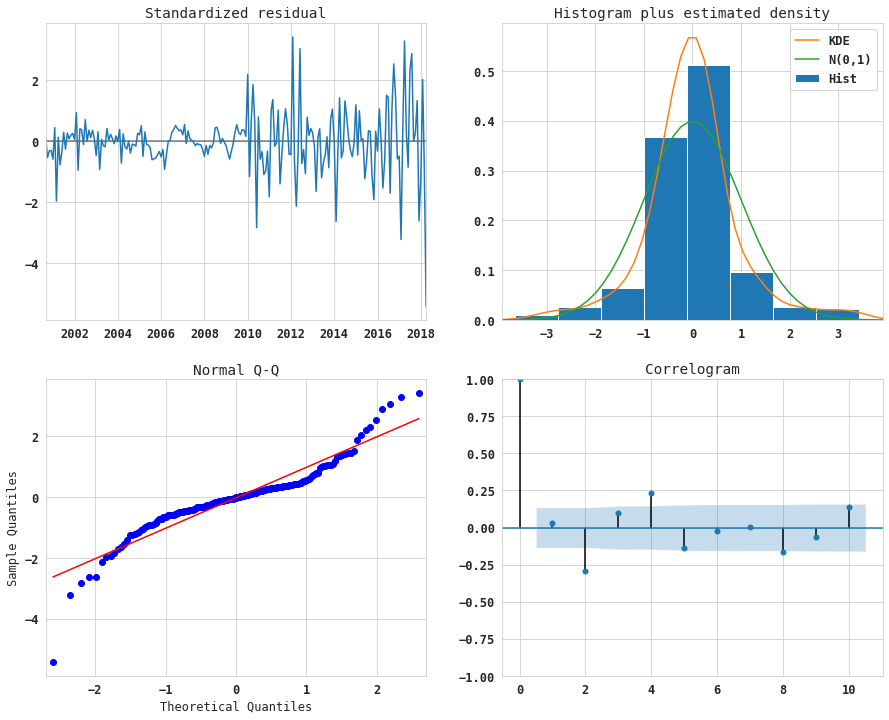

In [109]:
warnings.filterwarnings("ignore") # specify to ignore warning messages
AIC_list = pd.DataFrame({}, columns=['param','param_seasonal','AIC'])
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(melted_df.loc[melted_df['RegionName'] == 94040].value,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('ARIMA{}x{} - AIC:{}'.format(param, param_seasonal, results.aic))
            temp = pd.DataFrame([[ param ,  param_seasonal , results.aic ]], 
                                   columns=['param','param_seasonal','AIC'])
            AIC_list = AIC_list.append( temp, ignore_index=True)  
            del temp

        except:
            continue


m = np.amin(AIC_list['AIC'].values) # Find minimum value in AIC
l = AIC_list['AIC'].tolist().index(m) # Find index number for lowest AIC
Min_AIC_list = AIC_list.iloc[l,:]



mod = sm.tsa.statespace.SARIMAX(melted_df.loc[melted_df['RegionName'] == 94040].value,
                                order=Min_AIC_list['param'],
                                seasonal_order=Min_AIC_list['param_seasonal'],
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()

print("### Min_AIC_list ### \n{}".format(Min_AIC_list))

print(results.summary().tables[1])

results.plot_diagnostics(figsize=(15, 12))
plt.show()
# zipcode 94040

##### The output of our code suggests that `ARIMA(0,  2,  2)x(1,  2,  2, 12)` yields the lowest AIC value of `4302.12`. We should therefore consider this to be optimal option out of all the models we have considered for `the zipcode: 94040`

ARIMA(0, 0, 0)x(0, 0, 0, 12) - AIC:8181.982664434927
ARIMA(0, 0, 0)x(0, 0, 1, 12) - AIC:7662.543951885524
ARIMA(0, 0, 0)x(0, 0, 2, 12) - AIC:7289.550156717973
ARIMA(0, 0, 0)x(0, 1, 0, 12) - AIC:6766.189079651065
ARIMA(0, 0, 0)x(0, 1, 1, 12) - AIC:747112.630555791
ARIMA(0, 0, 0)x(0, 1, 2, 12) - AIC:8162.838714278669
ARIMA(0, 0, 0)x(0, 2, 0, 12) - AIC:6379.677566757752
ARIMA(0, 0, 0)x(0, 2, 1, 12) - AIC:7948.91293086724
ARIMA(0, 0, 0)x(0, 2, 2, 12) - AIC:6901.966600074067
ARIMA(0, 0, 0)x(1, 0, 0, 12) - AIC:6607.910509409394
ARIMA(0, 0, 0)x(1, 0, 1, 12) - AIC:6580.273648649247
ARIMA(0, 0, 0)x(1, 0, 2, 12) - AIC:6277.751524471271
ARIMA(0, 0, 0)x(1, 1, 0, 12) - AIC:6368.765850400441
ARIMA(0, 0, 0)x(1, 1, 1, 12) - AIC:8571.1490118631
ARIMA(0, 0, 0)x(1, 1, 2, 12) - AIC:7966.575133424112
ARIMA(0, 0, 0)x(1, 2, 0, 12) - AIC:6039.217710504312
ARIMA(0, 0, 0)x(1, 2, 1, 12) - AIC:7836.820428174209
ARIMA(0, 0, 0)x(1, 2, 2, 12) - AIC:6817.8895547291995
ARIMA(0, 0, 0)x(2, 0, 0, 12) - AIC:6302.591226552

ARIMA(0, 1, 2)x(2, 0, 2, 12) - AIC:4961.166249811684
ARIMA(0, 1, 2)x(2, 1, 0, 12) - AIC:4740.179777595862
ARIMA(0, 1, 2)x(2, 1, 1, 12) - AIC:4742.076026258754
ARIMA(0, 1, 2)x(2, 1, 2, 12) - AIC:4676.1400761603345
ARIMA(0, 1, 2)x(2, 2, 0, 12) - AIC:4710.83190108865
ARIMA(0, 1, 2)x(2, 2, 1, 12) - AIC:4712.313997643496
ARIMA(0, 1, 2)x(2, 2, 2, 12) - AIC:4639.724513374162
ARIMA(0, 2, 0)x(0, 0, 0, 12) - AIC:5369.217936422845
ARIMA(0, 2, 0)x(0, 0, 1, 12) - AIC:5119.217756186249
ARIMA(0, 2, 0)x(0, 0, 2, 12) - AIC:4885.0954426497865
ARIMA(0, 2, 0)x(0, 1, 0, 12) - AIC:5315.269316194841
ARIMA(0, 2, 0)x(0, 1, 1, 12) - AIC:5028.132507875474
ARIMA(0, 2, 0)x(0, 1, 2, 12) - AIC:4767.022476339276
ARIMA(0, 2, 0)x(0, 2, 0, 12) - AIC:5271.501636250136
ARIMA(0, 2, 0)x(0, 2, 1, 12) - AIC:4910.604126980374
ARIMA(0, 2, 0)x(0, 2, 2, 12) - AIC:4644.1924634570205
ARIMA(0, 2, 0)x(1, 0, 0, 12) - AIC:5135.858706601799
ARIMA(0, 2, 0)x(1, 0, 1, 12) - AIC:5117.593666954489
ARIMA(0, 2, 0)x(1, 0, 2, 12) - AIC:4883.1325

ARIMA(1, 0, 2)x(1, 1, 1, 12) - AIC:6459.348137418057
ARIMA(1, 0, 2)x(1, 1, 2, 12) - AIC:5494.910600481481
ARIMA(1, 0, 2)x(1, 2, 0, 12) - AIC:5133.160187582465
ARIMA(1, 0, 2)x(1, 2, 1, 12) - AIC:6240.302086046227
ARIMA(1, 0, 2)x(1, 2, 2, 12) - AIC:5578.273707864013
ARIMA(1, 0, 2)x(2, 0, 0, 12) - AIC:4851.062665657366
ARIMA(1, 0, 2)x(2, 0, 1, 12) - AIC:4876.518677246313
ARIMA(1, 0, 2)x(2, 0, 2, 12) - AIC:5738.4331383172
ARIMA(1, 0, 2)x(2, 1, 0, 12) - AIC:4774.127899529735
ARIMA(1, 0, 2)x(2, 1, 1, 12) - AIC:6019.853728811082
ARIMA(1, 0, 2)x(2, 1, 2, 12) - AIC:5675.6894061155745
ARIMA(1, 0, 2)x(2, 2, 0, 12) - AIC:4805.900756510753
ARIMA(1, 0, 2)x(2, 2, 1, 12) - AIC:5542.258952708002
ARIMA(1, 0, 2)x(2, 2, 2, 12) - AIC:5568.927190637685
ARIMA(1, 1, 0)x(0, 0, 0, 12) - AIC:5380.1251399910625
ARIMA(1, 1, 0)x(0, 0, 1, 12) - AIC:5129.5291580951525
ARIMA(1, 1, 0)x(0, 0, 2, 12) - AIC:4889.6452644087385
ARIMA(1, 1, 0)x(0, 1, 0, 12) - AIC:5320.189215578128
ARIMA(1, 1, 0)x(0, 1, 1, 12) - AIC:5038.8240

ARIMA(1, 2, 2)x(0, 2, 0, 12) - AIC:5173.600982784831
ARIMA(1, 2, 2)x(0, 2, 1, 12) - AIC:4760.916434434895
ARIMA(1, 2, 2)x(0, 2, 2, 12) - AIC:4467.978976071399
ARIMA(1, 2, 2)x(1, 0, 0, 12) - AIC:4919.710358493084
ARIMA(1, 2, 2)x(1, 0, 1, 12) - AIC:4955.754688300024
ARIMA(1, 2, 2)x(1, 0, 2, 12) - AIC:4711.7532417256025
ARIMA(1, 2, 2)x(1, 1, 0, 12) - AIC:4931.211368338736
ARIMA(1, 2, 2)x(1, 1, 1, 12) - AIC:4819.8311217523205
ARIMA(1, 2, 2)x(1, 1, 2, 12) - AIC:4577.853220490392
ARIMA(1, 2, 2)x(1, 2, 0, 12) - AIC:4832.448890109287
ARIMA(1, 2, 2)x(1, 2, 1, 12) - AIC:4712.885065986037
ARIMA(1, 2, 2)x(1, 2, 2, 12) - AIC:4500.251544945296
ARIMA(1, 2, 2)x(2, 0, 0, 12) - AIC:4732.097326176991
ARIMA(1, 2, 2)x(2, 0, 1, 12) - AIC:4753.729791049585
ARIMA(1, 2, 2)x(2, 0, 2, 12) - AIC:4713.748562805516
ARIMA(1, 2, 2)x(2, 1, 0, 12) - AIC:4648.108171478518
ARIMA(1, 2, 2)x(2, 1, 1, 12) - AIC:4649.922763945732
ARIMA(1, 2, 2)x(2, 1, 2, 12) - AIC:4609.885672417677
ARIMA(1, 2, 2)x(2, 2, 0, 12) - AIC:4531.6601

ARIMA(2, 1, 1)x(2, 2, 2, 12) - AIC:4492.163264642001
ARIMA(2, 1, 2)x(0, 0, 0, 12) - AIC:5147.278058818829
ARIMA(2, 1, 2)x(0, 0, 1, 12) - AIC:4856.041812853919
ARIMA(2, 1, 2)x(0, 0, 2, 12) - AIC:4627.112128767248
ARIMA(2, 1, 2)x(0, 1, 0, 12) - AIC:5093.639604681106
ARIMA(2, 1, 2)x(0, 1, 1, 12) - AIC:4797.093576634832
ARIMA(2, 1, 2)x(0, 1, 2, 12) - AIC:4502.959112844917
ARIMA(2, 1, 2)x(0, 2, 0, 12) - AIC:5060.75991666576
ARIMA(2, 1, 2)x(0, 2, 1, 12) - AIC:4700.594996223985
ARIMA(2, 1, 2)x(0, 2, 2, 12) - AIC:4446.744240461553
ARIMA(2, 1, 2)x(1, 0, 0, 12) - AIC:4879.460432167688
ARIMA(2, 1, 2)x(1, 0, 1, 12) - AIC:4948.01326715162
ARIMA(2, 1, 2)x(1, 0, 2, 12) - AIC:4627.689956215708
ARIMA(2, 1, 2)x(1, 1, 0, 12) - AIC:4823.403464722967
ARIMA(2, 1, 2)x(1, 1, 1, 12) - AIC:4796.593938014078
ARIMA(2, 1, 2)x(1, 1, 2, 12) - AIC:4503.651882363865
ARIMA(2, 1, 2)x(1, 2, 0, 12) - AIC:4779.259827081392
ARIMA(2, 1, 2)x(1, 2, 1, 12) - AIC:4690.187446003025
ARIMA(2, 1, 2)x(1, 2, 2, 12) - AIC:4456.74155834

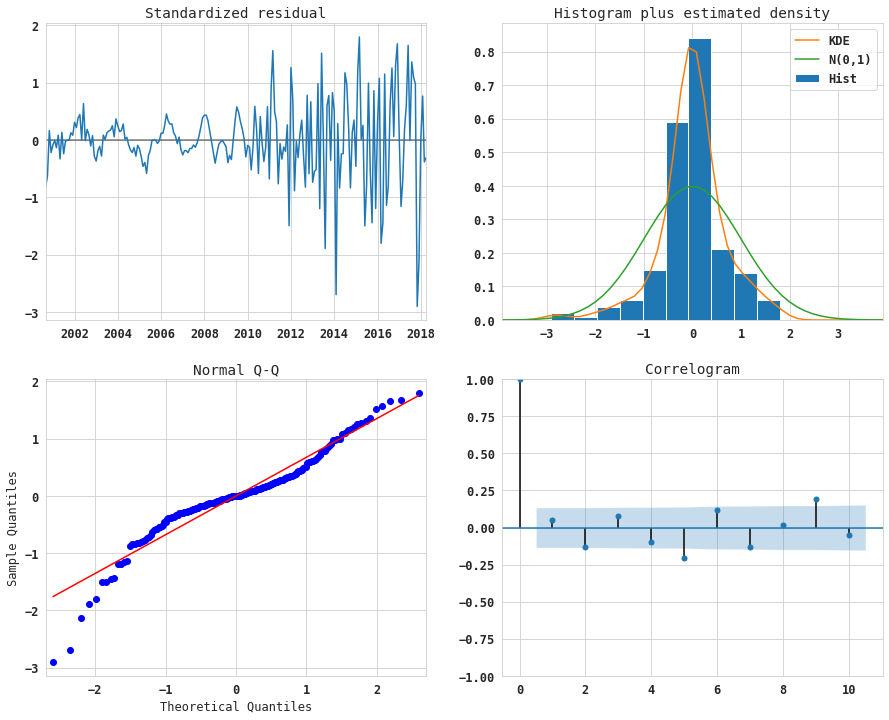

In [110]:
warnings.filterwarnings("ignore") # specify to ignore warning messages
AIC_list = pd.DataFrame({}, columns=['param','param_seasonal','AIC'])
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(melted_df.loc[melted_df['RegionName'] == 94303].value,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('ARIMA{}x{} - AIC:{}'.format(param, param_seasonal, results.aic))
            temp = pd.DataFrame([[ param ,  param_seasonal , results.aic ]], 
                                   columns=['param','param_seasonal','AIC'])
            AIC_list = AIC_list.append( temp, ignore_index=True)  
            del temp

        except:
            continue


m = np.amin(AIC_list['AIC'].values) # Find minimum value in AIC
l = AIC_list['AIC'].tolist().index(m) # Find index number for lowest AIC
Min_AIC_list = AIC_list.iloc[l,:]



mod = sm.tsa.statespace.SARIMAX(melted_df.loc[melted_df['RegionName'] == 94303].value,
                                order=Min_AIC_list['param'],
                                seasonal_order=Min_AIC_list['param_seasonal'],
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()

print("### Min_AIC_list ### \n{}".format(Min_AIC_list))

print(results.summary().tables[1])

results.plot_diagnostics(figsize=(15, 12))
plt.show()
# zip code 94303

##### The output of our code suggests that `ARIMA(2,  2,  2)x(2,  2,  2, 12)` yields the lowest AIC value of `4422.5`. We should therefore consider this to be optimal option out of all the models we have considered for `the zipcode: 94303`

ARIMA(0, 0, 0)x(0, 0, 0, 12) - AIC:8486.514325674287
ARIMA(0, 0, 0)x(0, 0, 1, 12) - AIC:6765723.186049002
ARIMA(0, 0, 0)x(0, 0, 2, 12) - AIC:7560.564048964027
ARIMA(0, 0, 0)x(0, 1, 0, 12) - AIC:7045.915507121631
ARIMA(0, 0, 0)x(0, 1, 1, 12) - AIC:2607076.983740493
ARIMA(0, 0, 0)x(0, 1, 2, 12) - AIC:8684.70084504503
ARIMA(0, 0, 0)x(0, 2, 0, 12) - AIC:6561.162887551122
ARIMA(0, 0, 0)x(0, 2, 1, 12) - AIC:8330.70614503456
ARIMA(0, 0, 0)x(0, 2, 2, 12) - AIC:7212.874868382751
ARIMA(0, 0, 0)x(1, 0, 0, 12) - AIC:6915.473870053042
ARIMA(0, 0, 0)x(1, 0, 1, 12) - AIC:6851.074523274966
ARIMA(0, 0, 0)x(1, 0, 2, 12) - AIC:6521.632567618203
ARIMA(0, 0, 0)x(1, 1, 0, 12) - AIC:6569.781331878008
ARIMA(0, 0, 0)x(1, 1, 1, 12) - AIC:9118.667941226933
ARIMA(0, 0, 0)x(1, 1, 2, 12) - AIC:7783.630549941161
ARIMA(0, 0, 0)x(1, 2, 0, 12) - AIC:6263.334280832529
ARIMA(0, 0, 0)x(1, 2, 1, 12) - AIC:8311.222952745247
ARIMA(0, 0, 0)x(1, 2, 2, 12) - AIC:7195.729909880186
ARIMA(0, 0, 0)x(2, 0, 0, 12) - AIC:6539.08361100

ARIMA(0, 1, 2)x(2, 0, 2, 12) - AIC:5240.294071997951
ARIMA(0, 1, 2)x(2, 1, 0, 12) - AIC:4922.005680431634
ARIMA(0, 1, 2)x(2, 1, 1, 12) - AIC:4923.869545703057
ARIMA(0, 1, 2)x(2, 1, 2, 12) - AIC:4864.534793062076
ARIMA(0, 1, 2)x(2, 2, 0, 12) - AIC:4831.176711067104
ARIMA(0, 1, 2)x(2, 2, 1, 12) - AIC:4827.917459047939
ARIMA(0, 1, 2)x(2, 2, 2, 12) - AIC:4780.155149968741
ARIMA(0, 2, 0)x(0, 0, 0, 12) - AIC:5462.618612809352
ARIMA(0, 2, 0)x(0, 0, 1, 12) - AIC:5218.635448480634
ARIMA(0, 2, 0)x(0, 0, 2, 12) - AIC:4983.376468576127
ARIMA(0, 2, 0)x(0, 1, 0, 12) - AIC:5421.798916298847
ARIMA(0, 2, 0)x(0, 1, 1, 12) - AIC:5134.87532757069
ARIMA(0, 2, 0)x(0, 1, 2, 12) - AIC:4862.9809675129
ARIMA(0, 2, 0)x(0, 2, 0, 12) - AIC:5425.520231375134
ARIMA(0, 2, 0)x(0, 2, 1, 12) - AIC:5054.604929002111
ARIMA(0, 2, 0)x(0, 2, 2, 12) - AIC:4792.027392795839
ARIMA(0, 2, 0)x(1, 0, 0, 12) - AIC:5231.708397992978
ARIMA(0, 2, 0)x(1, 0, 1, 12) - AIC:5214.0225789591295
ARIMA(0, 2, 0)x(1, 0, 2, 12) - AIC:4980.77421703

ARIMA(1, 0, 2)x(1, 1, 1, 12) - AIC:6553.659784027579
ARIMA(1, 0, 2)x(1, 1, 2, 12) - AIC:5809.791624611231
ARIMA(1, 0, 2)x(1, 2, 0, 12) - AIC:5216.4935431876675
ARIMA(1, 0, 2)x(1, 2, 1, 12) - AIC:6218.23479893546
ARIMA(1, 0, 2)x(1, 2, 2, 12) - AIC:5626.4775138612795
ARIMA(1, 0, 2)x(2, 0, 0, 12) - AIC:5133.91777736727
ARIMA(1, 0, 2)x(2, 0, 1, 12) - AIC:6425.517550921516
ARIMA(1, 0, 2)x(2, 0, 2, 12) - AIC:6170.213105291001
ARIMA(1, 0, 2)x(2, 1, 0, 12) - AIC:4941.100353055182
ARIMA(1, 0, 2)x(2, 1, 1, 12) - AIC:6146.465585257241
ARIMA(1, 0, 2)x(2, 1, 2, 12) - AIC:5805.614435185396
ARIMA(1, 0, 2)x(2, 2, 0, 12) - AIC:4904.65110404451
ARIMA(1, 0, 2)x(2, 2, 1, 12) - AIC:5849.859972168104
ARIMA(1, 0, 2)x(2, 2, 2, 12) - AIC:5625.984096352728
ARIMA(1, 1, 0)x(0, 0, 0, 12) - AIC:5480.544023706268
ARIMA(1, 1, 0)x(0, 0, 1, 12) - AIC:5234.597268400844
ARIMA(1, 1, 0)x(0, 0, 2, 12) - AIC:4995.7320822717265
ARIMA(1, 1, 0)x(0, 1, 0, 12) - AIC:5428.615940747942
ARIMA(1, 1, 0)x(0, 1, 1, 12) - AIC:5140.921141

ARIMA(1, 2, 2)x(0, 2, 0, 12) - AIC:5281.868241520919
ARIMA(1, 2, 2)x(0, 2, 1, 12) - AIC:4914.931756326352
ARIMA(1, 2, 2)x(0, 2, 2, 12) - AIC:4627.468040377529
ARIMA(1, 2, 2)x(1, 0, 0, 12) - AIC:5135.126979067402
ARIMA(1, 2, 2)x(1, 0, 1, 12) - AIC:5095.297019524773
ARIMA(1, 2, 2)x(1, 0, 2, 12) - AIC:4798.905263137935
ARIMA(1, 2, 2)x(1, 1, 0, 12) - AIC:5023.050457030968
ARIMA(1, 2, 2)x(1, 1, 1, 12) - AIC:4965.146064354258
ARIMA(1, 2, 2)x(1, 1, 2, 12) - AIC:4706.885798378216
ARIMA(1, 2, 2)x(1, 2, 0, 12) - AIC:5082.468260270854
ARIMA(1, 2, 2)x(1, 2, 1, 12) - AIC:4898.223720811375
ARIMA(1, 2, 2)x(1, 2, 2, 12) - AIC:4614.103922128313
ARIMA(1, 2, 2)x(2, 0, 0, 12) - AIC:4841.810088307833
ARIMA(1, 2, 2)x(2, 0, 1, 12) - AIC:4838.830699733815
ARIMA(1, 2, 2)x(2, 0, 2, 12) - AIC:4797.96436265617
ARIMA(1, 2, 2)x(2, 1, 0, 12) - AIC:4746.872303822478
ARIMA(1, 2, 2)x(2, 1, 1, 12) - AIC:4748.809083772687
ARIMA(1, 2, 2)x(2, 1, 2, 12) - AIC:4708.836381765963
ARIMA(1, 2, 2)x(2, 2, 0, 12) - AIC:4679.3708863

ARIMA(2, 1, 1)x(2, 2, 2, 12) - AIC:4671.434790330049
ARIMA(2, 1, 2)x(0, 0, 0, 12) - AIC:5337.156405561768
ARIMA(2, 1, 2)x(0, 0, 1, 12) - AIC:5116.724825550097
ARIMA(2, 1, 2)x(0, 0, 2, 12) - AIC:4801.273239389359
ARIMA(2, 1, 2)x(0, 1, 0, 12) - AIC:5292.053149489031
ARIMA(2, 1, 2)x(0, 1, 1, 12) - AIC:5063.089481983136
ARIMA(2, 1, 2)x(0, 1, 2, 12) - AIC:4695.809449140574
ARIMA(2, 1, 2)x(0, 2, 0, 12) - AIC:5282.0079536840785
ARIMA(2, 1, 2)x(0, 2, 1, 12) - AIC:4892.257414124505
ARIMA(2, 1, 2)x(0, 2, 2, 12) - AIC:4695.744031507593
ARIMA(2, 1, 2)x(1, 0, 0, 12) - AIC:5079.570313224522
ARIMA(2, 1, 2)x(1, 0, 1, 12) - AIC:5057.160730966881
ARIMA(2, 1, 2)x(1, 0, 2, 12) - AIC:4908.403891849815
ARIMA(2, 1, 2)x(1, 1, 0, 12) - AIC:4999.902175699743
ARIMA(2, 1, 2)x(1, 1, 1, 12) - AIC:4959.56847610427
ARIMA(2, 1, 2)x(1, 1, 2, 12) - AIC:4687.39830138504
ARIMA(2, 1, 2)x(1, 2, 0, 12) - AIC:4933.691535207678
ARIMA(2, 1, 2)x(1, 2, 1, 12) - AIC:4866.490382731251
ARIMA(2, 1, 2)x(1, 2, 2, 12) - AIC:4610.6862832

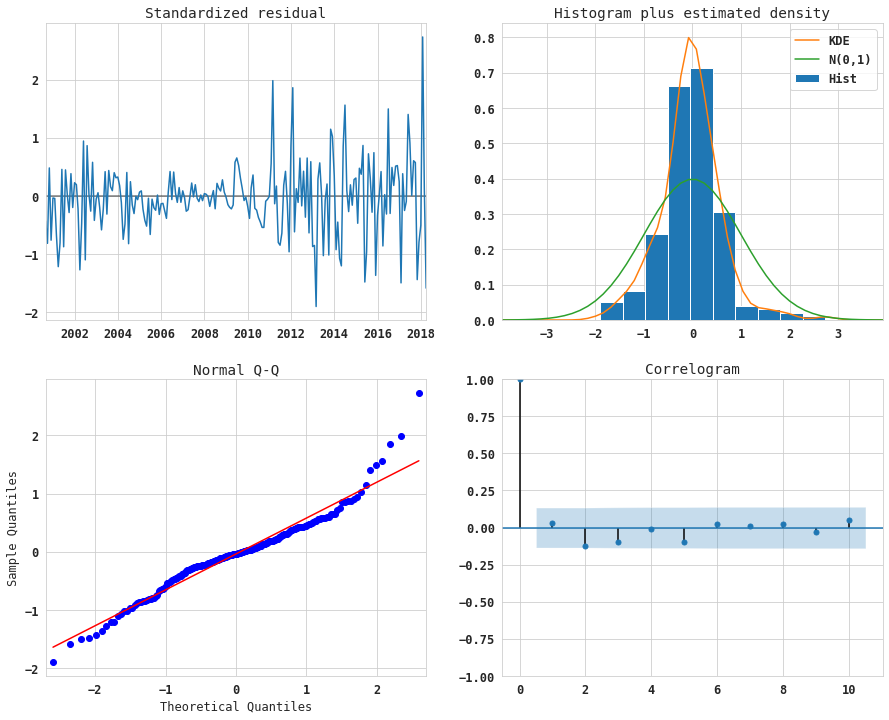

In [112]:
warnings.filterwarnings("ignore") # specify to ignore warning messages
AIC_list = pd.DataFrame({}, columns=['param','param_seasonal','AIC'])
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(melted_df.loc[melted_df['RegionName'] == 94301].value,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('ARIMA{}x{} - AIC:{}'.format(param, param_seasonal, results.aic))
            temp = pd.DataFrame([[ param ,  param_seasonal , results.aic ]], 
                                   columns=['param','param_seasonal','AIC'])
            AIC_list = AIC_list.append( temp, ignore_index=True)  
            del temp

        except:
            continue


m = np.amin(AIC_list['AIC'].values) # Find minimum value in AIC
l = AIC_list['AIC'].tolist().index(m) # Find index number for lowest AIC
Min_AIC_list = AIC_list.iloc[l,:]



mod = sm.tsa.statespace.SARIMAX(melted_df.loc[melted_df['RegionName'] == 94301].value,
                                order=Min_AIC_list['param'],
                                seasonal_order=Min_AIC_list['param_seasonal'],
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()

print("### Min_AIC_list ### \n{}".format(Min_AIC_list))

print(results.summary().tables[1])

results.plot_diagnostics(figsize=(15, 12))
plt.show()
# zipcode 94301

##### The output of our code suggests that `ARIMA(2,  2,  2)x(2,  2,  2, 12)` yields the lowest AIC value of `4573.21`. We should therefore consider this to be optimal option out of all the models we have considered for `the zipcode: 94301`

ARIMA(0, 0, 0)x(0, 0, 0, 12) - AIC:7993.0666066144995
ARIMA(0, 0, 0)x(0, 0, 1, 12) - AIC:1159971.3895404479
ARIMA(0, 0, 0)x(0, 0, 2, 12) - AIC:12689.014019569458
ARIMA(0, 0, 0)x(0, 1, 0, 12) - AIC:6601.890029879368
ARIMA(0, 0, 0)x(0, 1, 1, 12) - AIC:6249.091092705786
ARIMA(0, 0, 0)x(0, 1, 2, 12) - AIC:7716.267940881482
ARIMA(0, 0, 0)x(0, 2, 0, 12) - AIC:6166.668064128331
ARIMA(0, 0, 0)x(0, 2, 1, 12) - AIC:5871.751918674287
ARIMA(0, 0, 0)x(0, 2, 2, 12) - AIC:5536.190725879426
ARIMA(0, 0, 0)x(1, 0, 0, 12) - AIC:6433.768980278521
ARIMA(0, 0, 0)x(1, 0, 1, 12) - AIC:6402.297714921075
ARIMA(0, 0, 0)x(1, 0, 2, 12) - AIC:6103.34952917364
ARIMA(0, 0, 0)x(1, 1, 0, 12) - AIC:6182.919764716375
ARIMA(0, 0, 0)x(1, 1, 1, 12) - AIC:8187.356546222023
ARIMA(0, 0, 0)x(1, 1, 2, 12) - AIC:7706.151416105624
ARIMA(0, 0, 0)x(1, 2, 0, 12) - AIC:5850.153401901486
ARIMA(0, 0, 0)x(1, 2, 1, 12) - AIC:5826.463563522686
ARIMA(0, 0, 0)x(1, 2, 2, 12) - AIC:6582.850532348806
ARIMA(0, 0, 0)x(2, 0, 0, 12) - AIC:6123.1195

ARIMA(0, 1, 2)x(2, 0, 2, 12) - AIC:4869.811241483514
ARIMA(0, 1, 2)x(2, 1, 0, 12) - AIC:4592.110094155987
ARIMA(0, 1, 2)x(2, 1, 1, 12) - AIC:4590.373165848396
ARIMA(0, 1, 2)x(2, 1, 2, 12) - AIC:4519.189009038308
ARIMA(0, 1, 2)x(2, 2, 0, 12) - AIC:4578.876134784642
ARIMA(0, 1, 2)x(2, 2, 1, 12) - AIC:4528.6590566711475
ARIMA(0, 1, 2)x(2, 2, 2, 12) - AIC:4516.847491937477
ARIMA(0, 2, 0)x(0, 0, 0, 12) - AIC:5044.755790253326
ARIMA(0, 2, 0)x(0, 0, 1, 12) - AIC:4816.092664966256
ARIMA(0, 2, 0)x(0, 0, 2, 12) - AIC:4597.092800406668
ARIMA(0, 2, 0)x(0, 1, 0, 12) - AIC:5006.80702859144
ARIMA(0, 2, 0)x(0, 1, 1, 12) - AIC:4743.59058523969
ARIMA(0, 2, 0)x(0, 1, 2, 12) - AIC:4488.289213385305
ARIMA(0, 2, 0)x(0, 2, 0, 12) - AIC:5001.888236343788
ARIMA(0, 2, 0)x(0, 2, 1, 12) - AIC:4654.23089185177
ARIMA(0, 2, 0)x(0, 2, 2, 12) - AIC:4403.990303532686
ARIMA(0, 2, 0)x(1, 0, 0, 12) - AIC:4830.121557674023
ARIMA(0, 2, 0)x(1, 0, 1, 12) - AIC:4814.374563086469
ARIMA(0, 2, 0)x(1, 0, 2, 12) - AIC:4595.56714630

ARIMA(1, 0, 2)x(1, 1, 1, 12) - AIC:5734.7759706897905
ARIMA(1, 0, 2)x(1, 1, 2, 12) - AIC:5156.596764992331
ARIMA(1, 0, 2)x(1, 2, 0, 12) - AIC:4834.522933361093
ARIMA(1, 0, 2)x(1, 2, 1, 12) - AIC:5568.158264284857
ARIMA(1, 0, 2)x(1, 2, 2, 12) - AIC:5087.946110650626
ARIMA(1, 0, 2)x(2, 0, 0, 12) - AIC:4734.614108623082
ARIMA(1, 0, 2)x(2, 0, 1, 12) - AIC:5528.261560733086
ARIMA(1, 0, 2)x(2, 0, 2, 12) - AIC:4987.639601870211
ARIMA(1, 0, 2)x(2, 1, 0, 12) - AIC:4580.29263313699
ARIMA(1, 0, 2)x(2, 1, 1, 12) - AIC:5427.647172848438
ARIMA(1, 0, 2)x(2, 1, 2, 12) - AIC:5181.251456203631
ARIMA(1, 0, 2)x(2, 2, 0, 12) - AIC:4568.734178788332
ARIMA(1, 0, 2)x(2, 2, 1, 12) - AIC:5084.816946870458
ARIMA(1, 0, 2)x(2, 2, 2, 12) - AIC:4918.6995745027325
ARIMA(1, 1, 0)x(0, 0, 0, 12) - AIC:5063.650104974254
ARIMA(1, 1, 0)x(0, 0, 1, 12) - AIC:4831.793826724885
ARIMA(1, 1, 0)x(0, 0, 2, 12) - AIC:4607.623926046514
ARIMA(1, 1, 0)x(0, 1, 0, 12) - AIC:5015.047601568906
ARIMA(1, 1, 0)x(0, 1, 1, 12) - AIC:4754.21438

ARIMA(1, 2, 2)x(0, 2, 0, 12) - AIC:4941.859749481634
ARIMA(1, 2, 2)x(0, 2, 1, 12) - AIC:4522.840275077112
ARIMA(1, 2, 2)x(0, 2, 2, 12) - AIC:4294.666060254682
ARIMA(1, 2, 2)x(1, 0, 0, 12) - AIC:4743.229558758725
ARIMA(1, 2, 2)x(1, 0, 1, 12) - AIC:4724.998662363918
ARIMA(1, 2, 2)x(1, 0, 2, 12) - AIC:4501.004747167866
ARIMA(1, 2, 2)x(1, 1, 0, 12) - AIC:4681.198479086388
ARIMA(1, 2, 2)x(1, 1, 1, 12) - AIC:4643.222503674842
ARIMA(1, 2, 2)x(1, 1, 2, 12) - AIC:4347.2425201838
ARIMA(1, 2, 2)x(1, 2, 0, 12) - AIC:4655.8508286395845
ARIMA(1, 2, 2)x(1, 2, 1, 12) - AIC:4534.199226359864
ARIMA(1, 2, 2)x(1, 2, 2, 12) - AIC:4684.673611239123
ARIMA(1, 2, 2)x(2, 0, 0, 12) - AIC:4540.06683956741
ARIMA(1, 2, 2)x(2, 0, 1, 12) - AIC:4536.331742355151
ARIMA(1, 2, 2)x(2, 0, 2, 12) - AIC:4498.506469326026
ARIMA(1, 2, 2)x(2, 1, 0, 12) - AIC:4428.1290528412255
ARIMA(1, 2, 2)x(2, 1, 1, 12) - AIC:4433.569794734742
ARIMA(1, 2, 2)x(2, 1, 2, 12) - AIC:4394.433842652371
ARIMA(1, 2, 2)x(2, 2, 0, 12) - AIC:4358.2217494

ARIMA(2, 1, 1)x(2, 2, 2, 12) - AIC:4313.253880732093
ARIMA(2, 1, 2)x(0, 0, 0, 12) - AIC:4960.924868646594
ARIMA(2, 1, 2)x(0, 0, 1, 12) - AIC:4731.150916447037
ARIMA(2, 1, 2)x(0, 0, 2, 12) - AIC:4511.302236064742
ARIMA(2, 1, 2)x(0, 1, 0, 12) - AIC:4932.85469035121
ARIMA(2, 1, 2)x(0, 1, 1, 12) - AIC:4618.768737848526
ARIMA(2, 1, 2)x(0, 1, 2, 12) - AIC:4377.021894772417
ARIMA(2, 1, 2)x(0, 2, 0, 12) - AIC:4903.5272277217655
ARIMA(2, 1, 2)x(0, 2, 1, 12) - AIC:4573.336159047335
ARIMA(2, 1, 2)x(0, 2, 2, 12) - AIC:4329.349898296428
ARIMA(2, 1, 2)x(1, 0, 0, 12) - AIC:4747.968853249449
ARIMA(2, 1, 2)x(1, 0, 1, 12) - AIC:4733.148696879264
ARIMA(2, 1, 2)x(1, 0, 2, 12) - AIC:4511.509435064065
ARIMA(2, 1, 2)x(1, 1, 0, 12) - AIC:4644.272085605775
ARIMA(2, 1, 2)x(1, 1, 1, 12) - AIC:4620.5353225030285
ARIMA(2, 1, 2)x(1, 1, 2, 12) - AIC:4378.979005585485
ARIMA(2, 1, 2)x(1, 2, 0, 12) - AIC:4629.308176205054
ARIMA(2, 1, 2)x(1, 2, 1, 12) - AIC:4570.803808475732
ARIMA(2, 1, 2)x(1, 2, 2, 12) - AIC:4277.73096

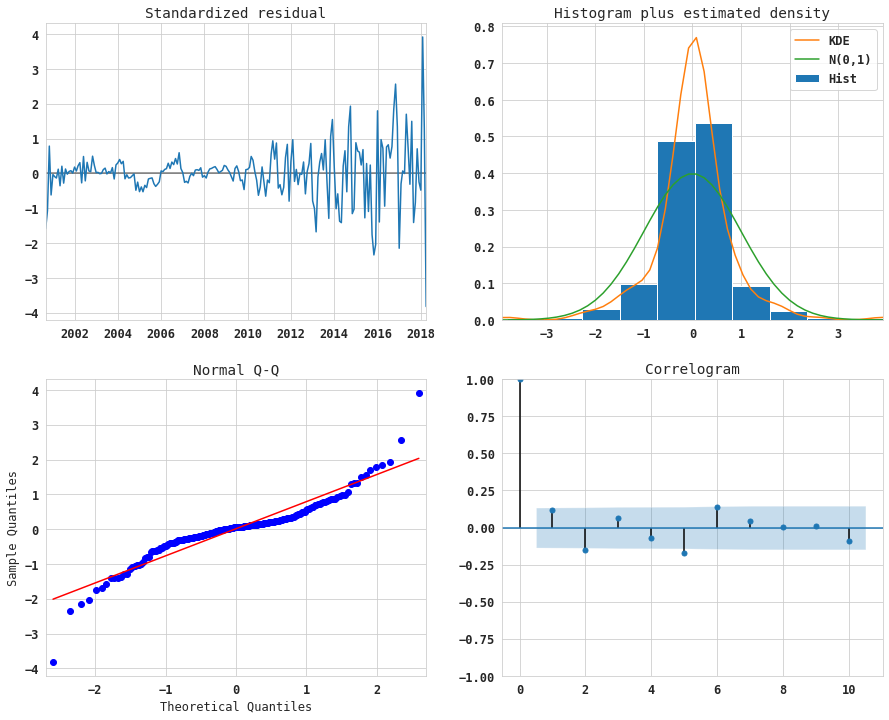

In [111]:
warnings.filterwarnings("ignore") # specify to ignore warning messages
AIC_list = pd.DataFrame({}, columns=['param','param_seasonal','AIC'])
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(melted_df.loc[melted_df['RegionName'] == 94043].value,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('ARIMA{}x{} - AIC:{}'.format(param, param_seasonal, results.aic))
            temp = pd.DataFrame([[ param ,  param_seasonal , results.aic ]], 
                                   columns=['param','param_seasonal','AIC'])
            AIC_list = AIC_list.append( temp, ignore_index=True)  
            del temp

        except:
            continue


m = np.amin(AIC_list['AIC'].values) # Find minimum value in AIC
l = AIC_list['AIC'].tolist().index(m) # Find index number for lowest AIC
Min_AIC_list = AIC_list.iloc[l,:]



mod = sm.tsa.statespace.SARIMAX(melted_df.loc[melted_df['RegionName'] == 94043].value,
                                order=Min_AIC_list['param'],
                                seasonal_order=Min_AIC_list['param_seasonal'],
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()

print("### Min_AIC_list ### \n{}".format(Min_AIC_list))

print(results.summary().tables[1])

results.plot_diagnostics(figsize=(15, 12))
plt.show()
# zipcode 94043

##### The output of our code suggests that `ARIMA(2,  2,  2)x(2,  2,  2, 12)` yields the lowest AIC value of `4214.45`. We should therefore consider this to be optimal option out of all the models we have considered for `the zipcode: 94043`

In [54]:
sum_list2 = []
sum_list2.append({'zipcode': 94086, 'param': (2, 2, 0), 'param_seasonal': (2, 2, 0, 12), 'AIC': 4089.68})
sum_list2.append({'zipcode': 94040, 'param': (0, 2, 2), 'param_seasonal': (1, 2, 2, 12), 'AIC': 4302.12})
sum_list2.append({'zipcode': 94303, 'param': (2, 2, 2), 'param_seasonal': (2, 2, 2, 12), 'AIC': 4422.5})
sum_list2.append({'zipcode': 94301, 'param': (2, 2, 2), 'param_seasonal': (2, 2, 2, 12), 'AIC': 4573.21})
sum_list2.append({'zipcode': 94043, 'param': (2, 2, 2), 'param_seasonal': (2, 2, 2, 12), 'AIC': 4214.45})

sum_df2 = pd.DataFrame(sum_list2, columns=['zipcode', 'param','param_seasonal', 'AIC'])
sum_df2

zipcode      param param_seasonal      AIC
0    94086  (2, 2, 0)  (2, 2, 0, 12)  4089.68
1    94040  (0, 2, 2)  (1, 2, 2, 12)  4302.12
2    94303  (2, 2, 2)  (2, 2, 2, 12)  4422.50
3    94301  (2, 2, 2)  (2, 2, 2, 12)  4573.21
4    94043  (2, 2, 2)  (2, 2, 2, 12)  4214.45

In [55]:
sum_df1

zipcode      param param_seasonal       AIC
0    94086  (3, 1, 0)  (2, 1, 0, 12)  5300.039
1    94040  (0, 1, 3)  (1, 1, 1, 12)  5472.274
2    94303  (2, 1, 0)  (2, 1, 0, 12)  5545.903
3    94301  (0, 1, 2)  (2, 1, 2, 12)  5754.401
4    94043  (3, 1, 0)  (2, 1, 0, 12)  5296.126

# Step 5: ARIMA Modeling

In [57]:
melted_df.loc[melted_df['RegionName'] == 94043].value

time
1996-04-01     291700.0
1996-05-01     294000.0
1996-06-01     296400.0
1996-07-01     298900.0
1996-08-01     301400.0
1996-09-01     304100.0
1996-10-01     306800.0
1996-11-01     309600.0
1996-12-01     312700.0
1997-01-01     316000.0
1997-02-01     319200.0
1997-03-01     322100.0
1997-04-01     325200.0
1997-05-01     328400.0
1997-06-01     331600.0
1997-07-01     334900.0
1997-08-01     338300.0
1997-09-01     341600.0
1997-10-01     345100.0
1997-11-01     348300.0
1997-12-01     351800.0
1998-01-01     355600.0
1998-02-01     359100.0
1998-03-01     362200.0
1998-04-01     365500.0
1998-05-01     368900.0
1998-06-01     372400.0
1998-07-01     376000.0
1998-08-01     379900.0
1998-09-01     384000.0
                ...    
2015-11-01    1501600.0
2015-12-01    1490400.0
2016-01-01    1493500.0
2016-02-01    1499600.0
2016-03-01    1492800.0
2016-04-01    1485200.0
2016-05-01    1483700.0
2016-06-01    1482600.0
2016-07-01    1484100.0
2016-08-01    1487600.0
2016-09-01 

In [61]:
#plit train test data set
#train_set
#test_set

##### Questions:
* should we drop missing data or fill data
* diff data, can't remove trend ??? still non-stationary
* auto_arima results, stepwise auto_arima results, SARIMAX results conflicts.


Making a test on one zipcode to then use the code for everything

In [367]:
test = melted_df.loc[melted_df['RegionName'] == 94086]
test.index.freq = 'MS'

In [368]:
test.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 265 entries, 1996-04-01 to 2018-04-01
Freq: MS
Data columns (total 8 columns):
RegionID      265 non-null int64
RegionName    265 non-null int64
City          265 non-null object
State         265 non-null object
Metro         265 non-null object
CountyName    265 non-null object
SizeRank      265 non-null int64
value         265 non-null float64
dtypes: float64(1), int64(3), object(4)
memory usage: 18.6+ KB


In [396]:
ARIMA_MODEL = sm.tsa.statespace.SARIMAX(test.value,
                                order=(0, 2, 0), 
                                enforce_stationarity=False, 
                                enforce_invertibility=False)

# Fit the model and print results
output = ARIMA_MODEL.fit()
display(output.summary().tables[0], output.summary().tables[1], output.summary().tables[2])

<class 'statsmodels.iolib.table.SimpleTable'>

<class 'statsmodels.iolib.table.SimpleTable'>

<class 'statsmodels.iolib.table.SimpleTable'>

Printing the diagnostics of the model

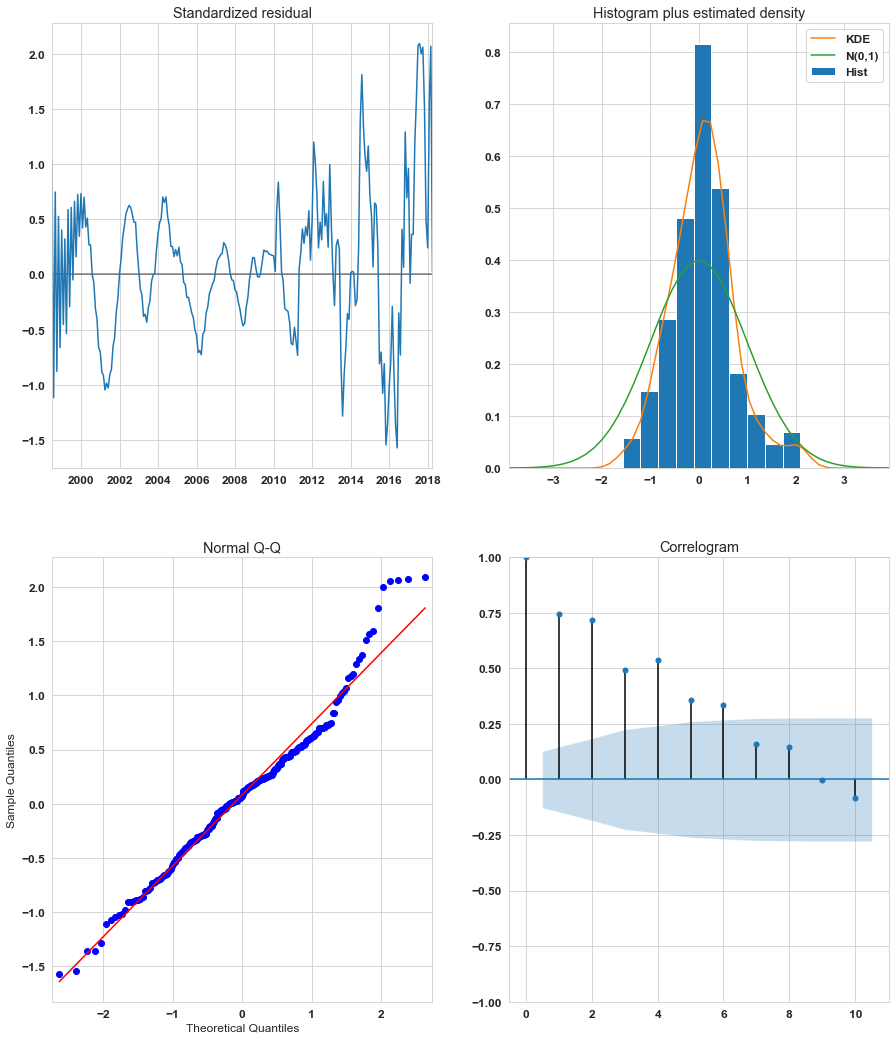

In [370]:
output.plot_diagnostics(figsize=(15, 18))
plt.show()

Checking getting the predictions along with the lower and upper confidence intervals

In [371]:
pred = output.get_prediction(start=pd.to_datetime('2015-01-01'), dynamic=False)
pred_conf = pred.conf_int()

In [372]:
b = {}
b['a'] = pred_conf[pred_conf.index == '2015-02-01']['lower value'][0]

In [373]:
pred_conf[pred_conf.index == '2015-02-01']['lower value']

time
2015-02-01    1.194443e+06
Freq: MS, Name: lower value, dtype: float64

In [374]:
b

{'a': 1194443.3658215997}

In [375]:
pred_conf['upper value'].mean()

1485015.6107959582

In [376]:
pred.predicted_mean['2018-01-01']

1808734.6407807155

Making a graph of the predictions and the original data

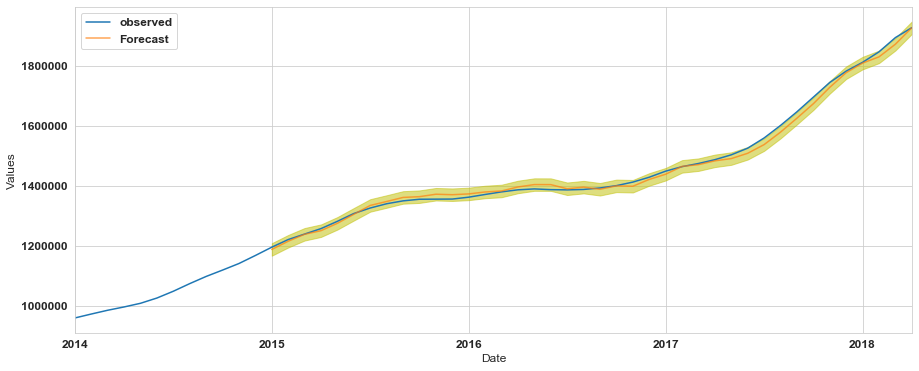

In [377]:
rcParams['figure.figsize'] = 15, 6

#Plot observed values
ax = test['2014':].value.plot(label='observed')

#Plot predicted values
pred.predicted_mean.plot(ax=ax, label='Forecast', alpha=.7)

#Plot the range for confidence intervals
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='y', alpha=.5)

#Set axes labels
ax.set_xlabel('Date')
ax.set_ylabel('Values')
plt.legend()

plt.show()

Checking the RMSE

In [51]:
test_forecasted = pred.predicted_mean
test_truth = test['2017':].value
test_forecasted = test_forecasted['2017':]
# Compute the root mean square error
error = mean_squared_error(test_forecasted, test_truth)
error = np.sqrt(error)
print(f'The RMSE of our forecasts is {error}')

The RMSE of our forecasts is 5988.475924964036


Our predictions are within about 380,000 dollars. Meaning about give or take 140,000 dollars. This is not too bad concidering that this zipcode has houses over a million dollars

I would like to figure out the best parameters to use for the model, based on AIC.  
First I will generate the possible combinations and then get the best one for each zipcode

In [141]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [142]:
melted_df1_zipcode = melted_df1.loc[melted_df1['RegionName'] == zipcode].value
melted_df1_zipcode.index.freq = 'MS'

In [143]:
best_combs1 = []
for zipcode in tqdm(best_five):
    ans = []
    for comb in pdq:
        for combs in pdqs:
            try:
                mod = sm.tsa.statespace.SARIMAX(melted_df1_zipcode,
                                                order=comb,
                                                seasonal_order=combs,
                                                enforce_stationarity=False,
                                                enforce_invertibility=False)

                output = mod.fit()
                ans.append([zipcode, comb, combs, output.aic])
    #             print(f'ARIMA {comb} x {combs}12 : AIC Calculated ={output.aic}')
            except:
                continue
    best_combs1.append(sorted(ans, key=lambda x: x[3])[0])

100%|██████████| 5/5 [01:55<00:00, 22.90s/it]


In [145]:
best_combs1

[[60611, (1, 1, 1), (1, 1, 1, 12), 4305.40636201969],
 [60654, (1, 1, 1), (1, 1, 1, 12), 4305.40636201969],
 [60614, (1, 1, 1), (1, 1, 1, 12), 4305.40636201969],
 [60610, (1, 1, 1), (1, 1, 1, 12), 4305.40636201969],
 [60657, (1, 1, 1), (1, 1, 1, 12), 4305.40636201969]]

In [121]:
best_combs = []
for zipcode in tqdm(melted_df1.RegionName.unique()):
    ans = []
    for comb in pdq:
        for combs in pdqs:
            try:
                mod = sm.tsa.statespace.SARIMAX(melted_df1_zipcode,
                                                order=comb,
                                                seasonal_order=combs,
                                                enforce_stationarity=False,
                                                enforce_invertibility=False)

                output = mod.fit()
                ans.append([zipcode, comb, combs, output.aic])
    #             print(f'ARIMA {comb} x {combs}12 : AIC Calculated ={output.aic}')
            except:
                continue
    best_combs.append(sorted(ans, key=lambda x: x[3])[0])

100%|██████████| 41/41 [09:40<00:00, 13.64s/it]


In [54]:
best_combs

[[60657, (1, 1, 1), (1, 1, 1, 12), 4305.40636201969],
 [60614, (1, 1, 1), (1, 1, 1, 12), 4391.733980410509],
 [60640, (1, 1, 1), (1, 1, 1, 12), 4436.878941715935],
 [60647, (1, 1, 1), (1, 1, 1, 12), 4038.817320471002],
 [60618, (1, 1, 1), (1, 1, 1, 12), 3891.916002143143],
 [60613, (1, 1, 1), (1, 1, 1, 12), 4312.848675944838],
 [60629, (1, 1, 1), (0, 1, 1, 12), 3526.6441576096204],
 [60625, (1, 1, 1), (1, 1, 1, 12), 3924.10167222546],
 [60619, (1, 1, 1), (1, 1, 1, 12), 3788.2382601526037],
 [60610, (1, 1, 1), (1, 1, 1, 12), 4423.624017354146],
 [60611, (0, 1, 1), (1, 1, 0, 12), 710.5497875859785],
 [60620, (1, 1, 1), (1, 1, 1, 12), 3739.730606962475],
 [60634, (1, 1, 1), (1, 1, 1, 12), 3740.9715825532003],
 [60626, (1, 1, 1), (1, 1, 1, 12), 4155.327103492211],
 [60649, (1, 1, 1), (0, 1, 1, 12), 4053.1804781087453],
 [60616, (1, 1, 1), (1, 1, 1, 12), 3976.934348377008],
 [60622, (1, 1, 1), (1, 1, 1, 12), 4358.7703591835325],
 [60615, (1, 1, 1), (1, 1, 1, 12), 4192.493783768521],
 [60641

These are the best combinations for each zipcode, using 12 for seasonality and a 0 or a 1 for everything else.  
I will now try to check changing everything, including seasonality to see which ones are the best

In [ ]:
# Define the p, d and q parameters to take any value between 0 and 10
p = d = q = range(0, 11)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Define the p, d, q and s parameters to take any value between 0 and 10
p2 = d2 = q2 = s = range(0, 11)

# Generate all different combinations of seasonal p, q and q triplets
pdqs = [(x[0], x[1], x[2], x[3]) for x in list(itertools.product(p2, d2, q2, s))]

In [ ]:
len(pdqs)

Make a function for creating an image with the original data, and the predicted data, along with the forcasted data and the confidence intervals

In [ ]:
def make_pred_image(df, test_forecasted, forcast, zipcode=None):
    rcParams['figure.figsize'] = 15, 6

    #Plot observed values
    ax = df['2015':].plot(label='observed')

    #Plot predicted values
    test_forecasted['2015-01-01':].plot(ax=ax, label='Predicted', alpha=.7)
    
    forcast.predicted_mean.plot(ax=ax, label='Forecast', alpha=.7)

    #Plot the range for confidence intervals
    ax.fill_between(pred_conf.index,
                    pred_conf.iloc[:, 0],
                    pred_conf.iloc[:, 1], color='y', alpha=.5)

    #Set axes labels
#     ax.title(zipcode)
    ax.set_xlabel('Date')
    ax.set_ylabel('Values')
    plt.legend()

    plt.show()
    return None

I am using a loop to get predictions for each zipcode based on the best combinations of parameters.  
It will also print out a graph for each zipcode along with the diagnostics.  
I put all the metrics I want into dictionaries with the zipcode as the key and the metric as the value.  
I also setup a dataframe and then make each dictionary correspond to a column in the dataframe

In [ ]:
pred_df = pd.DataFrame()
known_RMSE = {}
forcast_2019_04 = {}
confid_min = {}
confid_max = {}
profit = {}
roi = {}
for comb in best_combs:
    
    if comb[0] == 60611:
        
        df = melted_df1.loc[melted_df1['RegionName'] == comb[0]].value.dropna()
        
        mod = sm.tsa.statespace.SARIMAX(df,
                                    order=comb[1],
                                    seasonal_order=comb[2],
                                    enforce_stationarity=False,
                                    enforce_invertibility=False,)

        output = mod.fit()
        pred = output.get_prediction(start=pd.to_datetime('2013-07-01'), dynamic=False)
        test_forecasted = pred.predicted_mean
        test_truth = test['2013-07-01':].value
        test_forecasted = test_forecasted['2013-07-01':]
    else:
        
        df = melted_df1.loc[melted_df1['RegionName'] == comb[0]].value.dropna()
       
        mod = sm.tsa.statespace.SARIMAX(df,
                                    order=comb[1],
                                    seasonal_order=comb[2],
                                    enforce_stationarity=False,
                                    enforce_invertibility=False)

        output = mod.fit()
        pred = output.get_prediction(start=pd.to_datetime('1996-04-01'), dynamic=False)
        test_forecasted = pred.predicted_mean
        test_truth = test['1996-04-01':].value
        test_forecasted = test_forecasted['1996-04-01':]
    error = mean_squared_error(test_forecasted, test_truth)
    known_RMSE[comb[0]] = np.sqrt(error)
    forcast = output.get_forecast(steps=24)
    forcast_2019_04[comb[0]] = forcast.predicted_mean['2019-04-01']
    pred_conf = forcast.conf_int()
    confid_min[comb[0]] = pred_conf[pred_conf.index == '2019-04-01']['lower value'][0]
    confid_max[comb[0]] = pred_conf[pred_conf.index == '2019-04-01']['upper value'][0]
    val_04_18 = melted_df1.loc[melted_df1['RegionName'] == comb[0]].value[-1]
    profit[comb[0]] = forcast.predicted_mean['2019-04'] - val_04_18
    roi[comb[0]] = profit[comb[0]]/val_04_18
    
    print(comb[0])
    make_pred_image(df, test_forecasted, forcast)
    output.plot_diagnostics(figsize=(12, 15))
    plt.show()
    
    

pred_df['zipcode'] = known_RMSE.keys()
pred_df['known_RMSE'] = known_RMSE.values()
pred_df['forcast_2019_04'] = forcast_2019_04.values()
pred_df['confid_min'] = confid_min.values()
pred_df['confid_max'] = confid_max.values()
pred_df['profit'] = profit.values()
pred_df['roi'] = roi.values()

Cleaning up how the data is displayed to make it easier to read in the dataframe

In [ ]:
pred_df['roi'] = pred_df['roi'].apply(lambda x: round(x[0], 2))

In [ ]:
pred_df['profit'] = pred_df['profit'].apply(lambda x: round(x[0]))

In [ ]:
pred_df['2018_04_price'] = pred_df['forcast_2019_04'] - pred_df['profit']

In [ ]:
pred_df['2018_04_price'] = pred_df['2018_04_price'].apply(lambda x: round(x))

In [ ]:
pred_df['forcast_2019_04'] = pred_df['forcast_2019_04'].apply(lambda x: round(x))

In [ ]:
pred_df['known_RMSE'] = pred_df['known_RMSE'].apply(lambda x: round(x, 2))

In [ ]:
pred_df['confid_min'] = pred_df['confid_min'].apply(lambda x: round(x))

In [ ]:
pred_df['confid_max'] = pred_df['confid_max'].apply(lambda x: round(x))

In [ ]:
pred_df.sort_values(by=['profit', 'roi'], ascending=False).head(10)

In [ ]:
pred_df_d = pd.DataFrame()
known_RMSE = {}
forcast_2019_04 = {}
confid_min = {}
confid_max = {}
profit = {}
roi = {}
for comb in best_combs:
    
    if comb[0] == 60611:
        
        df = melted_df1.loc[melted_df1['RegionName'] == comb[0]].value.dropna()
        
        mod = sm.tsa.statespace.SARIMAX(df,
                                    order=comb[1],
                                    seasonal_order=comb[2],
                                    enforce_stationarity=False,
                                    enforce_invertibility=False,)

        output = mod.fit()
        pred = output.get_prediction(start=pd.to_datetime('2013-07-01'), dynamic=True)
        test_forecasted = pred.predicted_mean
        test_truth = test['2013-07-01':].value
        test_forecasted = test_forecasted['2013-07-01':]
    else:
        
        df = melted_df1.loc[melted_df1['RegionName'] == comb[0]].value.dropna()
       
        mod = sm.tsa.statespace.SARIMAX(df,
                                    order=comb[1],
                                    seasonal_order=comb[2],
                                    enforce_stationarity=False,
                                    enforce_invertibility=False)

        output = mod.fit()
        pred = output.get_prediction(start=pd.to_datetime('1996-04-01'), dynamic=True, full_results=True)
        test_forecasted = pred.predicted_mean
        test_truth = test['1996-04-01':].value
        test_forecasted = test_forecasted['1996-04-01':]
    error = mean_squared_error(test_forecasted, test_truth)
    known_RMSE[comb[0]] = np.sqrt(error)
    forcast = output.get_forecast(steps=24, dynamic=True)
    forcast_2019_04[comb[0]] = forcast.predicted_mean['2019-04-01']
    pred_conf = forcast.conf_int()
    confid_min[comb[0]] = pred_conf[pred_conf.index == '2019-04-01']['lower value'][0]
    confid_max[comb[0]] = pred_conf[pred_conf.index == '2019-04-01']['upper value'][0]
    val_04_18 = melted_df1.loc[melted_df1['RegionName'] == comb[0]].value[-1]
    profit[comb[0]] = forcast.predicted_mean['2019-04'] - val_04_18
    roi[comb[0]] = profit[comb[0]]/val_04_18
    
    print(comb[0])
    make_pred_image(df, test_forecasted, forcast)
    output.plot_diagnostics(figsize=(12, 15))
    plt.show()
    
    

pred_df_d['zipcode'] = known_RMSE.keys()
pred_df_d['known_RMSE'] = known_RMSE.values()
pred_df_d['forcast_2019_04'] = forcast_2019_04.values()
pred_df_d['confid_min'] = confid_min.values()
pred_df_d['confid_max'] = confid_max.values()
pred_df_d['profit'] = profit.values()
pred_df_d['roi'] = roi.values()

In [ ]:
pred_df_d['roi'] = pred_df_d['roi'].apply(lambda x: round(x[0], 2))

In [ ]:
pred_df_d['profit'] = pred_df_d['profit'].apply(lambda x: round(x[0]))

In [ ]:
pred_df_d['2018_04_price'] = pred_df_d['forcast_2019_04'] - pred_df['profit']

In [ ]:
pred_df_d['2018_04_price'] = pred_df_d['2018_04_price'].apply(lambda x: round(x))

In [ ]:
pred_df_d['forcast_2019_04'] = pred_df_d['forcast_2019_04'].apply(lambda x: round(x))

In [ ]:
pred_df_d['known_RMSE'] = pred_df_d['known_RMSE'].apply(lambda x: round(x, 2))

In [ ]:
pred_df_d['confid_min'] = pred_df_d['confid_min'].apply(lambda x: round(x))

In [ ]:
pred_df_d['confid_max'] = pred_df_d['confid_max'].apply(lambda x: round(x))

In [ ]:
pred_df_d.sort_values(by=['profit', 'roi'], ascending=False).head(10)

In [ ]:
pred_df.sort_values(by=['profit', 'roi'], ascending=False).head(10)

# Step 6: Interpreting Results